# Introduction
The aim of our project is to try to help people become more aware of what they consume.  In order to do this, the first thing we have to do is to inform ourselves about the current situation of consumption in Europe.
Once we know the current situation, we are more prepared to realize our goal: to discover hidden information in how we eat. This information can be discovered by making an analysis of the correlation between different foods.
These results can contribute to make people more aware of what they eat, and therefore, have more tools to take care of their food.

In this notebook, we will focus in analyzing several consumption trends in Europe, for example, to check if the population eats healthy or not, and if it follows the medical recommendations, for example the famous food pyramid.
We feel like it is important to do an analysis of how and what the population consumes before delivering a tool to help people eat healthier. 

# Structure of the notebook 

- A) Analysis of dataset "EFSA Comprehensive European Food Consumption Database"
- B) Analysis of dataset "Recipe1M+"
- Conclusion and next steps

# B) Analysis of dataset "Recipe1M+"

This jupyter notebook corresponds to one part (out of two) of the final report for this milestone. In this notebook we work on the [recpies dataset](http://pic2recipe.csail.mit.edu). Here we will import the dataset, analyze it, search for missing data, clean it, filter it, and start the analysis to ensure that everything is ok for the final milestone. Before starting with all the mentioned tasks, we will present the idea and objectives of this part of the project.

Nowadays, huge advances in medicine and nutrition have led us to understand that the way we eat plays the most important role in our health. Following a diet rich in omega 6, for example, will lead us into different diseases, like cancer. Avoiding bad diets is “easily” achieved by eating a great variety of different food, while minimizing the amount of unhealthy meals. However, things can get harder when we have certain restrictions or obligations in our diet, for instance if we have to counter a lack of iron, or if we are vegan.

In this part of the project, we will use the `Recipe1M+` dataset to find the correlation between ingredients and see which ingredients are more likely to appear together in a recipe. This way, we will investigate how some restriction or obligations in our diets can affect undesired raises in specific aliments. 

These are some of the questions we want to answer in this project:

- What is the presence correlation between ingredients in recipes?
- Are there increases/decreases in the consumption of some ingredients when fighting against a specific disease via nutrition?
- Are there increases/decreases in the consumption of some ingredients when having restrictions in our diet?
- Which recipes are recommended to fight against a specific disease while not resulting in an undesirable increase of some other ingredients?
- Is it easier or harder for people with restrictions in their diets to eat "healthy"?
- Which type of meals (e.g. spicy) are more correlated with unhealthy food?
- More...

In this first approach, we will base our project in 5 specific nutritional situations, expanding it for the third milestone:

- Lactose intolerance
- Gluten intolerance
- Vegan diet
- Countering iron deficiency
- Countering omega 3 deficiency


## Table of contents

**1) Analysis and cleaning of the datasets:** In this part we import the data, look for missing or/and NaN values, clean the data, format it if needed and filter it.

**2) General analysis of the data:** Before going into the analysis we intend to do, we first do a more general analysis of the ingredients in recipes to obtain important information we will need for extracting the proper conclusions. In addition, in this part we will solve any unexpected errors encountered.

**3) Starting the core analysis:** In this part we will really start with the core project in order to see that everything is ok for the final report.

In [1]:
# Importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import time
import operator
import json

In [2]:
# For beauty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
# Main printing function
def printMain(to_print):
    print(color.BLUE + color.BOLD + to_print + color.END)

## 1) Analysis and cleaning of the datasets

In this first section we get the datasets into pandas and analyse the structure and the content of them. The we find and handle NaN and missing values, clean and format the data, and filter it to remove unnecesary features or items. Finally we adapt the data for the following analysis.

We have two datasets: `layer1.json` that has information about list of recipes, and `det_ingrs.json` with the ingredients of the recipes from the previous dataset in a cleaner way.

### Importing the data
First of all, let's import both datasets and analyse them.

In [4]:
# Importing layer1.json
initial_time = time.time()
#df_recipes = pd.read_json('data/layer1.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("layer1.json dataset:")
#df_recipes.head()

(Time: 0.0 seconds)
layer1.json dataset:


In [5]:
# Importing det_ingrs.json
initial_time = time.time()
df_ingredients = pd.read_json('data/det_ingrs.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset:")
df_ingredients.head()

(Time: 15.97 seconds)
det_ingrs.json dataset:


,valid,id,ingredients
0,"[True, True, True, True, True, True, True, Tru...",000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,"[True, True, True, True, True, True, True, Tru...",000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,"[True, True, True, True, True, True, True, Tru...",000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,"[True, True, True, True, True, True, True]",00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,"[True, True, True, True, True]",00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


We can see that the first dataset has no interesting information for our analysis so far. The title, url and instructions are not useful for us, and the ingredients will be taken from the `df_ingredients` as they are more clean, and so, easier to use. We delete the first dataframe.

In [6]:
# Deleting the first dataset
#del df_recipes 

### Removing unnecessary data

In the `df_ingredients` we have 3 columns. The `ingredients` column is the most important one. `id` columns will be kept in the dataset, just in case we need to relate the two datasets in the future. The `valid` column will be deleted as it is not needed. Let's delete that feature.

In [7]:
df_ingredients = df_ingredients.drop(columns=['valid'])
df_ingredients.head()

,id,ingredients
0,000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


### Dealing with missing data

Before moving on, let's see if the dataframe has NaN data or empty list of ingredients:

In [8]:
# Looking for NaN values
printMain("Are there any null values?")
df_ingredients.isnull().values.any()

Are there any null values?


False

In [9]:
# Looking for empty lists
df_empty_rows = df_ingredients[df_ingredients['ingredients'].map(lambda d: len(d)) == 0]
printMain("What is the number of empty ingredient lists?")
len(df_empty_rows)

What is the number of empty ingredient lists?


0

We can see that there are no missing or empty values. Nothing to clean or fill.

It is true that there can still be missing ingredients, but if this is the case, we will find an ingredient named "". We know this does not happen, this can be seen later in the notebook.

### Reformating data

We can also see that the `ingredients` column is not well formatted. It would be more useful to have only a list of the ingredient of each recipe. Also, we ensure that ingredients are lower case, to avoid having same ingredients in different recipes that are different strings. We will also remove repeated ingredients in the list (*This was detected in the second section, but it is done here for cleaness*)

In this process of reformating the data, we do another thing. We found out in the general analysis that some ingredients sometimes are written in plural or singular. Also, some ingredients are separated into groups with too much granularity, which is not good for us. For example, 'chicken breasts' or 'chicken' for our analysis is the same, just chicken. In the following cell, we present a dictionary whose keys are ingredients that need to be transoformed ('chicken breasts'), and the values are the string into which the ingredients need to be transformed ('chicken').

*The generation of the dictionary was done manually, geting the most common ingredients (~500) and selecting the changes useful for our purpose.*

In [10]:
# Dictionary of format changes
dic_ingredients_changes = {
    "all - purpose flour": "flour",
    "whole wheat flour": "flour",
    "bread flour": "flour",
    "plain flour": "flour",
    "cake flour": "flour",
    "brown sugar": "sugar",
    "granulated sugar": "sugar",
    "white sugar": "sugar",
    "powdered sugar": "sugar",
    "confectioners' sugar": "sugar",
    "light brown sugar": "sugar",
    "dark brown sugar": "sugar",
    "caster sugar": "sugar",
    "extra virgin olive oil": "olive oil",
    "canola oil": "vegetable oil",
    "sesame oil": "vegetable oil",
    "peanut oil": "vegetable oil",
    "kosher salt": "salt",
    "sea salt": "salt",
    "seasoning salt": "salt",
    "coarse salt": "salt",
    "fresh parsley": "parsley",
    "flat leaf parsley": "parsley",
    "fresh parsley leaves": "parsley",
    "onions": "onion",
    "red onion": "onion",
    "red onions": "onion",
    "onion powder": "onion",
    "yellow onion": "onion",
    "yellow onions": "onion",
    "black pepper": "pepper",
    "fresh ground black pepper": "pepper",
    "ground black pepper": "pepper",
    "white pepper": "pepper",
    "crushed red pepper flakes": "red pepper flakes",
    "red bell pepper": "bell pepper",
    "red bell peppers": "bell pepper",
    "green peppers": "bell pepper",
    "green bell pepper": "bell pepper",
    "green bell peppers": "bell pepper",
    "green pepper": "bell pepper",
    "red peppers": "bell pepper",
    "bell peppers": "bell pepper",
    "red pepper": "bell pepper",
    "lemon juice": "lemon",
    "fresh lemon juice": "lemon",
    "lemons": "lemon",
    "lemon zest": "lemon",
    "fresh cilantro": "cilantro",
    "fresh ginger": "ginger",
    "ground ginger": "ginger",
    "boneless skinless chicken breasts": "chicken",
    "chicken breasts": "chicken",
    "cooked chicken": "chicken",
    "boneless skinless chicken breast halves": "chicken",
    "chicken stock": "chicken broth",
    "fresh basil": "basil",
    "dried basil": "basil",
    "fresh basil leaves": "basil",
    "basil leaves": "basil",
    "ground cumin": "cumin",
    "cumin seeds": "cumin",
    "bay leaves": "bay leaf",
    "dried thyme": "thyme",
    "fresh thyme": "thyme",
    "diced tomatoes": "tomatoes",
    "cherry tomatoes": "tomatoes",
    "plum tomatoes": "tomatoes",
    "dijon mustard": "mustard",
    "dry mustard": "mustard",
    "boiling water": "water",
    "cold water": "water",
    "warm water": "water",
    "hot water": "water",
    "ice": "water",
    "ice cubes": "water",
    "parmesan cheese": "cheese",
    "cheddar cheese": "cheese",
    "mozzarella cheese": "cheese",
    "shredded cheddar cheese": "cheese",
    "feta cheese": "cheese",
    "sharp cheddar cheese": "cheese",
    "monterey jack cheese": "cheese",
    "swiss cheese": "cheese",
    "ricotta cheese": "cheese",
    "blue cheese": "cheese",
    "parmigiano - reggiano cheese": "cheese",
    "celery ribs": "celery",
    "balsamic vinegar": "vinegar",
    "red wine vinegar": "vinegar",
    "cider vinegar": "vinegar",
    "white vinegar": "vinegar",
    "white wine vinegar": "vinegar",
    "apple cider vinegar": "vinegar",
    "rice vinegar": "vinegar",
    "heavy cream": "cream",
    "whipping cream": "cream",
    "heavy whipping cream": "cream",
    "whipped cream": "cream",
    "vanilla extract": "vanilla",
    "pure vanilla extract": "vanilla",
    "vanilla ice cream": "vanilla",
    "fresh mushrooms": "mushrooms",
    "sliced mushrooms": "mushrooms",
    "cream of mushroom soup": "mushrooms",
    "maple syrup": "syrup",
    "light corn syrup": "syrup",
    "shallots": "shallot",
    "fresh chives": "chives",
    "banana": "bananas",
    "lime juice": "lime",
    "fresh lime juice": "lime",
    "limes": "lime",
    "orange juice": "orange",
    "orange zest": "orange",
    "oranges": "orange",
    "of fresh mint": "mint",
    "semi - sweet chocolate chips": "chocolate",
    "chocolate chips": "chocolate",
    "semisweet chocolate": "chocolate",
    "ground allspice": "allspice",
    "cooked rice": "rice",
    "granny smith apples": "apple",
    "apples": "apple",
    "sliced almonds": "almonds",
    "slivered almonds": "almonds",
    "spaghetti": "pasta",
    "unsalted butter": "butter",
    "garlic cloves": "garlic",
    "garlic clove": "garlic",
    "garlic powder": "garlic",
    "garlic salt": "garlic",
    "panko breadcrumbs": "breadcrumbs",
    "white bread": "bread",
    "french bread": "bread",
    "black olives": "olives",
    "kalamata olives": "olives",
    "active dry yeast": "yeast",
    "fresh spinach": "spinach",
    "cracked black pepper": "pepper",
    "cream of chicken soup": "chicken broth",
    "cooking oil": "oil",
    "dry white wine": "white wine",
    "dry sherry": "red wine",
    "crushed tomatoes": "tomatoes",
    "goat cheese": "cheese",
    "fresh strawberries": "strawberries",
    "broccoli florets": "broccoli",
    "celery seeds": "celery",
    "bittersweet chocolate": "chocolate",
    "icing sugar": "sugar",
    "red potatoes": "potatoes",
    "russet potatoes": "potatoes",
    "salmon fillets": "salmon",
    "hot pepper sauce": "hot sauce",
    "dried parsley": "parsley",
    "pineapple juice": "pineapple",
    "crushed pineapple": "pineapple",
    "jalapeno peppers": "jalapeno",
    "jalapenos": "jalapeno",
    "low sodium chicken broth": "chicken",
    "chili powder": "chili",
    "green chilies": "chili",
    "whole milk": "milk",
    "low - fat milk": "milk",
    "skim milk": "milk",
    "avocados": "avocado",
    "rolled oats": "oat",
    "unsweetened cocoa powder": "cocoa",
    "cayenne pepper": "cayenne",
    "lean ground beef": "beef",
    "cucumbers": "cucumber",
    "ground nutmeg": "nutmeg",
    "fresh ground pepper": "pepper",
    "tomato paste": "tomatoes",
    "eggs": "egg",
    "egg yolks": "egg",
    "egg whites": "egg",
    "dried oregano": "oregano",
    "green onions": "scallions",
    "ground beef": "beef",
    "ground cinnamon": "cinnamon",
    "carrots": "carrot",    
    "white onions": "onion",
    "white onion": "onion",
    "elbow macaroni": "pasta",
    "roasted red peppers": "bell pepper",
    "pumpkin puree": "pumpkin",
    "plain yogurt": "yogurt",
    "black beans": "beans",
    "kidney beans": "beans",
    "velveeta cheese": "cheese",
    "ground coriander": "coriander",
    "fresh thyme leaves" : "thyme",
    "fresh flat - leaf parsley": "parsley",
    "ground pork": "pork",
    "fresh orange juice": "orange",
    "cinnamon sticks": "cinnamon",
    "prepared mustard": "mustard",
    "frozen chopped spinach": "spinach",
    "pork tenderloin": "pork",
    "fresh oregano": "oregano",
    "ground turkey": "turkey",
    "fresh mint leaves": "mint",
    "vegetable stock": "vegetable broth",
    "beef stock": "beef broth",
    "golden raisins": "raisins",
    "hard - boiled eggs": "egg",
    "philadelphia cream cheese": "cream cheese",
    "chopped tomatoes": "tomatoes",
    "lemon peel": "lemon",
    "apple juice": "apple",
    "dried rosemary": "rosemary",
    "jalapeno pepper": "jalapeno",
    "romaine lettuce": "lettuce",
    "baby spinach": "spinach",
    "gingerroot": "ginger",
    "dry red wine": "red wine",
    "vegetable shortening": "shortening",
    "creamy peanut butter": "peanut butter",
    "frozen corn": "corn",
    "cilantro leaves": "cilantro",
    "unbleached all - purpose flour": "flour",
    "mint leaves": "mint",
    "dark rum": "rum",
    "fresh coarse ground black pepper": "black pepper",
    "low sodium soy sauce": "soy sauce",
    "cool whip topping": "cool whip",
    "nonfat milk": "milk",
    "cinnamon stick": "cinnamon",
    "fresh blueberries": "blueberries",
    "ground pepper": "pepper",
    "sherry wine": "wine",
    "chili sauce": "chili",
    "low - fat sour cream": "sour cream",
    "potato": "potatoes",
    "flaked coconut": "coconut",
    "eggplants": "eggplant",
    "dry breadcrumbs": "breadcrumbs",
    "diced onions": "onion",
    "cottage cheese": "cheese",
    "yellow cornmeal": "cornmeal",
    "roma tomatoes": "tomatoes",
    "black peppercorns": "pepper",
    "rice wine vinegar": "vinegar",
    "crabmeat": "crab",
    "miniature marshmallows": "marshmallows",
    "sherry wine vinegar": "vinegar",
    "chicken thighs": "chicken",
    "pork chops": "pork",
    "grape tomatoes": "tomatoes",
    "vanilla bean": "vanilla",
    "ground red pepper": "red pepper flakes",
    "yukon gold potatoes": "potatoes",
    "baking potatoes": "potatoes",
    "tomato juice": "tomatoes",
    "ice water": "water",
    "corn syrup": "syrup",
    "ground cardamom": "cardamom",
    "fresh cilantro leaves": "cilantro",
    "smoked paprika": "paprika",
    "leeks": "leek",
    "celery salt": "salt",
    "large shrimp": "shrimp",
    "oats": "oat",
    "oatmeal": "oat",
    "baby carrots": "carrot",
    "fresh dill": "dill",
    "green onion": "scallions",
    "green olives": "olives",
    "celery rib": "celery",
    "sweet onions": "onion",
    "quick - cooking oats": "oat",
    "coconut oil": "vegetable oil",
    "old fashioned oats": "oat",  
    "pinto beans": "beans",
    "cannellini beans": "beans",
    "red kidney beans": "beans",
    "refried beans": "beans",
    "garbanzo beans": "chickpeas",
    "whole wheat bread": "bread",
    "dried marjoram": "marjoram",
    "italian bread": "bread",
    "toasted sesame seeds": "sesame seeds",
    "blanched almonds": "almonds",
    "lettuce leaves": "lettuce",
    "iceberg lettuce": "lettuce",
    "fresh breadcrumbs": "breadcrumbs",
    "italian seasoned breadcrumbs": "breadcrumbs",
    "kraft grated parmesan cheese": "cheese",
    "firm tofu": "tofu",
    "sun - dried tomatoes packed in oil": "sun - dried tomatoes",
    "fresh tomatoes": "tomatoes",
    "whole tomatoes": "tomatoes",
    "stewed tomatoes": "tomatoes",
    "portabella mushrooms": "mushrooms",
    "distilled white vinegar": "vinegar",
    "fresh mozzarella cheese": "cheese",
    "whipped topping": "cool whip",
    "smoked salmon": "salmon",
    "asparagus spears": "asparagus",
    "fresh green beans": "green beans",
    "flank steaks": "beef",
    "old bay seasoning": "seasoning",
    "taco seasoning mix": "seasoning",
    "mascarpone cheese": "cheese",
    "pure maple syrup": "syrup",
    "chocolate syrup": "chocolate",
    "simple syrup": "syrup",
    "fresh thyme sprigs": "thyme",
    "fresh coriander": "coriander",
    "cornflour": "cornstarch",
    "ground chuck": "beef",
    "mandarin oranges": "mandarin",
    "white flour": "flour",
    "fresh sage": "sage",
    "dried sage": "sage",
    "sweet potato": "sweet potatoes",
    "table salt": "salt",
    "parsley flakes": "parsley",
    "hamburger": "beef",
    "anchovy fillets": "anchovy",
    "basmati rice": "rice",
    "toasted sesame oil": "vegetable oil",
    "unsweetened cocoa": "cocoa",
    "cocoa powder": "cocoa",
    "long grain rice": "rice",
    "milk chocolate chips": "chocolate",
    "orzo pasta": "pasta",
    "snow peas": "pea",
    "2% low - fat milk": "milk",
    "monterey jack pepper cheese": "cheese",
    "corn kernels": "corn",
    "bean sprouts": "sprouts",
    "brussels sprouts": "sprouts",
    "salad oil": "oil",
    "fine sea salt": "salt",
    "sweet paprika": "paprika",
    "canned pumpkin": "pumpkin",
    "baby spinach leaves": "spinach",
    "chorizo sausage": "chorizo",
    "new potatoes": "potatoes",
    "mashed potatoes": "potatoes",
    "frozen spinach": "spinach",
    "cremini mushrooms": "mushrooms",
    "green chili peppers": "chili",
    "mustard powder": "mustard",
    "yellow mustard": "mustard",
    "italian sausage": "sausage",
    "splenda sugar substitute": "splenda",
    "orange marmalade": "jam",
    "marmalade": "jam",
    "pineapple chunks": "pineapple",
    "shiitake mushrooms": "mushrooms",
    "catsup": "ketchup",
    "fresh italian parsley": "parsley",
    "chipotle chiles in adobo": "jalapeno",
    "light soy sauce": "soy sauce",
    "baguette": "bread",
    "sweetened flaked coconut": "coconut",
    "unflavored gelatin": "gelatin",
    "penne pasta": "pasta",
    "fresh cranberries": "cranberries",
    "lime wedges": "lime",
    "salted butter": "butter",
    "egg noodles": "noodles",
    "american cheese": "cheese",
    "peppercorns": "pepper",
    "yellow bell pepper": "bell pepper",
    "half - and - half cream": "cream",
    "fresh tarragon": "tarragon",
    "fresh garlic": "garlic",
    "italian parsley": "parsley",
    "superfine sugar": "sugar",
    "baker's semi - sweet baking chocolate": "chocolate",
    "brown rice": "rice",
    "dry yeast": "yeast",
    "whole kernel corn": "corn",
    "minced garlic cloves": "garlic",
    "spring onions": "onion",
    "soymilk": "soy",
    "lasagna noodles": "noodles",
    "fresh sage": "sage",
    "pancetta": "bacon",
    "arborio rice": "rice",
    "romano cheese": "cheese",
    "poultry seasoning": "seasoning",
    "self - rising flour": "flour",
    "taco seasoning": "seasoning",
    "white chocolate chips": "chocolate",
    "scallions": "scallion",
    "orange peel": "orange",
    "chicken wings": "chicken",
    "lemon, juice of": "lemon",
    "orange rind": "orange",
    "unsweetened applesauce": "apple",
    "fresh gingerroot": "ginger",
    "medium shrimp": "shrimp",
    "linguine": "pasta",
    "boneless chicken breasts": "chicken",
    "hamburger buns": "bread",
    "pea": "peas",
    "frozen peas": "peas",
    "provolone cheese": "cheese",
    "ground turmeric": "turmeric",
    "lemon rind": "lemon",
    "prepared horseradish": "horseradish",
    "radish": "radishes",
    "lime zest": "lime",
    "white rice": "rice",
    "fresh raspberries": "raspberries",
    "lemon wedges": "lemon",
    "cooked ham": "ham",
    "gruyere cheese": "cheese",
    "hazelnuts": "hazelnut",
    "nonstick cooking spray": "vegetable oil",
    "light cream": "cream",
    "sweet onion": "onion",
    "maraschino cherries": "cherries",
    "button mushrooms": "mushrooms",
    "mustard seeds": "mustard",
    "dark chocolate": "cocoa",
    "tomato puree": "tomatoes",
    "coriander seeds": "coriander",
    "shredded coconut": "coconut",
    "grapeseed oil": "vegetable oil",
    "cooked chicken breasts": "chicken",
    "frozen mixed vegetables": "vegetables",
    "light mayonnaise": "mayonnaise",
    "mixed salad greens": "vegetables",
    "vanilla essence": "vanilla",
    "instant coffee": "coffee",
    "chicken breast halves": "chicken",
    "rice flour": "rice",
    "lemon extract": "lemon",
    "blackberries": "blueberries",
    "chicken bouillon cubes": "chicken",
    "macaroni": "pasta",
    "sweet red pepper": "bell pepper",
    "sweet red peppers": "bell pepper",
    "sifted flour": "flour",
    "cranberry juice": "cranberries",
    "boneless skinless chicken thighs": "chicken",
    "reduced - sodium chicken broth": "chicken broth",
    "cooked bacon": "bacon",
    "gorgonzola": "cheese",
    "whole wheat pastry flour": "flour",
    "saffron threads": "saffron",
    "condensed cream of mushroom soup": "mushroom",
    "apricot preserves": "apricot",
    "pecorino romano cheese": "cheese",
    "chilies": "chili",
    "diced green chilies": "chili",
    "asiago cheese": "cheese",
    "sourdough bread": "bread",
    "quick oats": "oat",
    "vegetable oil cooking spray": "vegetable oil",
    "fresh pineapple": "pineapple",
    "cherry pie filling": "cherries",
    "currants": "raisins",
    "light sour cream": "sour cream",
    "dried tarragon": "tarragon",
    "dried oregano leaves": "oregano",
    "yellow bell peppers": "bell pepper",
    "sea scallops": "scallops",
    "frozen whipped topping": "cool whip",
    "tomatillos": "tomatoes",
    "1% low - fat milk": "milk",   
    "minced ginger": "ginger",
    "ground cayenne pepper": "chili",
    "crystallized ginger": "ginger",
    "feta": "cheese",
    "whole black peppercorns": "papper",
    "dried cherries": "cherries",
    "red chili pepper": "chili",
    "fresh ground white pepper": "pepper",
    "mashed bananas": "bananas",
    "canned tomatoes": "tomatoes",
    "tomato": "tomatoes",
    "tomato soup": "tomatoes",
    "pea": "peas",
    "corn flake crumbs": "corn flakes",
    "tahini paste": "tahini",
    "tahini sauce": "tahini",
    "fresh mussels": "mussels",
    "oreo cookie crumbs": "oreo cookies",
    "virgin olive oil": "olive oil",
    "fennel bulbs": "fennel bulbs",
    "liquid smoke flavoring": "smoke flavoring",
    "hickory liquid smoke": "smoke",
    "watercress leaves": "watercress",
    "spanish chorizo": "chorizo",
    "chorizo sausages": "chorizo",
    "classico tomato and basil pasta sauce": "pasta sauce",
    "red pasta sauce": "pasta sauce",
    "tomato and basil pasta sauce": "pasta sauce",
    "pasta sauce with mushrooms": "pasta sauce",
    "sliced water chestnuts": "water chestnuts",
    "whole wheat pizza dough": "pizza dough",
    "basic pizza dough": "pizza dough",
    "frozen pizza dough": "pizza dough",
    "recipe pizza dough": "pizza dough",
    "honey graham crackers": "graham crackers",
    "cinnamon graham crackers": "graham crackers",
    "low - fat graham crackers": "graham crackers",
    "chocolate graham crackers": "graham crackers",
    "splenda granular": "splenda",
    "splenda brown sugar blend": "splenda",
    "splenda sugar blend for baking": "splenda",
    "toasted wheat germ": "wheat germ",
    "frozen rhubarb": "rhubarb",
    "fresh rhubarb": "rhubarb",
    "green food coloring": "food coloring", 
    "red food coloring": "food coloring",
    "yellow food coloring": "food coloring",
    "pink food coloring": "food coloring",
    "blue food coloring": "food coloring",
    "orange food coloring": "food coloring",
    "unbaked pie crusts": "pie crusts",
    "refrigerated pie crusts": "pie crusts",
    "frozen pie crusts": "pie crusts",
    "double crust pie crusts": "pie crusts",
    "ready - made pie crusts": "pie crusts",
    "mangoes": "mango",
    "mango juice": "mango",
    "mango pulp": "mango",
    "frozen mango chunks": "mango",
    "mango sorbet": "mango",
    "fresh mango": "mango",
    "mango chutney": "mango",
    "dried mango": "mango",
    "mango puree": "mango",
    "mango nectar": "mango",
    "mango salsa": "mango",
    "mango powder": "mango",
    "green mangoes": "mango",
    "pepperoni slices": "pepperoni",
    "turkey pepperoni": "pepperoni",
    "golden beets": "beets",
    "red beets": "beets",
    "baby beets": "beets",
    "canned beets": "beets",
    "pickled beets": "beets",
    "cooked beets": "beets",
    "raw beets": "beets",
    "kraft zesty italian dressing": "italian dressing",
    "1 env. good seasons italian dressing mix": "italian dressing",
    "light italian dressing": "italian dressing",
    "creamy italian dressing": "italian dressing",
    "good seasons italian dressing": "italian dressing",
    "tuna steaks": "tuna",
    "canned tuna": "tuna",
    "tuna in water": "tuna",
    "solid white tuna packed in water": "tuna",
    "tuna in olive oil": "tuna",
    "solid white tuna": "tuna",
    "albacore tuna": "tuna",
    "fresh tuna": "tuna",
    "ahi tuna steaks": "tuna",
    "chunk tuna": "tuna",
    "fresh ahi tuna": "tuna",
    "tuna steak": "tuna",
    "tuna in vegetable oil": "tuna",
    "1 can tuna": "tuna",
    "light chunk tuna in water": "tuna",
    "1 can canned tuna": "tuna",
    "yellowfin tuna fillets": "tuna",
    "tuna fish": "tuna",
    "albacore tuna in water": "tuna",
    "tuna packed in oil": "tuna",
    "chunk light tuna": "tuna",
    "tuna fillets": "tuna",
    "pesto sauce": "pesto",
    "sun - dried tomato pesto": "pesto",
    "basil pesto": "pesto",
    "dark soy sauce": "soy sauce",
    "reduced sodium soy sauce": "soy sauce",
    "kikkoman soy sauce": "soy sauce",
    "black soy sauce": "soy sauce",
    "japanese soy sauce": "soy sauce",
    "thin soy sauce": "soy sauce",
    "sweet soy sauce": "soy sauce",
    "tamari soy sauce": "soy sauce",
    "gluten - free soy sauce": "soy sauce",
    "mushroom soy sauce": "soy sauce",
    "soy yogurt": "soy",
    "plain soymilk": "soy",
    "unsweetened soymilk": "soy",
    "soy crumbles": "soy",
    "soybeans": "soy",
    "soy flour": "soy",
    "vanilla - flavored soymilk": "soy",
    "roasted soybeans": "soy",
    "dark soya sauce": "soy",
    "soy mayonnaise": "soy",
    "light vanilla soymilk": "soy",
    "soybean oil": "soy",
    "soy oil": "soy",
    "soy cheese": "soy",
    "soya milk": "soy",
    "israeli couscous": "couscous",
    "whole wheat couscous": "couscous",
    "cooked couscous": "couscous",
    "instant couscous": "couscous",
    "roasted sunflower seeds": "sunflower seeds",
    "unsalted sunflower seeds": "sunflower seeds",
    "salted sunflower seeds": "sunflower seeds",
     "mushroom soup": "mushroom",
    "mushrooms": "mushroom",
    "campbell's cream of mushroom soup": "mushroom",
    "1 can cream of mushroom soup": "mushroom",
    "white mushrooms": "mushroom",
    "dried wood ear mushrooms": "mushroom",
    "king oyster mushrooms": "mushroom",
    "dried chinese mushrooms": "mushroom",
    "dried porcini mushrooms": "mushroom",
    "fresh shiitake mushrooms": "mushroom",
    "portabella mushroom caps": "mushroom",
    "1 can mushroom soup": "mushroom",
    "canned mushrooms": "mushroom",
    "shiitake mushroom": "mushroom",
    "98% fat - free cream of mushroom soup": "mushroom",
    "shimeji mushrooms": "mushroom",
    "whole mushrooms": "mushroom",
    "mixed mushrooms": "mushroom",
    "porcini mushrooms": "mushroom",
    "enoki mushrooms": "mushroom",
    "dried black mushrooms": "mushroom",
    "mushroom stems and pieces": "mushroom",
    "mushroom caps": "mushroom",
    "brown button mushrooms": "mushroom",
    "condensed golden mushroom soup": "mushroom",
    "fresh large mushrooms": "mushroom",
    "onion and mushroom soup mix": "mushroom",
    "low - fat cream of mushroom soup": "mushroom",
    "baby bella mushrooms": "mushroom",
    "shiitake mushroom caps": "mushroom",
    "white button mushrooms": "mushroom",
    "1 can soup, cream of mushroom": "mushroom",
    "wild mushrooms": "mushroom",
    "mushroom broth": "mushroom",
    "mushroom cap": "mushroom",
    "1 can cream of mushroom": "mushroom",
    "dried shiitake mushrooms": "mushroom",
    "marinated mushrooms": "mushroom",
    "dried mushrooms": "mushroom",
    "wood ear mushrooms": "mushroom",
    "condensed cream of mushroom & garlic soup": "mushroom",
    "mushroom pieces": "mushroom",
    "oyster mushrooms": "mushroom",
    "field mushrooms": "mushroom",
    "fresh button mushrooms": "mushroom",
    "chinese black mushrooms": "mushroom",
    "2 cans cream of mushroom soup": "mushroom",
    "chanterelle mushrooms": "mushroom",
    "fresh white mushrooms": "mushroom",
    "fat - free cream of mushroom soup": "mushroom",
    "mushroom gravy": "mushroom",
    "baby portabella mushrooms": "mushroom",
    "canned mushroom slices": "mushroom",
    "button mushroom": "mushroom",
    "chestnut mushrooms": "mushroom",
    "small mushrooms": "mushroom",
    "1 packet shimeji mushrooms": "mushroom",
    "portabella mushroom": "mushroom",
    "condensed mushroom soup": "mushroom",
    "1 can mushrooms": "mushroom",
    "maitake mushrooms": "mushroom",
    "black mushrooms": "mushroom",
    "straw mushrooms": "mushroom",
    "mushroom stems": "mushroom",
    "cream of chicken and mushroom soup": "mushroom",
    "1 can condensed cream of mushroom soup": "mushroom",
    "pasta sauce with mushrooms": "mushroom",
    "dried wild mushrooms": "mushroom",
    "dry dill weed": "dill weed",
    "dried dill weed": "dill weed",
    "fresh dill weed": "dill weed",
    "crookneck yellow squash": "yellow squash",
    "bay scallops": "scallop",
    "veal scallops": "scallop",
    "large scallops": "scallop",
    "fresh scallops": "scallop",
    "fresh sea scallops": "scallop",
    "veal scallopini": "scallop",
    "white tequila": "tequila",
    "gold tequila": "tequila",
    "garam masala powder": "garam masala",
    "cooked quinoa": "quinoa",
    "quinoa flour": "quinoa",
    "toasted hazelnuts": "hazelnut",
    "hazelnut oil": "vegetable oil",
    "hazelnut meal": "hazelnut",
    "ground hazelnuts": "hazelnut",
    "hazelnut - flavored liqueur": "hazelnut",
    "kale leaves": "kale",
    "fresh kale": "kale",
    "1 box yellow cake mix": "yellow cake mix",
    "yellow cake mix with pudding": "yellow cake mix",
    "1 pkg. yellow cake mix": "yellow cake mix",
    "1 package yellow cake mix": "yellow cake mix",
    "dried pears": "pears",
    "asian pears": "pears",
    "bosc pears": "pears",
    "bartlett pears": "pears",
    "fresh pears": "pears",
    "red pears": "pears",
    "daikon radishes": "radishes",
    "red radishes": "radishes",
    "artichoke hearts": "artichoke",
    "marinated artichoke hearts": "artichoke",
    "artichoke bottoms": "artichoke",
    "artichokes": "artichoke",
    "water - packed artichoke hearts": "artichoke",
    "frozen artichoke hearts": "artichoke",
    "artichoke heart": "artichoke",
    "artichoke": "artichoke",
    "canned artichoke hearts": "artichoke",
    "jerusalem artichokes": "artichoke",
    "baby artichokes": "artichoke",
    "marinated artichokes": "artichoke",
    "spaghetti sauce": "pasta sauce",
    "spaghetti sauce mix": "pasta sauce",
    "1 jar spaghetti sauce": "pasta sauce",
    "meatless spaghetti sauce": "pasta sauce",
    "extra firm tofu": "tofu",
    "baked tofu": "tofu",
    "silken tofu": "tofu",
    "soft silken tofu": "tofu",
    "1 block tofu": "tofu",
    "soft tofu": "tofu",
    "firm silken tofu": "tofu",
    "1 block silken tofu": "tofu",
    "1 block firm tofu": "tofu",
    "1/2 block tofu": "tofu",
    "corn tortilla chips": "tortilla chips",
    "1 bag tortilla chips": "tortilla chips",
    "baked corn tortilla chips": "tortilla chips",
    "nacho cheese flavored tortilla chips": "tortilla chips",
    "blue corn tortilla chips": "tortilla chips",
    "arugula leaves": "arugula",
    "baby arugula": "arugula",
    "unsweetened chocolate squares": "cocoa",
    "unsweetened chocolate square": "cocoa",
    "unsweetened chocolate": "cocoa",
    "sparkling apple cider": "apple cider",
    "sweet apple cider": "apple cider",
    "heinz apple cider vinegar": "apple cider",
    "hard apple cider": "apple cider",
    "bourbon whiskey": "bourbon",
    "green mangoes": "mangoes",
    "black pepper": "pepper",
    "apricot jam": "jam",
    "peach jam": "jam",
    "raspberry jam": "jam",
    "fig jam": "jam",
    "seedless raspberry jam": "jam",
    "jamaican jerk spice": "jam",
    "strawberry jam": "jam",
    "fruit jam": "jam",
    "jamaican rum": "jam",
    "cherry jam": "jam",
    "plum jam": "jam",
    "blueberry jam": "jam",
    "blackberry jam": "jam",
    "seedless strawberry jam": "jam",
    "seedless red raspberry jam": "jam",
    "saffron thread": "saffron",
    "powdered saffron": "saffron",
    "saffron strands": "saffron",
    "white chocolate baking squares": "white chocolate",
    "imported white chocolate": "white chocolate",
    "white chocolate chunks": "white chocolate",
    "white chocolate curls": "white chocolate",
    "white chocolate baking bar": "white chocolate",
    "white chocolate liqueur": "white chocolate",
    "dry roasted peanuts": "peanuts",
    "spanish peanuts": "peanuts",
    "unsalted peanuts": "peanuts",
    "dry roasted salted peanuts": "peanuts",
    "roasted peanuts": "peanuts",
    "unsalted dry roasted peanuts": "peanuts",
    "salted peanuts": "peanuts",
    "raw peanuts": "peanuts",
    "honey roasted peanuts": "peanuts",
    "roasted unsalted peanuts": "peanuts",
    "dry - roasted unsalted peanuts": "peanuts",
    "honey - roasted peanuts": "peanuts",
    "strong black coffee": "coffee",
    "brewed coffee": "coffee",
    "instant coffee powder": "coffee",
    "non - dairy coffee creamer": "coffee",
    "instant coffee granules": "coffee",
    "strong coffee": "coffee",
    "coffee ice cream": "coffee",
    "coffee liqueur": "coffee",
    "coffee beans": "coffee",
    "instant coffee crystals": "coffee",
    "coffee creamer": "coffee",
    "chocolate - covered coffee beans": "coffee",
    "hot coffee": "coffee",
    "espresso coffee": "coffee",
    "coffee - flavored liqueur": "coffee",
    "powdered coffee creamer": "coffee",
    "very strong coffee": "coffee",
    "ground coffee": "coffee",
    "black coffee": "coffee",
    "coffee extract": "coffee",
    "non - dairy powdered coffee creamer": "coffee",
    "powdered instant coffee": "coffee",
    "instant espresso coffee powder": "coffee",
    "crab boil seasoning": "crab",
    "lump crabmeat": "crab",
    "fresh crabmeat": "crab",
    "imitation crabmeat": "crab",
    "dungeness crabmeat": "crab",
    "crabs": "crab",
    "imitation crab sticks": "crab",
    "canned crabmeat": "crab",
    "crab boil": "crab",
    "white crab meat": "crab",
    "blue crabs": "crab",
    "backfin crab meat": "crab",
    "jumbo lump crab meat": "crab",
    "crab claws": "crab",
    "fresh lump crabmeat": "crab",
    "king crab legs": "crab",
    "crab legs": "crab",
    "soft shelled crabs": "crab",
    "dungeness crabs": "crab",
    "pitted dates": "dates",
    "dried dates": "dates",
    "fresh marjoram": "marjoram",
    "ground marjoram": "marjoram",
    "marjoram leaves": "marjoram",
    "prosciutto di parma": "prosciutto",
    "prosciutto ham": "prosciutto",
    "fresh rosemary": "rosemary",
    "rosemary sprig": "rosemary",
    "rosemary sprigs": "rosemary",
    "fresh rosemary leaves": "rosemary",
    "ground rosemary": "rosemary",
    "dried rosemary leaves": "rosemary",
    "fresh rosemary needles": "rosemary",
    "cloves": "cloves",
    "whole cloves": "cloves",
    "fresh garlic cloves": "cloves",
    "roasted garlic cloves": "cloves",
    "powdered cloves": "cloves",
    "clove": "cloves",
    "ground cloves": "cloves",
    "frozen broccoli carrots cauliflower mix": "cauliflower",
    "cauliflower florets": "cauliflower",
    "head cauliflower": "cauliflower",
    "cauliflower floret": "cauliflower",
    "frozen cauliflower": "cauliflower",
    "heads cauliflower": "cauliflower",
    "cardamom powder": "cardamom",
    "green cardamom pods": "cardamom",
    "cardamom pod": "cardamom",
    "cardamom seeds": "cardamom",
    "cardamom pods": "cardamom",
    "green cardamoms": "cardamom",
    "black cardamom pods": "cardamom",
    "cardamoms": "cardamom",
    "whole cardamom pods": "cardamom",
    "white wine": "wine",
    "rose wine": "wine",
    "red wine": "wine",
    "rice wine": "wine",
    "marsala wine": "wine",
    "dry marsala wine": "wine",
    "cabernet sauvignon wine": "wine",
    "shaoxing wine": "wine",
    "wine vinegar": "wine",
    "burgundy wine": "wine",
    "madeira wine": "wine",
    "sauvignon blanc wine": "wine",
    "port wine": "wine",
    "full - bodied red wine": "wine",
    "cooking wine": "wine",
    "chinese wine": "wine",
    "sparkling wine": "wine",
    "riesling wine": "wine",
    "chinese rice wine": "wine",
    "muscat wine": "wine",
    "kitchen twine": "wine",
    "seasoned rice wine vinegar": "wine",
    "sauternes wine": "wine",
    "chardonnay wine": "wine",
    "sweet marsala wine": "wine",
    "dry wine": "wine",
    "white zinfandel wine": "wine",
    "pinot noir wine": "wine",
    "plum wine": "wine",
    "sweet white wine": "wine",
    "pinot grigio wine": "wine",
    "red burgundy wine": "wine",
    "chianti wine": "wine",
    "sweet red wine": "wine",
    "sweet wine": "wine",
    "sparkling white wine": "wine",
    "white wine worcestershire sauce": "wine",
    "strawberry jell - o gelatin dessert": "gelatin",
    "lemon jell - o gelatin": "gelatin",
    "1 envelope unflavored gelatin": "gelatin",
    "lime gelatin": "gelatin",
    "jello gelatin": "gelatin",
    "sugar - free strawberry gelatin": "gelatin",
    "lime jell - o gelatin": "gelatin",
    "gelatin powder": "gelatin",
    "sugar - free orange gelatin": "gelatin",
    "strawberry gelatin": "gelatin",
    "cherry gelatin": "gelatin",
    "gelatin sheets": "gelatin",
    "orange gelatin": "gelatin",
    "raspberry gelatin powder": "gelatin",
    "lemon gelatin": "gelatin",
    "raspberry jell - o gelatin": "gelatin",
    "1 env. knox unflavored gelatine": "gelatin",
    "sugar - free lemon gelatin": "gelatin",
    "plain gelatin": "gelatin",
    "sugar - free raspberry gelatin": "gelatin",
    "vanilla greek yogurt": "greek yogurt",
    "low - fat greek yogurt": "greek yogurt",
    "fat free greek yogurt": "greek yogurt",
    "canned peaches": "peaches",
    "fresh peaches": "peaches",
    "peaches in light syrup": "peaches",
    "dried peaches": "peaches",
    "white peaches": "peaches",
    "sliced peaches in juice": "peaches",
    "frozen peaches": "peaches",
    "frozen sliced peaches": "peaches",
    "chunky applesauce": "applesauce",
    "natural applesauce": "applesauce",
    "thai fish sauce": "fish sauce",
    "brandy extract": "brandy",
    "apricot brandy": "brandy",
    "apple brandy": "brandy",
    "cherry brandy": "brandy",
    "pear brandy": "brandy",
    "blackberry brandy": "brandy",
    "peach brandy": "brandy",
    "dried sweetened cranberries": "cranberries",
    "dried cranberries": "cranberries",
    "frozen cranberries": "cranberries",
    "raw cranberries": "cranberries",
    "light beer": "beer",
    "dark beer": "beer",
    "stout beer": "beer",
    "lager beer": "beer",
    "root beer": "beer",
    "ginger beer": "beer",
    "mexican beer": "beer",
    "1 can beer": "beer",
    "pilsner beer": "beer",
    "amber beer": "beer",
    "mixed vegetables": "vegetables",
    "assorted fresh vegetables": "vegetables",
    "frozen vegetables": "vegetables",
    "stir fry vegetables": "vegetables",
    "root vegetables": "vegetables",
    "california - blend frozen vegetables": "vegetables",
    "pickled vegetables": "vegetables",
    "chinese vegetables": "vegetables",
    "fresh horseradish": "horseradish",
    "creamed horseradish": "horseradish",
    "horseradish sauce": "horseradish",
    "horseradish mustard": "horseradish",
    "horseradish cream": "horseradish",
    "horseradish root": "horseradish",
    "white horseradish": "horseradish",
    "orange - infused vodka": "vodka",
    "citrus - infused vodka": "vodka",
    "vanilla vodka": "vodka",
    "lemon - flavored vodka": "vodka",
    "raspberry vodka": "vodka",
    "absolut citron vodka": "vodka",
    "mini marshmallows": "marshmallow",
    "marshmallows": "marshmallow",
    "marshmallow cream": "marshmallow",
    "large marshmallows": "marshmallow",
    "marshmallow creme": "marshmallow",
    "colored miniature marshmallows": "marshmallow",
    "miniature marshmallow": "marshmallow",
    "small marshmallows": "marshmallow",
    "unsweetened coconut milk": "coconut milk",
    "light coconut milk": "coconut milk",
    "reduced - fat coconut milk": "coconut milk",
    "canned unsweetened coconut milk": "coconut milk",
    "1 can coconut milk": "coconut milk",
    "fresh tarragon leaves": "tarragon",
    "tarragon vinegar": "tarragon",
    "dry tarragon": "tarragon",
    "dried tarragon leaves": "tarragon",
    "tarragon leaves": "tarragon",
    "fresh tarragon sprigs": "tarragon",
    "frozen unsweetened raspberries": "raspberries",
    "frozen raspberries": "raspberries",
    "frozen raspberries in light syrup": "raspberries",
    "frozen sweetened raspberries": "raspberries",
    "red raspberries": "raspberries",
    "italian turkey sausage": "turkey",
    "ground turkey breast": "turkey",
    "lean ground turkey": "turkey",
    "smoked turkey breast": "turkey",
    "turkey breast tenderloins": "turkey",
    "turkey breast cutlets": "turkey",
    "turkey stuffing mix": "turkey",
    "turkey neck": "turkey",
    "deli turkey": "turkey",
    "turkey gravy": "turkey",
    "cooked turkey": "turkey",
    "turkey breast": "turkey",
    "turkey sausage": "turkey",
    "whole turkey": "turkey",
    "turkey bacon": "turkey",
    "turkey drippings": "turkey",
    "turkey legs": "turkey",
    "turkey broth": "turkey",
    "smoked turkey": "turkey",
    "turkey stock": "turkey",
    "turkey meat": "turkey",
    "sweet italian turkey sausage": "turkey",
    "turkey carcass": "turkey",
    "smoked turkey sausage": "turkey",
    "whole turkey breast": "turkey",
    "turkey cutlets": "turkey",
    "turkey giblets": "turkey",
    "turkey wings": "turkey",
    "turkey kielbasa": "turkey",
    "turkey drumsticks": "turkey",
    "cooked turkey breast": "turkey",
    "skinless boneless turkey breasts": "turkey",
    "italian turkey sausage links": "turkey",
    "turkey ham": "turkey",
    "turkey pepperoni": "turkey",
    "turkey tenderloins": "turkey",
    "boneless turkey breast": "turkey",
    "turkey thighs": "turkey",
    "roasted turkey": "turkey",
    "hot italian turkey sausage": "turkey",
    "turkey hot dogs": "turkey",
    "dried italian seasoning": "italian seasoning",
    "italian seasoning mix": "italian seasoning",
    "fat - free sweetened condensed milk": "sweetened condensed milk",
    "1 can sweetened condensed milk": "sweetened condensed milk",
    "japanese eggplants": "eggplant",
    "baby eggplants": "eggplant",
    "japanese eggplant": "eggplant",
    "chickpea flour": "chickpeas",
    "hickory flavored barbecue sauce": "barbecue sauce",
    "tabasco sauce": "tabasco",
    "tabasco brand chipotle pepper sauce": "tabasco",
    "tabasco jalapeno sauce": "tabasco",
    "fresh asparagus": "asparagus",
    "asparagus spear": "asparagus",
    "asparagus tips": "asparagus",
    "white asparagus": "asparagus",
    "green asparagus": "asparagus",
    "dark sweet cherries": "cherries",
    "candied cherries": "cherries",
    "frozen cherries": "cherries",
    "glace cherries": "cherries",
    "candied red cherries": "cherries",
    "sour cherries": "cherries",
    "tart cherries": "cherries",
    "fresh cherries": "cherries",
    "sweet cherries": "cherries",
    "bing cherries": "cherries",
    "red cherries": "cherries",
    "dried tart cherries": "cherries",
    "red maraschino cherries": "cherries",
    "dried sour cherries": "cherries",
    "green maraschino cherries": "cherries",
    "sour pitted cherries": "cherries",
    "tart red cherries": "cherries",
    "black cherries": "cherries",
    "green glazed cherries": "cherries",
    "small capers": "capers",
    "capers packed in salt": "capers",
    "capers in brine": "capers",
    "blackstrap molasses": "molasses",
    "unsulphured molasses": "molasses",
    "light molasses": "molasses",
    "pomegranate molasses": "molasses",
    "dark molasses": "molasses",
    "carnation evaporated milk": "evaporated milk",
    "fat - free evaporated milk": "evaporated milk",
    "low - fat evaporated milk": "evaporated milk",
    "1 can evaporated milk": "evaporated milk",
    "2% evaporated milk": "evaporated milk",
    "frozen french - cut green beans": "green beans",
    "green beans": "green beans",
    "1 can green beans": "green beans",
    "french style green beans": "green beans",
    "frozen green beans": "green beans",
    "cut green beans": "green beans",
    "frozen cut green beans": "green beans",
    "canned green beans": "green beans",
    "italian cut green beans": "green beans",
    "boneless skinless salmon fillets": "salmon",
    "salmon steaks": "salmon",
    "salmon steak": "salmon",
    "salmon roe": "salmon",
    "canned salmon": "salmon",
    "skinless salmon fillet": "salmon",
    "salmon fillet": "salmon",
    "sockeye salmon": "salmon",
    "cooked salmon": "salmon",
    "salmon caviar": "salmon",
    "pink salmon": "salmon",
    "whole salmon": "salmon",
    "wild salmon": "salmon",
    "fresh salmon": "salmon",
    "red salmon": "salmon",
    "boneless salmon fillets": "salmon",
    "baby leeks": "leek",
    "leek soup mix": "leek",
    "turmeric powder": "turmeric",
    "fresh turmeric": "turmeric",
    "dry dill weed": "dill",
    "dried dill weed": "dill",
    "dried dill": "dill",
    "dill weed": "dill",
    "dill pickle": "dill",
    "dill sprigs": "dill",
    "dill pickle slices": "dill",
    "dill pickles": "dill",
    "dill relish": "dill",
    "dill pickle spears": "dill",
    "fresh dill weed": "dill",
    "fresh dill sprigs": "dill",
    "dill seeds": "dill",
    "fresh dill leaves": "dill",
    "dill pickle relish": "dill",
    "kosher dill pickles": "dill",
    "sour dill pickles": "dill",
    "dill leaves": "dill",
    "fat - free half - and - half": "half - and - half",
    "white sesame seeds": "sesame seeds",
    "sesame seeds": "sesame seeds",
    "black sesame seeds": "sesame seeds",
    "roasted sesame seeds": "sesame seeds",
    "pumpkin pie spice": "pumpkin",
    "libby's canned pumpkin": "pumpkin",
    "pumpkin pie filling": "pumpkin",
    "unsalted pumpkin seeds": "pumpkin",
    "solid pack pumpkin": "pumpkin",
    "canned pumpkin puree": "pumpkin",
    "solid - pack pumpkin": "pumpkin",
    "butternut pumpkin": "pumpkin",
    "fresh pumpkin puree": "pumpkin",
    "pumpkin pie": "pumpkin",
    "canned solid - pack pumpkin": "pumpkin",
    "sugar pumpkin": "pumpkin",
    "pumpkin pie mix": "pumpkin",
    "pumpkin butter": "pumpkin",
    "fresh pumpkin": "pumpkin",
    "cooked pumpkin": "pumpkin",
    "pumpkin spice": "pumpkin",
    "mashed sweet potatoes": "sweet potatoes",
    "cooked sweet potatoes": "sweet potatoes",
    "low sodium vegetable broth": "vegetable broth",
    "canned vegetable broth": "vegetable broth",
    "reduced - sodium vegetable broth": "vegetable broth",
    "cool whip lite": "cool whip",
    "cool whip free": "cool whip",
    "fat - free cool whip": "cool whip",
    "1 container cool whip": "cool whip",
    "sugar - free cool whip": "cool whip",
    "frozen chopped broccoli": "broccoli",
    "frozen broccoli carrots cauliflower mix": "broccoli",
    "head broccoli": "broccoli",
    "frozen broccoli florets": "broccoli",
    "frozen broccoli": "broccoli",
    "fresh broccoli florets": "broccoli",
    "cooked broccoli": "broccoli",
    "fresh broccoli": "broccoli",
    "broccoli stems": "broccoli",
    "broccolini": "broccoli",
    "broccoli slaw mix": "broccoli",
    "broccoli cheese soup": "broccoli",
    "broccoli rabe": "broccoli",
    "head of broccoli": "broccoli",
    "broccoli spears": "broccoli",
    "frozen broccoli spears": "broccoli",
    "broccoli coleslaw mix": "broccoli",
    "cream of broccoli soup": "broccoli",
    "frozen broccoli cuts": "broccoli",
    "broccoli floret": "broccoli",
    "frozen blueberries": "blueberries",
    "dried blueberries": "blueberries",
    "wild blueberries": "blueberries",
    "unsweetened frozen blueberries": "blueberries",
    "1 cup blueberries whole foods 3 for $10.00 thru 02/09": "blueberries",
    "stone - ground yellow cornmeal": "cornmeal",
    "white cornmeal": "cornmeal",
    "self - rising cornmeal": "cornmeal",
    "blue cornmeal": "cornmeal",
    "1 can beef broth": "beef broth",
    "canned beef broth": "beef broth",
    "reduced - sodium beef broth": "beef broth",
    "low sodium beef broth": "beef broth",
    "condensed beef broth": "beef broth",
    "nonfat beef broth": "beef broth",
    "non - fat vanilla yogurt": "yogurt",
    "low - fat vanilla yogurt": "yogurt",
    "vanilla yogurt": "yogurt",
    "yogurt": "yogurt",
    "low - fat yogurt": "yogurt",
    "plain nonfat yogurt": "yogurt",
    "plain low - fat yogurt": "yogurt",
    "nonfat plain yogurt": "yogurt",
    "lemon low fat yogurt": "yogurt",
    "soy yogurt": "yogurt",
    "low - fat strawberry yogurt": "yogurt",
    "low - fat plain yogurt": "yogurt",
    "strawberry yogurt": "yogurt",
    "nonfat yogurt": "yogurt",
    "vanilla frozen yogurt": "yogurt",
    "yogurt cheese": "yogurt",
    "plain fat - free yogurt": "yogurt",
    "lemon yogurt": "yogurt",
    "non - fat vanilla frozen yogurt": "yogurt",
    "peach yogurt": "yogurt",
    "nonfat vanilla yogurt": "yogurt",
    "frozen yogurt": "yogurt",
    "low - fat vanilla frozen yogurt": "yogurt",
    "raspberry yogurt": "yogurt",
    "curry powder": "curry",
    "mild curry paste": "curry",
    "curry leaves": "curry",
    "red curry paste": "curry",
    "mild curry powder": "curry",
    "thai red curry paste": "curry",
    "curry paste": "curry",
    "madras curry powder": "curry",
    "green curry paste": "curry",
    "curry": "curry",
    "curry leaf": "curry",
    "yellow curry paste": "curry",
    "curry sauce": "curry",
    "1 package active dry yeast": "yeast",
    "brewer's yeast": "yeast",
    "2 packages dry yeast": "yeast",
    "instant yeast": "yeast",
    "fast rise yeast": "yeast",
    "bread machine yeast": "yeast",
    "fast - rising active dry yeast": "yeast",
    "fast rising yeast": "yeast",
    "nutritional yeast": "yeast",
    "fresh yeast": "yeast",
    "2 packages active dry yeast": "yeast",
    "dried yeast": "yeast",
    "compressed yeast cakes": "yeast",
    "nutritional yeast flakes": "yeast",
    "dry active yeast": "yeast",
    "cake yeast": "yeast",
    "1 package yeast, active dry": "yeast",
    "1 pkg. dry yeast": "yeast",
    "1 package dry yeast": "yeast",
    "2 packages yeast": "yeast",
    "2 packages yeast, active dry": "yeast",
    "1 package yeast": "yeast",
    "1 envelope active dry yeast": "yeast",
    "1 pkt yeast": "yeast",
    "1 pkt active dry yeast": "yeast",
    "1 pkg. active dry yeast": "yeast",
    "1 envelope dry yeast": "yeast",
    "1 package dry yeast (about 2 1/4 teaspoons)": "yeast",
    "1 pkg. yeast": "yeast",
    "quick - rising yeast": "yeast",
    "english cucumber": "cucumber",
    "seedless cucumber": "cucumber",
    "kirby cucumber": "cucumber",
    "english cucumbers": "cucumber",
    "kirby cucumbers": "cucumber",
    "lebanese cucumber": "cucumber",
    "persian cucumbers": "cucumber",
    "pickling cucumbers": "cucumber",
    "english seedless cucumbers": "cucumber",
    "seedless european cucumber": "cucumber",
    "cucumber salad dressing": "cucumber",
    "lebanese cucumbers": "cucumber",
    "thin cucumber slices": "cucumber",
    "japanese cucumbers": "cucumber",
    "hass avocadoes": "avocado",
    "avocado oil": "vegetable oil",
    "hass avocado": "avocado",
    "california avocados": "avocado",
    "california avocado": "avocado",
    "frank's red hot sauce": "hot sauce",
    "red hot sauce": "hot sauce",
    "louisiana hot sauce": "hot sauce",
    "chipotle hot sauce": "hot sauce",
    "crystal hot sauce": "hot sauce",
    "boneless pork loin roast": "pork",
    "pork chop": "pork",
    "pork baby back ribs": "pork",
    "pork liver": "pork",
    "pork and beans": "pork",
    "pork shoulder": "pork",
    "lean pork": "pork",
    "center - cut pork chops": "pork",
    "boneless pork chops": "pork",
    "pork loin roast": "pork",
    "pork loin chops": "pork",
    "ground lean pork": "pork",
    "pork & beans": "pork",
    "pork butt": "pork",
    "salt pork": "pork",
    "country - style pork ribs": "pork",
    "center - cut pork loin chops": "pork",
    "boneless pork shoulder": "pork",
    "pork fillets": "pork",
    "pork loin": "pork",
    "pork rinds": "pork",
    "lean pork chops": "pork",
    "pork ribs": "pork",
    "roast pork": "pork",
    "boneless center cut pork chops": "pork",
    "pork back ribs": "pork",
    "boneless pork loin": "pork",
    "pork fat": "pork",
    "pork and beans in tomato sauce": "pork",
    "pork steaks": "pork",
    "pork roast": "pork",
    "boneless pork butt": "pork",
    "pork spareribs": "pork",
    "pork belly": "pork",
    "boneless pork": "pork",
    "boneless pork chop": "pork",
    "pork rib racks": "pork",
    "boneless pork roast": "pork",
    "pork neck bones": "pork",
    "barbecued pork": "pork",
    "cooked pork": "pork",
    "pork mince": "pork",
    "pork fatback": "pork",
    "boneless pork loin chops": "pork",
    "pork sirloin roast": "pork",
    "pork steak": "pork",
    "pork spare rib racks": "pork",
    "smoked pork chops": "pork",
    "pork loin chops with bone": "pork",
    "pork loin chop": "pork",
    "pork stew meat": "pork",
    "pork rib chops": "pork",
    "pork cutlets": "pork",
    "pork stock": "pork",
    "country - style boneless pork ribs": "pork",
    "lean boneless pork": "pork",
    "boneless pork ribs": "pork",
    "racks of baby - back pork ribs": "pork",
    "natural - style peanut butter": "peanut butter",
    "smooth peanut butter": "peanut butter",
    "reduced - fat creamy peanut butter": "peanut butter",
    "peanut butter chips": "peanut butter",
    "crunchy peanut butter": "peanut butter",
    "reduced - fat peanut butter": "peanut butter",
    "chunky peanut butter": "peanut butter",
    "reese's peanut butter cups": "peanut butter",
    "miniature peanut butter cups": "peanut butter",
    "peanut butter cups": "peanut butter",
    "peanut butter cookie dough": "peanut butter",
    "peanut butter sandwich cookies": "peanut butter",
    "no - sugar - added peanut butter": "peanut butter",
    "leaf lettuce": "lettuce",
    "boston lettuce": "lettuce",
    "iceberg lettuce leaves": "lettuce",
    "red leaf lettuce": "lettuce",
    "chicory lettuce": "lettuce",
    "romaine lettuce hearts": "lettuce",
    "butter lettuce": "lettuce",
    "lettuce leaf": "lettuce",
    "romaine lettuce leaves": "lettuce",
    "bibb lettuce": "lettuce",
    "head lettuce": "lettuce",
    "green leaf lettuce": "lettuce",
    "boston lettuce leaves": "lettuce",
    "mixed baby lettuces and spring greens": "lettuce",
    "head romaine lettuce": "lettuce",
    "cos lettuce": "lettuce",
    "romaine lettuce leaf": "lettuce",
    "head iceberg lettuce": "lettuce",
    "gem lettuce": "lettuce",
    "butter lettuce leaves": "lettuce",
    "curly endive lettuce": "lettuce",
    "red - leaf lettuce": "lettuce",
    "frozen strawberries": "strawberries",
    "frozen unsweetened strawberries": "strawberries",
    "frozen sweetened strawberries": "strawberries",
    "1 cup sliced strawberries safeway 1 lb for $3.99 thru 02/09": "strawberries",
    "frozen sliced strawberries in syrup": "strawberries",
    "dried strawberries": "strawberries",
    "frozen sliced strawberries": "strawberries",
    "frozen whole strawberries": "strawberries",
    "frozen strawberries in syrup": "strawberries",
    "dried shrimp": "shrimp",
    "tiger shrimp": "shrimp",
    "jumbo shrimp": "shrimp",
    "shrimp stock": "shrimp",
    "frozen shrimp": "shrimp",
    "baby shrimp": "shrimp",
    "large raw shrimp": "shrimp",
    "cooked shrimp": "shrimp",
    "raw shrimp": "shrimp",
    "fresh shrimp": "shrimp",
    "small shrimp": "shrimp",
    "shrimp paste": "shrimp",
    "shrimp shells": "shrimp",
    "frozen cooked shrimp": "shrimp",
    "cream of shrimp soup": "shrimp",
    "medium raw shrimp": "shrimp",
    "rock shrimp": "shrimp",
    "extra - large shrimp": "shrimp",
    "bay shrimp": "shrimp",
    "full - bodied red wine": "red wine",
    "sweet red wine": "red wine",
    "coriander leaves": "coriander",
    "coriander powder": "coriander",
    "fresh coriander leaves": "coriander",
    "whole coriander seeds": "coriander",
    "coriander sprigs": "coriander",
    "dried coriander": "coriander",
    "green coriander": "coriander",
    "chinese chives": "chives",
    "cream cheese with chives": "chives",
    "garlic chives": "chives",
    "dried chives": "chives",
    "tomato sauce": "tomato sauce",
    "hunts tomato sauce": "tomato sauce",
    "no - salt - added tomato sauce": "tomato sauce",
    "canned tomato sauce": "tomato sauce",
    "low - sodium tomato sauce": "tomato sauce",
    "italian - style tomato sauce": "tomato sauce",
    "crushed pineapple in juice": "pineapple",
    "pineapple preserves": "pineapple",
    "pineapple sherbet": "pineapple",
    "frozen pineapple chunks": "pineapple",
    "pineapple tidbits": "pineapple",
    "1 can crushed pineapple": "pineapple",
    "canned crushed pineapple": "pineapple",
    "canned pineapple": "pineapple",
    "unsweetened pineapple juice": "pineapple",
    "pineapple chunk": "pineapple",
    "pineapple slices": "pineapple",
    "dried pineapple": "pineapple",
    "candied pineapple": "pineapple",
    "pineapple chunks in juice": "pineapple",
    "chunk pineapple": "pineapple",
    "frozen pineapple concentrate": "pineapple",
    "pineapple ring": "pineapple",
    "pineapple rings": "pineapple",
    "pineapple - orange juice": "pineapple",
    "unsweetened pineapple chunks": "pineapple",
    "fresh pineapple chunks": "pineapple",
    "pineapple slices in juice": "pineapple",
    "crushed pineapple in syrup": "pineapple",
    "unsweetened crushed canned pineapple": "pineapple",
    "fresh pineapple juice": "pineapple",
    "canned pineapple chunks": "pineapple",
    "crisco shortening": "shortening",
    "butter flavor shortening": "shortening",
    "solid shortening": "shortening",
    "tomato ketchup": "ketchup",
    "heinz ketchup": "ketchup",
    "pitted black olives": "olives",
    "olives": "olives",
    "pimento stuffed olives": "olives",
    "pimento - stuffed green olives": "olives",
    "pitted ripe olives": "olives",
    "greek olives": "olives",
    "manzanilla olives": "olives",
    "sliced ripe olives": "olives",
    "ripe olives": "olives",
    "stuffed green olives": "olives",
    "nicoise olives": "olives",
    "brine - cured black olives": "olives",
    "spanish olives": "olives",
    "stuffed olives": "olives",
    "green olives in brine": "olives",
    "green zucchini": "zucchini",
    "yellow zucchini": "zucchini",
    "fresh zucchini": "zucchini",
    "light margarine": "margarine",
    "soy margarine": "margarine",
    "non - hydrogenated margarine": "margarine",
    "reduced fat margarine": "margarine",
    "vegan margarine": "margarine",
    "low - fat margarine": "margarine",
    "fat - free margarine": "margarine",
    "earth balance margarine": "margarine",
    "soft margarine": "margarine",
    "reduced - calorie margarine": "margarine",
    "unsalted margarine": "margarine",
    "lowfat margarine": "margarine",
    "dairy - free margarine": "margarine",
    "toasted sliced almonds": "almonds",
    "planters sliced almonds": "almonds",
    "blanched slivered almonds": "almonds",
    "toasted almonds": "almonds",
    "whole almonds": "almonds",
    "ground almonds": "almonds",
    "salted almonds": "almonds",
    "whole unblanched almonds": "almonds",
    "roasted almonds": "almonds",
    "smoked almonds": "almonds",
    "unsalted almonds": "almonds",
    "natural almonds": "almonds",
    "scallions": "scallion",
    "fresh scallions": "scallion",
    "scallion tops": "scallion",
    "firm bananas": "bananas",
    "mashed banana": "bananas",
    "fettuccine pasta": "pasta",
    "tagliatelle pasta noodles": "pasta",
    "tri - color spiral pasta": "pasta",
    "angel hair pasta": "pasta",
    "shell pasta": "pasta",
    "small shell pasta": "pasta",
    "dry pasta": "pasta",
    "ziti pasta": "pasta",
    "whole wheat pasta": "pasta",
    "jumbo pasta shells": "pasta",
    "rotini pasta": "pasta",
    "farfalle pasta": "pasta",
    "cooked pasta": "pasta",
    "bow tie pasta": "pasta",
    "rotelle pasta": "pasta",
    "rigatoni pasta": "pasta",
    "cavatappi pasta": "pasta",
    "mostaccioli pasta": "pasta",
    "spiral shaped pasta": "pasta",
    "bucatini pasta": "pasta",
    "acini di pepe pasta": "pasta",
    "medium pasta shells": "pasta",
    "dry penne pasta": "pasta",
    "pasta shells": "pasta",
    "cooked orzo pasta": "pasta",
    "cooked angel hair pasta": "pasta",
    "pappardelle pasta": "pasta",
    "pasta noodles": "pasta",
    "fresh pasta": "pasta",
    "gemelli pasta": "pasta",
    "campanelle pasta": "pasta",
    "alphabet pasta": "pasta",
    "fresh spinach leaves": "spinach",
    "spinach leaves": "spinach",
    "spinach fettuccine": "spinach",
    "frozen creamed spinach": "spinach",
    "egg white": "egg",
    "craisins": "raisins",
    "seedless raisins": "raisins",
    "sultana raisins": "raisins",
    "white raisins": "raisins",
    "dark raisins": "raisins",
    "chocolate - covered raisins": "raisins",
    "light raisins": "raisins",
    "dark seedless raisins": "raisins",
    "fried shallots": "shallot",
    "planters pecans": "pecans",
    "whole pecans": "pecans",
    "candied pecans": "pecans",
    "ground pecans": "pecans",
    "roasted pecans": "pecans",
    "ground walnuts": "walnuts",
    "black walnuts": "walnuts",
    "planters walnuts": "walnuts",
    "candied walnuts": "walnuts",
    "english walnuts": "walnuts",
    "dried bay leaf": "bay leaf",
    "whole bay leaf": "bay leaf",
    "fresh bay leaf": "bay leaf",
    "bay leaf powder": "bay leaf",
    "egg yolk": "egg",
    "hot red pepper flakes": "red pepper flakes",
    "dried red pepper flakes": "red pepper flakes",
    "sweet white wine": "white wine",
    "sparkling white wine": "white wine",
    "red cayenne pepper": "cayenne",
    "cayenne powder": "cayenne",
    "corned beef": "beef",
    "boneless beef top sirloin steaks": "beef",
    "beef tenderloin": "beef",
    "deli corned beef": "beef",
    "beef consomme": "beef",
    "extra lean ground beef": "beef",
    "filet of beef": "beef",
    "beef eye round": "beef",
    "beef bouillon": "beef",
    "1 lb. lean ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "sirloin beef": "beef",
    "beef stew meat": "beef",
    "beef chuck": "beef",
    "top round beef": "beef",
    "beef bouillon cube": "beef",
    "boneless beef short ribs": "beef",
    "beef - flavor ramen noodles": "beef",
    "beef bouillon granules": "beef",
    "boneless beef chuck roast": "beef",
    "beef brisket": "beef",
    "beef gravy": "beef",
    "lean beef": "beef",
    "1 lb. extra-lean ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "bottom round beef roast": "beef",
    "beef rump": "beef",
    "roast beef": "beef",
    "boneless beef chuck": "beef",
    "80% lean ground beef": "beef",
    "short rib of beef": "beef",
    "1 lb. ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "deli roast beef": "beef",
    "beefsteak tomatoes": "beef",
    "beef bouillon cubes": "beef",
    "cooked ground beef": "beef",
    "beef mince": "beef",
    "chipped beef": "beef",
    "dried beef": "beef",
    "beef tenderloin steaks": "beef",
    "beef roast": "beef",
    "beef shank": "beef",
    "beef base": "beef",
    "beef cube steaks": "beef",
    "stewing beef": "beef",
    "vegetarian ground beef": "beef",
    "beef bouillon powder": "beef",
    "beef steaks": "beef",
    "beef top round steak": "beef",
    "cooked beef": "beef",
    "cooked corned beef": "beef",
    "beef stock cube": "beef",
    "beef short ribs": "beef",
    "minced beef": "beef",
    "1 lb. lean ground beef safeway 1 lb for $3.99 thru 02/09": "beef",
    "85% lean ground beef": "beef",
    "boneless beef roast": "beef",
    "beef round steak": "beef",
    "beef flank steak": "beef",
    "ground beef round": "beef",
    "london broil beef": "beef",
    "beef sirloin steaks": "beef",
    "1 lb. (450 g) extra-lean ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "boneless beef round steak": "beef",
    "corned beef brisket": "beef",
    "beef sausages": "beef",
    "beef bones": "beef",
    "beef shanks": "beef",
    "beef bones with marrow": "beef",
    "lean stewing beef": "beef",
    "beef tips": "beef",
    "93% lean ground beef": "beef",
    "beef ribs": "beef",
    "instant beef bouillon": "beef",
    "beef shoulder": "beef",
    "boneless beef sirloin": "beef",
    "beef hot dogs": "beef",
    "beef liver": "beef",
    "90% lean ground beef": "beef",
    "beef rib roast": "beef",
    "boneless beef top sirloin steak": "beef",
    "beef sirloin": "beef",
    "boneless beef cubes": "beef",
    "boneless beef rump roast": "beef",
    "beef burger": "beef",
    "beef suet": "beef",
    "beef t - bone steaks": "beef",
    "beef drippings": "beef",
    "condensed cream of chicken soup": "chicken",
    "whole chickens": "chicken",
    "1 can cream of chicken soup": "chicken",
    "chicken sausage": "chicken",
    "chicken strips": "chicken",
    "chicken tenders": "chicken",
    "chicken breast fillets": "chicken",
    "chicken drumsticks": "chicken",
    "chicken breast tenders": "chicken",
    "chicken piece": "chicken",
    "chicken tenderloins": "chicken",
    "chicken legs": "chicken",
    "chicken meat": "chicken",
    "whole chicken": "chicken",
    "chicken livers": "chicken",
    "chicken bouillon": "chicken",
    "boneless chicken breast halves": "chicken",
    "unsalted chicken stock": "chicken",
    "chicken bouillon cube": "chicken",
    "chicken legs with thigh": "chicken",
    "skinless chicken breast": "chicken",
    "boneless chicken breast": "chicken",
    "homemade chicken stock": "chicken",
    "boneless skinless chicken breast": "chicken",
    "broiler - fryer chickens": "chicken",
    "chicken soup base": "chicken",
    "roasting chickens": "chicken",
    "whole boneless skinless chicken breasts": "chicken",
    "chicken bouillon granules": "chicken",
    "cooked boneless skinless chicken breasts": "chicken",
    "frying chickens": "chicken",
    "chicken breast": "chicken",
    "chicken stock cube": "chicken",
    "chicken thigh fillets": "chicken",
    "chicken thigh": "chicken",
    "chicken cutlets": "chicken",
    "boneless chicken": "chicken",
    "ground chicken": "chicken",
    "chicken bouillon powder": "chicken",
    "grilled chicken breasts": "chicken",
    "chicken parts": "chicken",
    "2 cans cream of chicken soup": "chicken",
    "roasting chicken": "chicken",
    "whole chicken breasts": "chicken",
    "chicken breast halve": "chicken",
    "boneless chicken thighs": "chicken",
    "skinless chicken breast halves": "chicken",
    "2 whole boneless, skinless chicken breasts": "chicken",
    "rotisserie - cooked chicken": "chicken",
    "chicken pieces": "chicken",
    "chicken carcass": "chicken",
    "chicken flavor instant bouillon": "chicken",
    "stewing chicken": "chicken",
    "chicken - flavored ramen noodles": "chicken",
    "chicken base": "chicken",
    "chicken seasoning": "chicken",
    "skinless chicken thighs": "chicken",
    "skinless chicken drumsticks": "chicken",
    "chicken quarters": "chicken",
    "chicken gravy": "chicken",
    "roasted chicken breast": "chicken",
    "campbell's cream of chicken soup": "chicken",
    "broiler - fryer chicken": "chicken",
    "skinless chicken breasts": "chicken",
    "frying chicken": "chicken",
    "chicken flavor stuffing mix": "chicken",
    "boneless skinless chicken": "chicken",
    "4 whole boneless, skinless chicken breasts": "chicken",
    "chicken drummettes": "chicken",
    "chicken leg": "chicken",
    "chicken fat": "chicken",
    "smoked chicken breasts": "chicken",
    "chicken fillets": "chicken",
    "skinless chicken breast half": "chicken",
    "lean ground chicken": "chicken",
    "low - sodium instant chicken bouillon granules": "chicken",
    "cooked chicken breast": "chicken",
    "chicken noodle soup": "chicken",
    "1 can cream of chicken": "chicken",
    "chicken stock powder": "chicken",
    "ground chicken breast": "chicken",
    "chicken stock cubes": "chicken",
    "minced chicken": "chicken",
    "grilled chicken breast strips": "chicken",
    "whole chicken breast": "chicken",
    "reduced - sodium cream of chicken soup": "chicken",
    "whole boneless chicken breasts": "chicken",
    "smoked chicken": "chicken",
    "chicken giblets": "chicken",
    "chicken leg quarters": "chicken",
    "chunk chicken": "chicken",
    "free - range chicken": "chicken",
    "chicken coating mix": "chicken",
    "chicken soup": "chicken",
    "3 whole boneless, skinless chicken breasts": "chicken",
    "skinless chicken": "chicken",
    "instant chicken bouillon granules": "chicken",
    "chicken:": "chicken",
    "chicken gizzards": "chicken",
    "no - salt - added chicken stock": "chicken",
    "grilled chicken": "chicken",
    "chicken gravy mix": "chicken",
    "hot chicken stock": "chicken",
    "italian chicken sausage": "chicken",
    "instant chicken bouillon": "chicken",
    "reduced - fat cream of chicken soup": "chicken",
    "white chicken meat": "chicken",
    "fryer chickens": "chicken",
    "98% fat - free cream of chicken soup": "chicken",
    "chicken chunks": "chicken",
    "whole boneless skinless chicken breast": "chicken",
    "chicken bones": "chicken",
    "cream of chicken and mushroom soup": "chicken",
    "cooked chicken breast halves": "chicken",
    "skinless chicken pieces": "chicken",
    "2 can cream of chicken soup": "chicken",
    "canned chicken": "chicken",
    "white meat chicken": "chicken",
    "skinless chicken legs": "chicken",
    "1 pound boneless, skinless chicken breasts": "chicken",
    "fat - free cream of chicken soup": "chicken",
    "dark chicken meat": "chicken",
    "montreal chicken seasoning": "chicken",
    "lentils": "lentil",
    "dried lentils": "lentil",
    "red lentils": "lentil",
    "cooked lentils": "lentil",
    "dry lentils": "lentil",
    "dried red lentils": "lentil",
    "brown lentils": "lentil",
    "split red lentils": "lentil",
    "dried brown lentils": "lentil",
    "yellow lentils": "lentil",
    "green lentils": "lentil",
    "french lentils": "lentil",
    "black lentils": "lentil",
    "dry green lentils": "lentil",
    "canned anchovy fillets": "anchovy",
    "anchovy fillet": "anchovy",
    
}

In [11]:
#var = "sausage"
#for i in max_ingredients:
 #   if var in i:
  #      print('    \"' + i  + '\": \"' + var + '\",')

In [12]:
dic_ingredients_split = {
    "salt and pepper": ["salt", "pepper"],
    "salt & freshly ground black pepper": ["salt", "pepper"],
    "salt & pepper": ["salt", "pepper"],
    "salt and black pepper": ["salt", "pepper"],
    "salt & fresh ground pepper": ["salt", "pepper"],
}

To sum up, in the following cell what we do are these three things:

- Convert the ingredients into a list.
- Change the ingredients into lower case strings.
- Use the dictionary to format the ingredients' names appropriately.

In [13]:
def convert_to_array(ingredients_json):
    to_return = []
    for ingredient in ingredients_json:
        ing = ingredient['text'].lower()
        if ing in dic_ingredients_split:
            to_return.append("salt")
            to_return.append("pepper")
        elif ing in dic_ingredients_changes:
            to_return.append(dic_ingredients_changes[ing].lower())
        
        else:
            to_return.append(ing)
    return list(set(to_return))

initial_time = time.time()
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(convert_to_array)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset after cleaning:")
df_ingredients.head()

(Time: 8.96 seconds)
det_ingrs.json dataset after cleaning:


,id,ingredients
0,000018c8a5,"[salt, 2 ounces semisoft cheese (page 23), gra..."
1,000033e39b,"[salt, pimentos, mayonnaise, celery, pasta, vi..."
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper..."
3,00003a70b1,"[water, butter, milk, french - fried onions, p..."
4,00004320bb,"[water, seedless watermelon, watermelon gelati..."


### Filtering ingredients

Now we have the dataframe with the list of ingredients we wanted. However we realized that some ingredients were not properly cleaned as expected. Let's see exactly what the problem is.

For this, let's make a list of all the ingredients that appear at least once in the dataframe.

In [14]:
# Unique ingredients
initial_time = time.time()
list_ingredients = []
 
for row in df_ingredients.itertuples():
    list_ingredients.extend(row[2])

list_ingredients = list(set(list_ingredients))    
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Amount of different ingredients: " + str(len(list_ingredients)))

(Time: 2.42 seconds)
Amount of different ingredients: 164787


In [15]:
# Let's print a few of the ingredients
list_ingredients[-10:]

['four cheese alfredo sauce',
 '2 c. cooked chick-peas',
 '450 g (15.9oz) peeled smooth potatoes such as desiree',
 'cornmeal flour',
 '1/2 scoop or 1/8 cup vanilla shakeology or other protien powder',
 'diced tomatoes with sweet onions',
 '2 medium cucumberspeeled, halved lengthwise, seeded and thinly sliced crosswise',
 '1 pkt dry lentils, (12 ounce)',
 '40 grams shiratamako',
 '8 ounces rapini (broccoli rabe) rapini, trimmed and washed']

We can see in the above cell that some ingredients are still not properly cleaned. For example, the third ingredient printed `4 skinless, boneless chicken breast halves - cut into 1 inch strips`, should be seen as `chicken` as we do not care about the amount or the way it's cut. We need the same ingredient to be the same string every time. This is important for the future analysis. 

In order to avoid having these ingredients we decided to reduce the number of recipes we have, deleting all the recipes that have these "not-cleaned" ingredients. To identify these "not-cleaned" ingredients, we suppose they are those that appear in less than 50 recipes (it's unlikely that an ingredient that is not clean appears more). 

Let's first see how many recipes we have in total before doing the cleaning.

In [16]:
printMain("Number of recipes: " + str(len(df_ingredients)))

Number of recipes: 1029720


In [17]:
# First, let's put the ingredients into a dictionary
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients in total: " + str(len(dic_ingredients)))

(Time: 4.22 seconds)
Number of different ingredients in total: 164787


In [18]:
# Creating a list of ingredients that appear more than 50 times
initial_time = time.time()
max_ingredients = []
for k, v in dic_ingredients.items():
    if v > 50:
        max_ingredients.append(k)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of ingredients that appear more than 50 times: " + str(len(max_ingredients)))

(Time: 0.03 seconds)
Number of ingredients that appear more than 50 times: 4043


In [19]:
# Importing the data
initial_time = time.time()
df_common_ing = pd.read_excel('ingredients_process.xlsx', index_col=0)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("New dataFrame of top 200 ingredients: ")
df_common_ing.head(10)

(Time: 0.08 seconds)
New dataFrame of top 200 ingredients: 


,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy
Ingredient,,,,,,,,,,
salt,1,1,1,1,0,0,0,0,0,0
sugar,1,1,1,1,0,0,0,0,0,1
pepper,1,1,1,1,0,0,0,0,0,0
butter,0,1,0,1,0,0,0,0,0,1
garlic,1,1,1,1,0,0,0,0,0,0
onion,1,1,1,1,0,0,0,0,0,0
egg,1,1,0,1,0,0,0,0,0,0
flour,1,0,1,1,0,0,0,0,0,0
water,1,1,1,1,0,0,0,0,0,0


In [20]:
common_ing = df_common_ing.index.tolist()

In [21]:
# Deleting the recipes with "not-cleaned" ingredients
def deleting_recipes_without_common_ing(x):
    for i in x:
        if i in common_ing:
            return True
    return False

initial_time = time.time()
df_ingredients = df_ingredients[df_ingredients["ingredients"].apply(deleting_recipes_without_common_ing)]
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recipes: " + str(len(df_ingredients)))

(Time: 1.56 seconds)
Number of recipes: 1022898


In [22]:
# Deleting the recipes with "not-cleaned" ingredients
def deleting_recipes_with_strange_ingredients(x):
    for i in x:
        if i not in max_ingredients:
            return False
    return True

initial_time = time.time()
df_ingredients = df_ingredients[df_ingredients["ingredients"].apply(deleting_recipes_with_strange_ingredients)]
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recipes: " + str(len(df_ingredients)))

(Time: 53.63 seconds)
Number of recipes: 779088


We can see we go from just over 1 million recipes to nearly 800.000 recipes. So, even though we lose more than 200.000 recipes, it is not critical for the purpose of the project. We still have enough data for the analysis we ment to carry on, and we can ensure that unwanted ingredients are removed.

### Selecting ingredients for future analysis

Before moving on to the next part, we want to mention that we are going to base our analysis in only a small set of the 5562 ingredients, in the 200 most important (most common). Doing the analysis in all of the ingredients would be time consuming and also irrelevant. Focusing on the top 200 (maybe more if it is possible and we have time), allow us to draw interesting conclusions from the data, and more importantly, answer the questions we are asking ourselves.

In [23]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients)))

(Time: 2.75 seconds)
Number of different ingredients: 4042


In [24]:
# Selecting the ingredients
initial_time = time.time()
sorted_ingredients = sorted(dic_ingredients.items(), key=operator.itemgetter(1), reverse=True)
sorted_ingredients_200 = sorted_ingredients[:200]
ingredients = []
for i in sorted_ingredients_200:
    ingredients.append(i[0])
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Top 10 ingredients: " + str(ingredients[:10]))

(Time: 0.0 seconds)
Top 10 ingredients: ['salt', 'sugar', 'pepper', 'butter', 'egg', 'garlic', 'onion', 'flour', 'water', 'olive oil']


In [25]:
import xlsxwriter
workbook = xlsxwriter.Workbook('ingredients.xlsx')
worksheet = workbook.add_worksheet()
row = 0
for ing, app in sorted_ingredients[:279]:
    row += 1
    worksheet.write(row, 0, ing)
    worksheet.write(row, 1, app)

name = "ingredients.xlsx"
workbook.close()

### Adding new necessary data

For the 200 ingredients we base our analysis on, we want to know whether or not they are recommended or avoided by the 5 diets we are studying. We also want to mark them as unhealthy when this is the case. This work cannot be done automatically. Therefore, we export the 200 ingredients to an Excel file, add the necessary information to it, and reimport the data to the notebook as a dataframe for future analysis.

This new dataframe contains 6 new columns for each of the 300 ingredients:

- Lactose: Whether a lactose intolerant person can eat this ingredient (1: Yes, 0: No)
- Gluten: Whether a gluten intolerant person can eat this ingredient (1: Yes, 0: No)
- Vegetarian: Whether a vegetarian person can eat this ingredient (1: Yes, 0: No)
- Iron: Whether this ingrededient is recommended for countering a lack of iron (1: Yes, 0: No)
- Omega 3: Whether this ingrededient is recommended for countering a lack of omega 3 (1: Yes, 0: No)
- Strange: If this ingredient has something strange to be analysed is marked with a 1 (see next cells)

If there is enough time, we would like to add more information to this dataframe (f.g. spicy food)

For the Iron and Omega 3, we have selected the 5 most common recommendations done by doctors.

In [26]:
printMain("Ingredients recommended for getting Omega 3:")
df_common_ing[df_common_ing["Omega3Rich"] == 1]

Ingredients recommended for getting Omega 3:


,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy
Ingredient,,,,,,,,,,
walnuts,1,1,1,1,0,1,0,0,0,0
beans,1,1,1,1,1,1,1,0,0,0
shrimp,1,1,0,0,1,1,0,0,0,0
avocado,1,1,1,1,0,1,1,0,0,0
salmon,1,1,0,0,0,1,1,0,0,0
crab,1,1,0,0,1,1,0,0,0,0
soy,1,1,1,1,1,1,0,0,0,0
tuna,1,1,0,0,1,1,1,0,0,0
anchovy,1,1,0,0,0,1,0,0,0,0


In [27]:
printMain("Ingredients recommended for getting Iron:")
df_common_ing[df_common_ing["IronRich"] == 1]

Ingredients recommended for getting Iron:


,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy
Ingredient,,,,,,,,,,
parsley,1,1,0,0,1,0,0,0,0,0
potatoes,1,1,1,1,1,0,0,0,0,0
thyme,1,1,1,1,1,0,0,0,0,0
beef,1,1,0,0,1,0,0,0,0,0
cocoa,1,1,1,1,1,0,1,0,0,0
spinach,1,1,1,1,1,0,1,0,0,0
beans,1,1,1,1,1,1,1,0,0,0
oat,1,1,1,1,1,0,1,0,0,0
olives,1,1,1,1,1,0,0,0,0,0


In [28]:
printMain("Ingredients recommended for getting Magnesium:")
df_common_ing[df_common_ing["MagnesiumRich"] == 1]

Ingredients recommended for getting Magnesium:


,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy
Ingredient,,,,,,,,,,
cocoa,1,1,1,1,1,0,1,0,0,0
spinach,1,1,1,1,1,0,1,0,0,0
bananas,1,1,1,1,0,0,1,0,0,0
beans,1,1,1,1,1,1,1,0,0,0
oat,1,1,1,1,1,0,1,0,0,0
almonds,1,1,1,1,0,0,1,0,0,0
avocado,1,1,1,1,0,1,1,0,0,0
broccoli,1,1,1,1,1,0,1,0,0,0
sesame seeds,1,1,1,1,1,0,1,0,0,0


In [29]:
printMain("Spicy ingredients:")
df_common_ing[df_common_ing["Spicy"] == 1]

Spicy ingredients:


,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy
Ingredient,,,,,,,,,,
mustard,1,1,1,1,0,0,0,1,0,0
chili,1,1,1,1,0,0,0,1,0,0
paprika,1,1,1,1,0,0,0,1,0,0
cayenne,1,1,1,1,0,0,0,1,0,0
red pepper flakes,1,1,1,1,0,0,0,1,0,0
jalapeno,1,1,1,1,0,0,0,1,0,0
hot sauce,1,1,1,1,0,0,0,1,0,0
curry,1,1,1,1,0,0,0,1,0,0
tabasco,1,1,1,1,0,0,0,1,0,0


In [30]:
def addQuantity(x):
    if x in dic_ingredients:
        return dic_ingredients[x]
    else:
        return 0

df_common_ing["Quantity"] = df_common_ing.index.to_series().apply(addQuantity)
df_common_ing.head()

,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Quantity
Ingredient,,,,,,,,,,,
salt,1,1,1,1,0,0,0,0,0,0,411298
sugar,1,1,1,1,0,0,0,0,0,1,268431
pepper,1,1,1,1,0,0,0,0,0,0,246782
butter,0,1,0,1,0,0,0,0,0,1,226503
garlic,1,1,1,1,0,0,0,0,0,0,208180


In [31]:
df_common_ing[df_common_ing["Quantity"] == 0]

,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Quantity
Ingredient,,,,,,,,,,,


## Filling the data frame

In [32]:
# LactoseFree recipes
initial_time = time.time()
lactose_ingredients = df_common_ing[df_common_ing["LactoseFree"] == 0]
lactose_ingredients = list(lactose_ingredients.index)
def isLactoseFree(x):
    for i in x:
        if i in lactose_ingredients:
            return 0
    return 1
df_ingredients["LactoseFree"] = df_ingredients["ingredients"].apply(isLactoseFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of gluten free recipes: " + str(len(df_ingredients[df_ingredients["LactoseFree"] == 1])))

(Time: 1.54 seconds)
Number of gluten free recipes: 341240


In [33]:
# GlutenFree recipes
initial_time = time.time()
gluten_ingredients = df_common_ing[df_common_ing["GlutenFree"] == 0]
gluten_ingredients = list(gluten_ingredients.index)
def isGlutenFree(x):
    for i in x:
        if i in gluten_ingredients:
            return 0
    return 1
df_ingredients["GlutenFree"] = df_ingredients["ingredients"].apply(isGlutenFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of gluten free recipes: " + str(len(df_ingredients[df_ingredients["GlutenFree"] == 1])))

(Time: 1.52 seconds)
Number of gluten free recipes: 545587


In [34]:
# Vegan recipes
initial_time = time.time()
vegan_ingredients_blacklist = df_common_ing[df_common_ing["Vegan"] == 0]
vegan_ingredients_blacklist = list(vegan_ingredients_blacklist.index)
def isVegan(x):
    for i in x:
        if i in vegan_ingredients_blacklist:
            return 0
    return 1
df_ingredients["Vegan"] = df_ingredients["ingredients"].apply(isVegan)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of vegan recipes: " + str(len(df_ingredients[df_ingredients["Vegan"] == 1])))

(Time: 2.21 seconds)
Number of vegan recipes: 153066


In [35]:
# Vegetarian recipes
initial_time = time.time()
vegetarian_ingredients_blacklist = df_common_ing[df_common_ing["Vegetarian"] == 0]
vegetarian_ingredients_blacklist = list(vegetarian_ingredients_blacklist.index)
def isVegetarian(x):
    for i in x:
        if i in vegetarian_ingredients_blacklist:
            return 0
    return 1
df_ingredients["Vegetarian"] = df_ingredients["ingredients"].apply(isVegetarian)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of vegetarian recipes: " + str(len(df_ingredients[df_ingredients["Vegetarian"] == 1])))

(Time: 2.15 seconds)
Number of vegetarian recipes: 496426


In [36]:
# Iron rich recipes
initial_time = time.time()
iron_rich_ingredients = df_common_ing[df_common_ing["IronRich"] == 1]
iron_rich_ingredients = list(iron_rich_ingredients.index)
def isIronRich(x):
    for i in x:
        if i in iron_rich_ingredients:
            return 1
    return 0
df_ingredients["IronRich"] = df_ingredients["ingredients"].apply(isIronRich)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of iron rich recipes: " + str(len(df_ingredients[df_ingredients["IronRich"] == 1])))

(Time: 2.99 seconds)
Number of iron rich recipes: 331263


In [37]:
# Omega3 rich recipes
initial_time = time.time()
omega3_rich_ingredients = df_common_ing[df_common_ing["Omega3Rich"] == 1]
omega3_rich_ingredients = list(omega3_rich_ingredients.index)
def isOmega3Rich(x):
    for i in x:
        if i in omega3_rich_ingredients:
            return 1
    return 0
df_ingredients["Omega3Rich"] = df_ingredients["ingredients"].apply(isOmega3Rich)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of omega3 rich recipes: " + str(len(df_ingredients[df_ingredients["Omega3Rich"] == 1])))

(Time: 1.89 seconds)
Number of omega3 rich recipes: 88072


In [38]:
# Omega3 rich recipes
initial_time = time.time()
megnesium_rich_ingredients = df_common_ing[df_common_ing["MagnesiumRich"] == 1]
megnesium_rich_ingredients = list(megnesium_rich_ingredients.index)
def isMagnesiumRich(x):
    for i in x:
        if i in megnesium_rich_ingredients:
            return 1
    return 0
df_ingredients["MagnesiumRich"] = df_ingredients["ingredients"].apply(isMagnesiumRich)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of magnesium rich recipes: " + str(len(df_ingredients[df_ingredients["MagnesiumRich"] == 1])))

(Time: 2.8 seconds)
Number of magnesium rich recipes: 195876


In [39]:
# Spicy recipes
initial_time = time.time()
spicy_ingredients = df_common_ing[df_common_ing["Spicy"] == 1]
spicy_ingredients = list(spicy_ingredients.index)
def isSpicy(x):
    for i in x:
        if i in spicy_ingredients:
            return 1
    return 0
df_ingredients["Spicy"] = df_ingredients["ingredients"].apply(isSpicy)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of spicy recipes: " + str(len(df_ingredients[df_ingredients["Spicy"] == 1])))

(Time: 1.68 seconds)
Number of spicy recipes: 171429


In [40]:
# Alcoholic recipes
initial_time = time.time()
alcoholic_ingredients = df_common_ing[df_common_ing["Alcoholic"] == 1]
alcoholic_ingredients = list(alcoholic_ingredients.index)
def isAlcoholic(x):
    for i in x:
        if i in alcoholic_ingredients:
            return 1
    return 0
df_ingredients["Alcoholic"] = df_ingredients["ingredients"].apply(isAlcoholic)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of alcholic recipes: " + str(len(df_ingredients[df_ingredients["Alcoholic"] == 1])))

(Time: 1.75 seconds)
Number of alcholic recipes: 35830


In [41]:
# Unhealthy recipes
initial_time = time.time()
unhealthy_ingredients = df_common_ing[df_common_ing["Unhealthy"] == 1]
unhealthy_ingredients = list(unhealthy_ingredients.index)
def isUnhealthy(x):
    for i in x:
        if i in unhealthy_ingredients:
            return 1
    return 0
df_ingredients["Unhealthy"] = df_ingredients["ingredients"].apply(isUnhealthy)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of unhealthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 1])))

(Time: 2.96 seconds)
Number of unhealthy recipes: 537524


In [42]:
# Salty recipes
initial_time = time.time()

def hasSalt(x):
    for i in x:
        if i == "salt":
            return 1
    return 0
df_ingredients["Salty"] = df_ingredients["ingredients"].apply(hasSalt)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recipes with salt: " + str(len(df_ingredients[df_ingredients["Salty"] == 1])))

(Time: 0.56 seconds)
Number of recipes with salt: 411298


In [43]:
df_ingredients.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty
1,000033e39b,"[salt, pimentos, mayonnaise, celery, pasta, vi...",0,1,0,1,0,0,0,0,0,1,1
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper...",1,1,1,1,0,0,0,0,0,0,1
3,00003a70b1,"[water, butter, milk, french - fried onions, p...",0,1,0,1,1,0,0,0,0,1,0
5,0000631d90,"[salt, coconut, beef, pepper, mandarin, lemon,...",1,1,0,0,1,0,0,0,0,0,1
6,000075604a,"[chicken, pepper, tea]",1,1,0,0,0,0,0,0,0,0,0


----

## 2) General analysis of the data

In this second part, we do a general analysis of the data treated in the previous sections. Our objective is to make sure we can get what we expect from the data, find unwanted characteristics of the data, as well as outliers. 

In this part we want to answer a few questions that will help us for future analysis, and, as said before, to ensure we can reach the set objectives. These are some of the questions:

- What is the distribution of number of appearances of the ingredients in recpies?
- Are there dominant ingredients?
- Are the most common ingredients healthy?
- Is it easier or harder to eat healthy with the selected diets?
- What is the distribution of the number of ingredients of recipes?
- Does the distribution change when taking into account the diets?
- ...

*In this part we discovered the formatting problems mentioned in the previous section that led to the creation of the formatting dictionary. However, for better understanding and cleanness of the notebook, we decided to do the formatting before.*

### How is the distribution of the amount of ingredients in the recipes?

We want to see how the ~5000 ingredients are distributed in terms of number of appearances in recipes. For this we calculate the average and plot the distribution in a histogram.

Number of total ingredients: 4042 
Average of appearances of the ingredients in recipes: 1690.12 appearances.


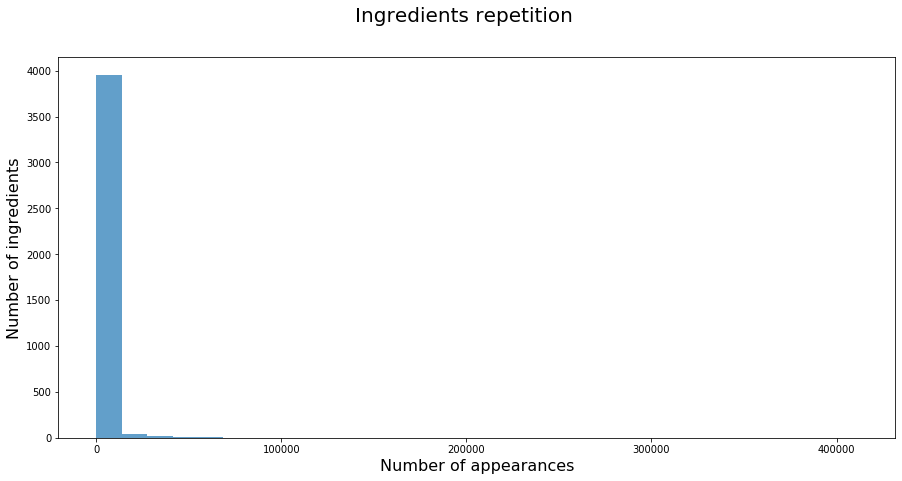

In [45]:
initial_time = time.time()
repetitionArray = []
mean = 0
for i in sorted_ingredients:
    repetitionArray.append(i[1])
    mean += i[1]
    
mean = mean/len(repetitionArray)
print(color.GREEN + "Number of total ingredients:", len(repetitionArray), color.END)
printMain("Average of appearances of the ingredients in recipes: " + str(round(mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of appearances', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray,bins=30, alpha=0.7)
plt.show(fig)

In the above plot we can not really see how the distribution of the ingredients' appearances is, but we can know that the big majority of ingredients (> 160000, nearly 100%) appear in a low amount of recipes. 

Let's do the same analysis but with ingredients with more than 2000 appearances.

Ingredients in more than 2000 recipes:
Number of total ingredients: 228 
Average of appearances of the ingredients in recpies: 25959.63 appearances.


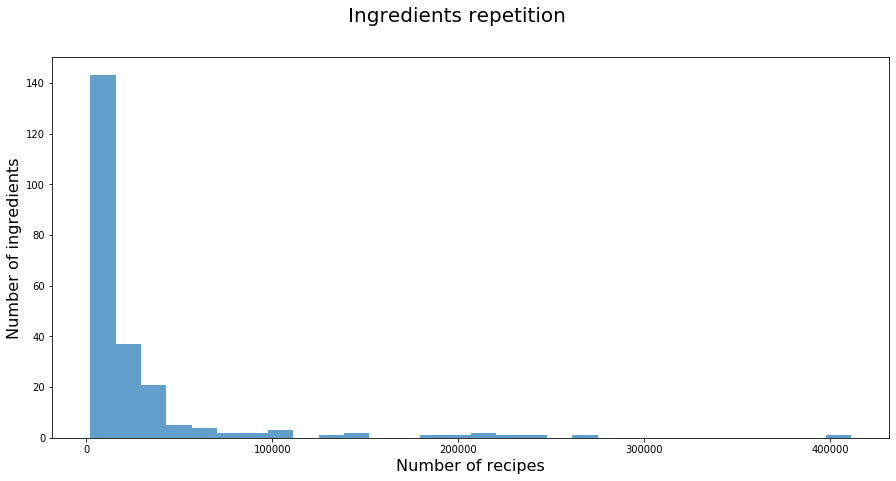

In [46]:
initial_time = time.time()
repetitionArray2 = []
mean2 = 0
for i in sorted_ingredients:
    if i[1] > 2000:
        mean += i[1]
        repetitionArray2.append(i[1])
        
mean = mean/len(repetitionArray2)
    
printMain("Ingredients in more than 2000 recipes:")
print(color.GREEN + "Number of total ingredients:", len(repetitionArray2), color.END)
printMain("Average of appearances of the ingredients in recpies: " + str(round(mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of recipes', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray2, bins=30, alpha=0.7)
plt.show(fig)

Eventhough we have zoomed to avoid the ingredients repeated a few number of times, we still see that there are much more ingredients in the lower repetition part of the histogram. This shows us that we base our diet on a small amount of ingredients, depending a lot on them. This leads us into the next question:

### Are there dominant ingredients?

The answer is yes, but let's see which ones they are, and how dominant they are. For this, let's print a bar plot of the top 10 ingredients appearance.

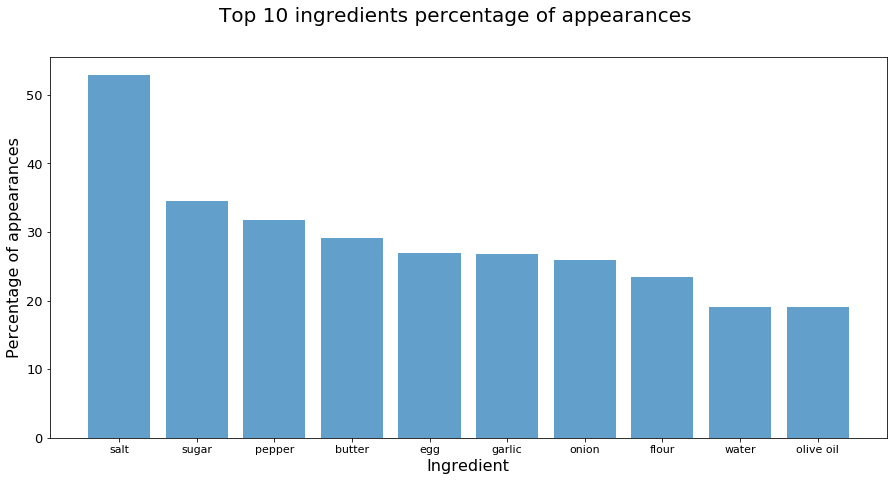

In [47]:
top10_ingredients = ingredients[:10]
top10_percentages = []

for i in repetitionArray2[:10]:
    top10_percentages.append(100*(i/len(df_ingredients)))
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(len(top10_percentages)), top10_percentages,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=top10_ingredients) 
fig.suptitle('Top 10 ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are ingredients really dominant in our diet nowadays. `Salt` and `Sugar` are present in close to 50% of the recipes. To see this with more perspective, let's get the average precentage of appearances:

In [48]:
printMain("Average percentage of appearances of ingredients in recipes: " + str(round(100*mean/len(df_ingredients), 2)) + "%")

Average percentage of appearances of ingredients in recipes: 3.33%


Once again we can see that there is a huge dominance of the top ingredients in the way we eat, confirming to us that the decision made of concentrating effort in the top 200 ingredients is, indeed, a good idea.

*Before the formatting of the ingredients' names with the aforementioned dictionary, the sugar was in the 3rd postion with a percentage of appearances of 30% (now it's above 40%). This is just an example of why the formatting was so important. In the case of the sugars, there were a lot of names for sugar, which is actually an important distinction for someone reading the recipe, but not for health, and, therefore, for us.*

### Are the most common ingredients healthy?

To answer this, let's get the unhealthy ingredients in the top 200 into a list and plot the top 10 (of the unhealthy) in a bar plot. 

In [49]:
df_common_ing = df_common_ing.sort_values(by=['Quantity'], ascending=False)
df_unhealthy_ingredients = df_common_ing[df_common_ing["Unhealthy"] == 1]
unhealthy_ingredients = list(df_unhealthy_ingredients.index)

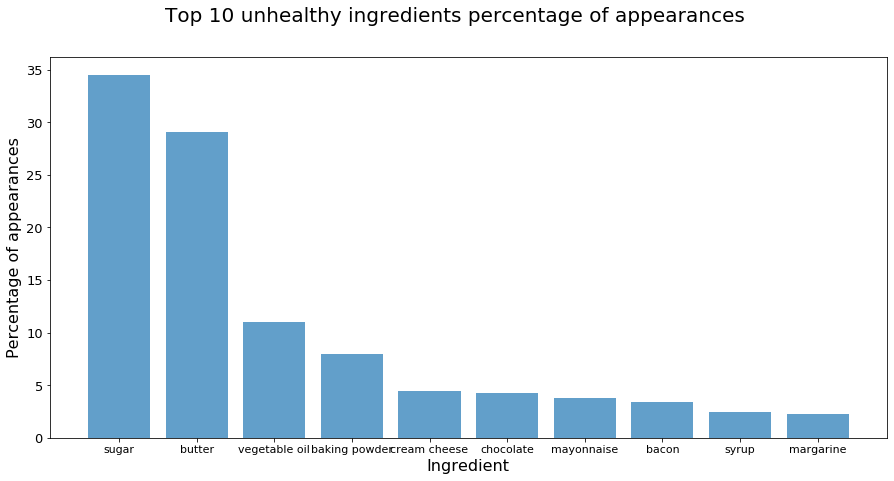

In [50]:
top10_percentages_unhealthy = []

for i in unhealthy_ingredients[:10]:
    top10_percentages_unhealthy.append(100*(dic_ingredients[i]/len(df_ingredients)))

fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(10), top10_percentages_unhealthy,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=unhealthy_ingredients[:10]) 
fig.suptitle('Top 10 unhealthy ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are some really dominant ingredients that are unhealthy (especially `sugar` and `butter`). This is going to make a lot of recipes unhealthy.

**Important note:** We understand that it is also important to the "healthiness" of a recipe the quantity of these "unhealthy" ingredients in the recipes. There are two reasons why we do not take this into account. Firstly, given, the way the quantities are defined in the dataset, it's impossible to automate the reading of the values, as they are directly extracted form the real recipes in web pages. Secondly, we believe we can still make the analysis we try to do, as we make the assumption that in the big majority of recipes where unhealthy ingredients are used, they are used in a high enough quantity to consider them unhealthy. We assume that it is not common to use these unhealthy ingredients in such a low quantity that the meal created can be cataloged as healthy.

Let's finally see how this really affects the recipes. Let's catalogue recipes as healthy or unhealthy, depending on whether they contain unhealthy ingredients. Then, let's see what the percentage of unhealthy recipes is.

In [51]:
printMain("Number of unhealthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 1])))
printMain("Number of healthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 0])))
printMain("Percentage of unhealthy recipes: " + str(100*round(len(df_ingredients[df_ingredients["Unhealthy"] == 1])/len(df_ingredients),2)) + "%")

Number of unhealthy recipes: 537524
Number of healthy recipes: 241564
Percentage of unhealthy recipes: 69.0%


We can see then that only ~30% of the recipes are healthy. This lead us into the next question.

### Is it easier or harder to eat healthy with the selected diets?

Let's mark the recipes as being approved for the different diets.

Now, let's plot the precentage of healthy recipes per type of diet.

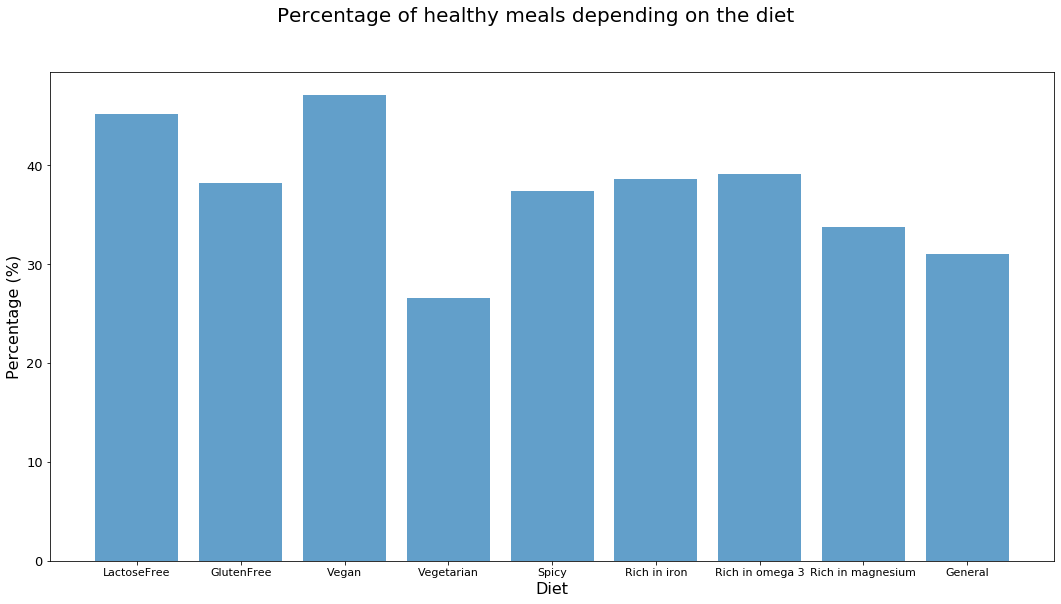

In [52]:
_data_healthyness = []
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["LactoseFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["LactoseFree"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["GlutenFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["GlutenFree"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Vegan"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Vegan"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Vegetarian"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Vegetarian"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Spicy"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Spicy"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["IronRich"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["IronRich"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Omega3Rich"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Omega3Rich"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["MagnesiumRich"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["MagnesiumRich"] == 1]))
_data_healthyness.append(100*len(df_ingredients[df_ingredients["Unhealthy"] == 0])/len(df_ingredients))
_keys_diets = ["LactoseFree", "GlutenFree", "Vegan", "Vegetarian", "Spicy", "Rich in iron", "Rich in omega 3", "Rich in magnesium", "General"]
fig, ax = plt.subplots(figsize=(18, 9))
plt.bar(np.arange(9), _data_healthyness,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys_diets) 
fig.suptitle('Percentage of healthy meals depending on the diet', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=16)
plt.xlabel('Diet', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are changes in the results. Apparently, for a vegan, it's easier to avoid unhealthy food than for a person with a regular diet. Obviously, this is a simple approach, as we are not taking other things into account. However, it will help us a lot in the analysis for the next milestone.

In [53]:
print(len(df_ingredients[(df_ingredients["Vegetarian"] == 1)]))
print(len(df_ingredients[(df_ingredients["Vegetarian"] == 1) & (df_ingredients["Unhealthy"] == 0)]))

496426
131706


In [54]:
dic_healthyness = {}
for i in range(len(_data_healthyness)):
    dic_healthyness[_keys_diets[i]] = _data_healthyness[i]
printMain("Percentaje of healthy recipes per diet: \n")
print(dic_healthyness)

Percentaje of healthy recipes per diet: 

{'LactoseFree': 45.18843043019576, 'GlutenFree': 38.23844776360141, 'Vegan': 47.11431669998563, 'Vegetarian': 26.53084246191779, 'Spicy': 37.36765658085855, 'Rich in iron': 38.567844884578115, 'Rich in omega 3': 39.0782541556908, 'Rich in magnesium': 33.73664971716801, 'General': 31.005996755180416}


### How much does salt presence varies from diet to diet.

Now we analyze how presence is salt in our diet depending on the diet.

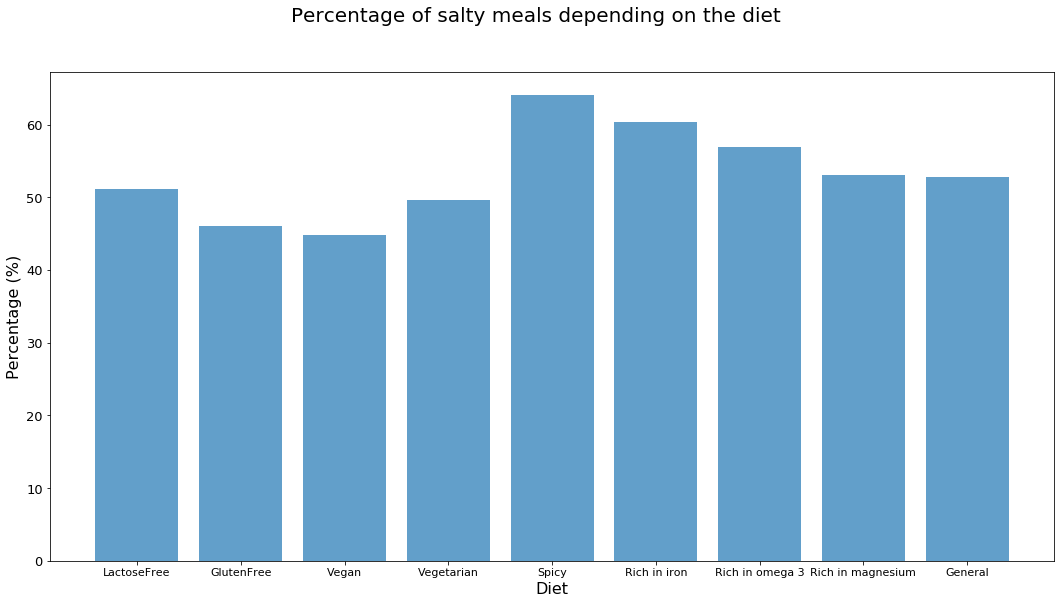

In [55]:
_data_salty = []
_data_salty.append(100*len(df_ingredients[(df_ingredients["LactoseFree"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["LactoseFree"] == 1]))
_data_salty.append(100*len(df_ingredients[(df_ingredients["GlutenFree"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["GlutenFree"] == 1]))
_data_salty.append(100*len(df_ingredients[(df_ingredients["Vegan"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["Vegan"] == 1]))
_data_salty.append(100*len(df_ingredients[(df_ingredients["Vegetarian"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["Vegetarian"] == 1]))
_data_salty.append(100*len(df_ingredients[(df_ingredients["Spicy"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["Spicy"] == 1]))
_data_salty.append(100*len(df_ingredients[(df_ingredients["IronRich"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["IronRich"] == 1]))
_data_salty.append(100*len(df_ingredients[(df_ingredients["Omega3Rich"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["Omega3Rich"] == 1]))
_data_salty.append(100*len(df_ingredients[(df_ingredients["MagnesiumRich"] == 1) & (df_ingredients["Salty"] == 1)])/len(df_ingredients[df_ingredients["MagnesiumRich"] == 1]))
_data_salty.append(100*len(df_ingredients[df_ingredients["Salty"] == 1])/len(df_ingredients))
fig, ax = plt.subplots(figsize=(18, 9))
plt.bar(np.arange(9), _data_salty,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys_diets) 
fig.suptitle('Percentage of salty meals depending on the diet', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=16)
plt.xlabel('Diet', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

### What is the distribution of the number of ingredients of recipes?

Let's add a new feature to the dataframe `df_ingredients`that has the amount of ingredients per recipe. Then, let's plot the distribution of values of this column.

In [56]:
initial_time = time.time()
df_ingredients['length'] = df_ingredients['ingredients'].apply(lambda x: len(x))
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("DataFrame with new column: ")
df_ingredients.head()

(Time: 0.38 seconds)
DataFrame with new column: 


,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
1,000033e39b,"[salt, pimentos, mayonnaise, celery, pasta, vi...",0,1,0,1,0,0,0,0,0,1,1,9
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper...",1,1,1,1,0,0,0,0,0,0,1,7
3,00003a70b1,"[water, butter, milk, french - fried onions, p...",0,1,0,1,1,0,0,0,0,1,0,7
5,0000631d90,"[salt, coconut, beef, pepper, mandarin, lemon,...",1,1,0,0,1,0,0,0,0,0,1,11
6,000075604a,"[chicken, pepper, tea]",1,1,0,0,0,0,0,0,0,0,0,3


(Time: 0.09 seconds)


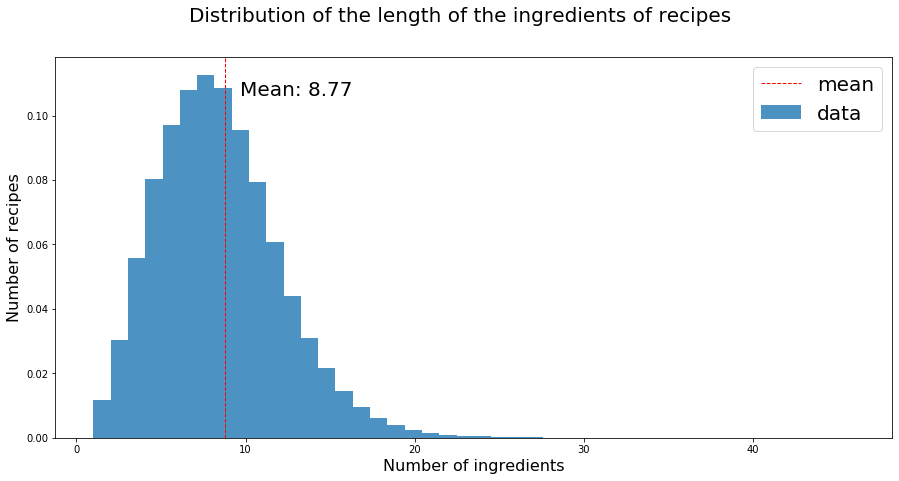

In [57]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients["length"]
_mean = df_ingredients["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recipes', fontsize=16)
plt.hist(_data, density=True, bins=44, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
min_ylim, max_ylim = plt.ylim()
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

*In this analysis, we found some outliers with a large amount of ingredients (>100). We discovered the problem was that some ingredients were repeated in the list. We actually solve this in the formating of ingredients previously done 

### Does the distribution change when taking into account the diets?

Let's see.

(Time: 0.23 seconds)


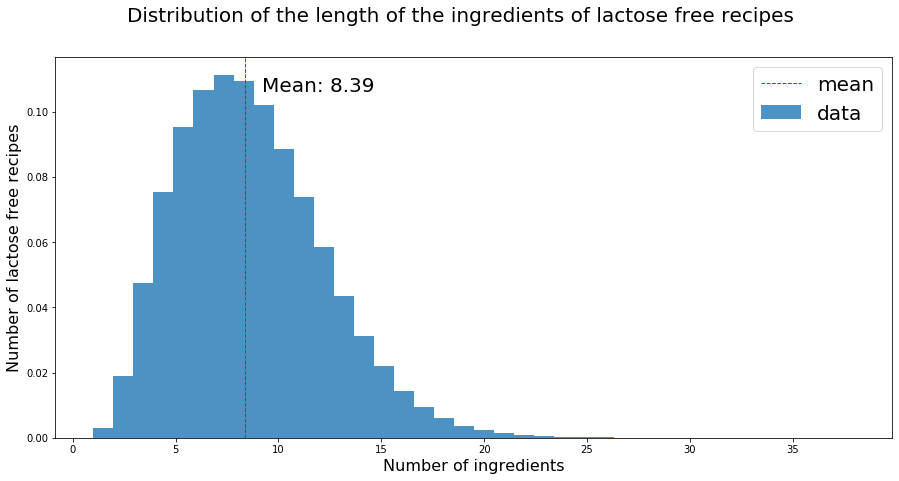

In [58]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of lactose free recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of lactose free recipes', fontsize=16)
plt.hist(_data, density=True, bins=38, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.28 seconds)


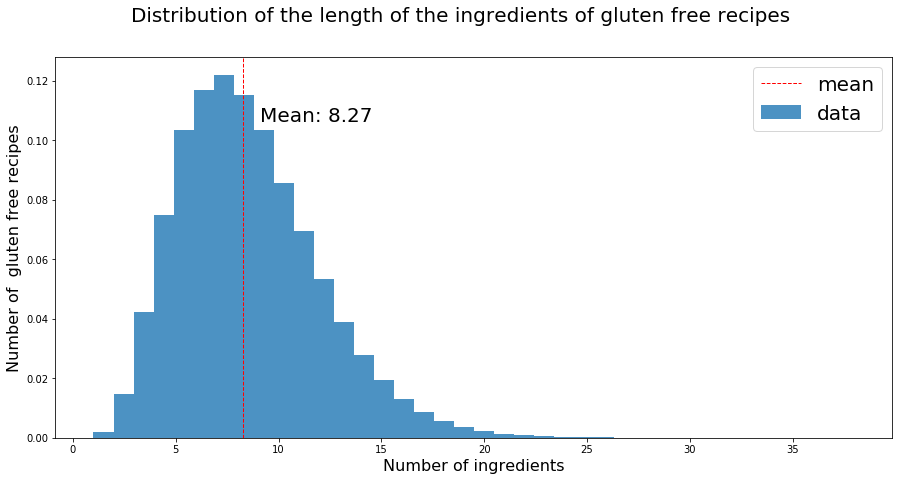

In [59]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of gluten free recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of  gluten free recipes', fontsize=16)
plt.hist(_data, density=True, bins=38, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

We see there are small changes in the distributions in the different diets, but they are not significant.

(Time: 0.14 seconds)


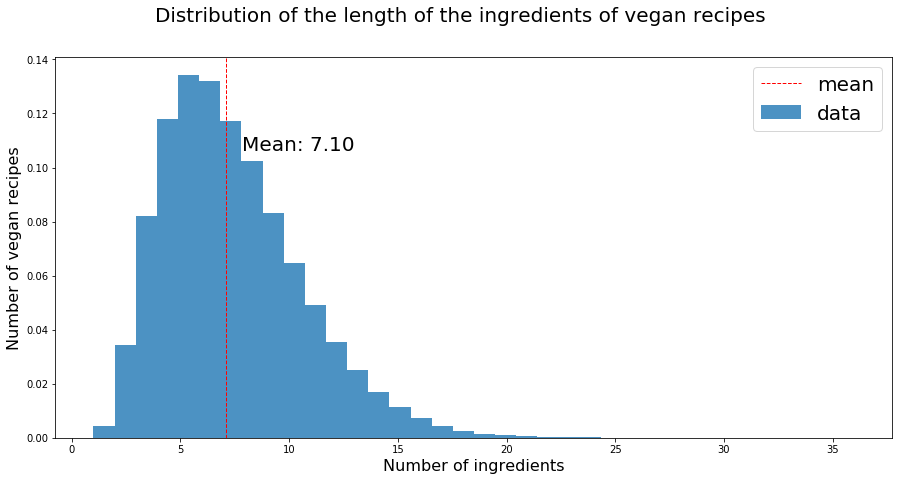

In [60]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Vegan"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Vegan"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of vegan recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of vegan recipes', fontsize=16)
plt.hist(_data, density=True, bins=36, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.26 seconds)


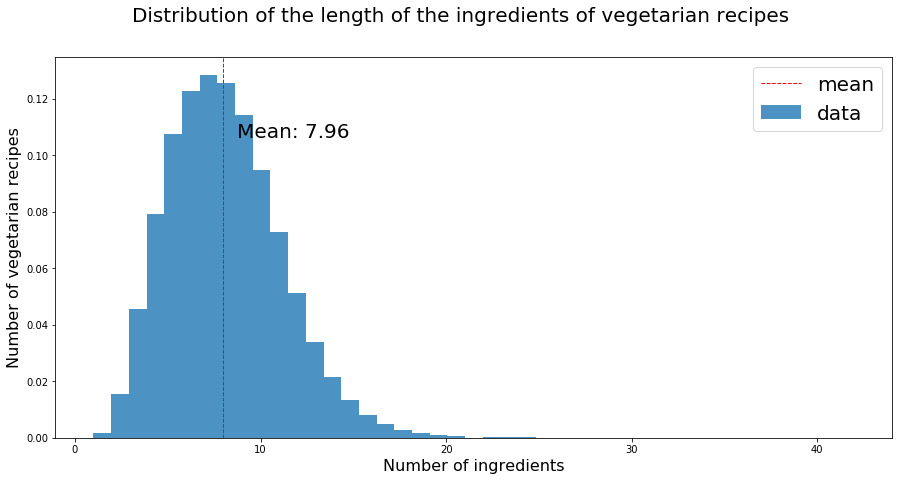

In [61]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Vegetarian"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Vegetarian"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of vegetarian recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of vegetarian recipes', fontsize=16)
plt.hist(_data, density=True, bins=43, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.21 seconds)


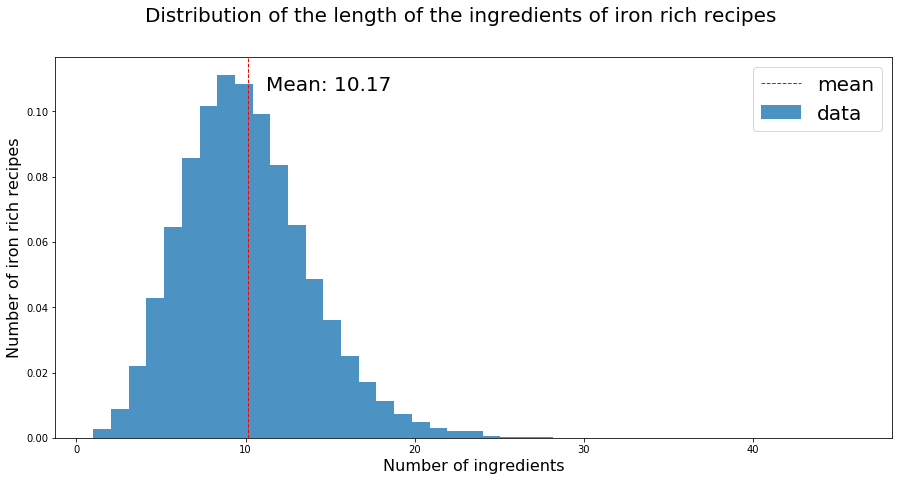

In [63]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["IronRich"] == 1]["length"]
_mean = df_ingredients[df_ingredients["IronRich"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of iron rich recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of iron rich recipes', fontsize=16)
plt.hist(_data, density=True, bins=43, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.12 seconds)


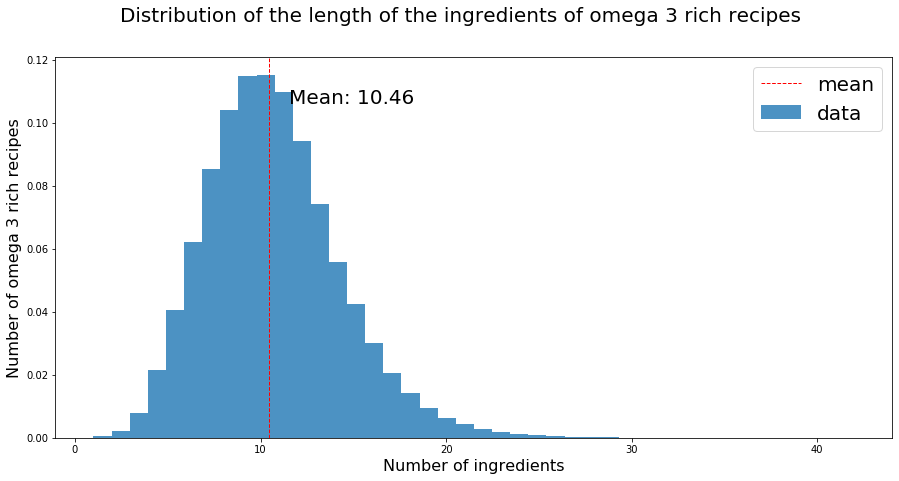

In [64]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Omega3Rich"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Omega3Rich"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of omega 3 rich recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of omega 3 rich recipes', fontsize=16)
plt.hist(_data, density=True, bins=42, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

In [65]:
len(df_common_ing)

265

In [66]:
df_ingredients.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
1,000033e39b,"[salt, pimentos, mayonnaise, celery, pasta, vi...",0,1,0,1,0,0,0,0,0,1,1,9
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper...",1,1,1,1,0,0,0,0,0,0,1,7
3,00003a70b1,"[water, butter, milk, french - fried onions, p...",0,1,0,1,1,0,0,0,0,1,0,7
5,0000631d90,"[salt, coconut, beef, pepper, mandarin, lemon,...",1,1,0,0,1,0,0,0,0,0,1,11
6,000075604a,"[chicken, pepper, tea]",1,1,0,0,0,0,0,0,0,0,0,3


(Time: 0.14 seconds)


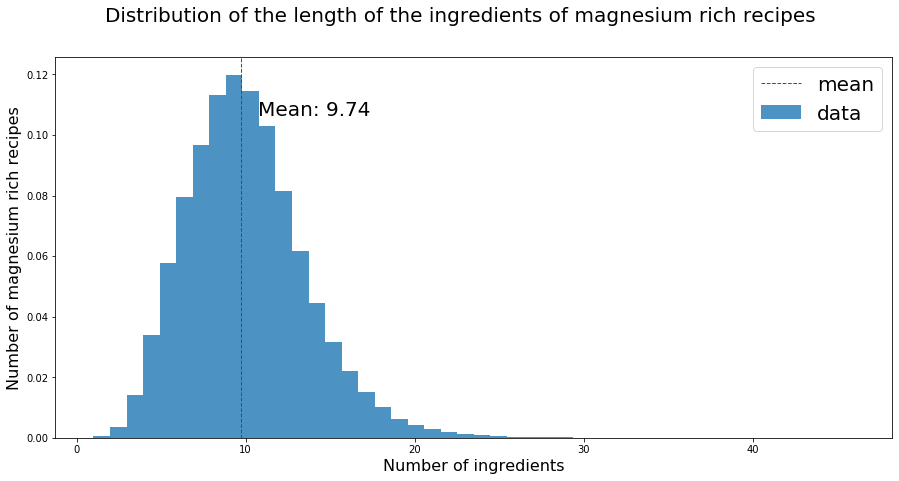

In [67]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["MagnesiumRich"] == 1]["length"]
_mean = df_ingredients[df_ingredients["MagnesiumRich"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of magnesium rich recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of magnesium rich recipes', fontsize=16)
plt.hist(_data, density=True, bins=46, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.13 seconds)


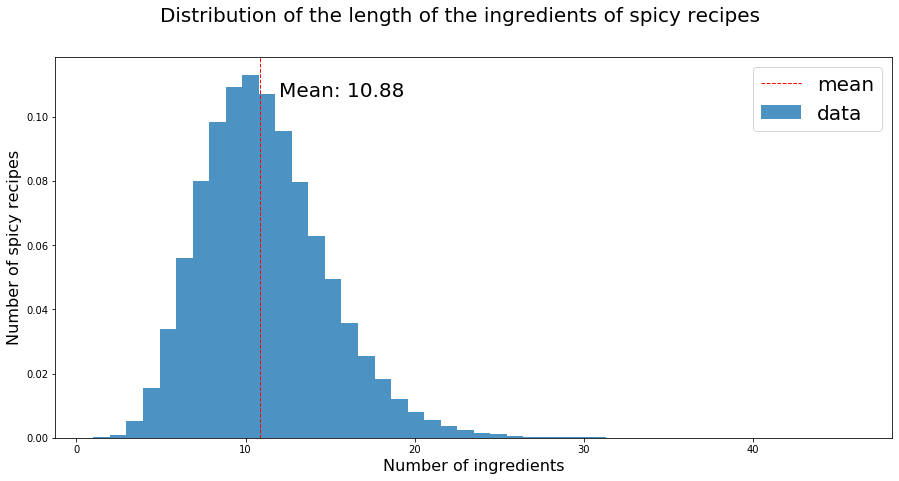

In [68]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Spicy"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Spicy"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of spicy recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of spicy recipes', fontsize=16)
plt.hist(_data, density=True, bins=46, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

## 4) Starting the core analysis

In this part we will start with the core analysis of the project. We will start only with a little part of it to ensure that the objectives of the second milestone have been achieved.

First we will create a correlation matrix in which each row and column are the top 200 ingredients and the cells are the percentage of shared recipes between the row ingredient and the column one.

In [69]:
# We want to find, for each ingredient, how often they occur together with another ingredient
initial_time = time.time()
occurrence_dict = {}
for ingredient_list in df_ingredients["ingredients"]:
    for ingredient in ingredient_list:
        if ingredient not in common_ing:
            continue
        if ingredient not in occurrence_dict.keys():
            occurrence_dict[ingredient] = {}
        for other_ingredient in ingredient_list:
            if other_ingredient not in common_ing:
                continue
            # Iterate through each other ingredient in the recipe
            if other_ingredient not in occurrence_dict[ingredient].keys():
                occurrence_dict[ingredient][other_ingredient] = 0
            occurrence_dict[ingredient][other_ingredient] = occurrence_dict[ingredient][other_ingredient] + 1
print("(Time:", round(time.time() - initial_time, 2), "seconds)")


(Time: 93.29 seconds)


In [216]:
# We calculate the ratio at which two ingredients appear in the same recipe, for each ingredient
initial_time = time.time()
ratios_dict_toExport = {}
ratios_dict = {}
for ingredient in occurrence_dict.keys():
    occurrences = occurrence_dict[ingredient]
    ratios = {}
    ratios_export = {}
    for other_ingredient in occurrences:
        if other_ingredient != ingredient:
            ratios_export[other_ingredient] = occurrences[other_ingredient] / occurrences[ingredient]
        ratios[other_ingredient] = occurrences[other_ingredient] / occurrences[ingredient]
    ratios_dict[ingredient] = ratios
    ratios_dict_toExport[ingredient] = ratios_export

print("(Time:", round(time.time() - initial_time, 2), "seconds)")

(Time: 0.06 seconds)


In [207]:
initial_time = time.time()
df_ratios = pd.DataFrame(ratios_dict)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
df_ratios

(Time: 0.06 seconds)


,salt,mayonnaise,celery,pasta,vinegar,bell pepper,cheese,dill,onion,tomatoes,...,corn flakes,egg substitute,graham crackers,lemongrass,marshmallows,anchovy,poppy seeds,lemon pepper,gin,mangoes
salt,1.000000,0.510647,0.659225,0.582868,0.656002,0.581756,0.540393,0.643704,0.661291,0.656727,...,0.474294,0.532635,0.176527,0.434343,0.179275,0.620240,0.612543,0.512242,0.066986,0.421053
mayonnaise,0.036732,1.000000,0.121932,0.040145,0.065706,0.051317,0.063566,0.195440,0.045655,0.040773,...,0.057434,0.009852,0.000954,0.012121,0.019307,0.090681,0.056175,0.097938,0.002051,NaN
celery,0.067776,0.174272,1.000000,0.082816,0.085120,0.155528,0.046034,0.128937,0.153600,0.112942,...,0.025012,0.017241,NaN,0.032323,0.011820,0.034068,0.031935,0.089562,0.008886,NaN
pasta,0.040384,0.038667,0.055810,1.000000,0.029464,0.075967,0.122552,0.041670,0.055312,0.094133,...,0.007874,0.011700,NaN,0.006734,0.004728,0.111723,0.014621,0.054768,0.000684,NaN
vinegar,0.116006,0.161529,0.146408,0.075201,1.000000,0.171463,0.065382,0.171449,0.134330,0.141779,...,0.016211,0.033867,0.005725,0.088215,0.009062,0.220441,0.198153,0.076675,0.010253,0.342105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oreo cookies,0.000486,NaN,NaN,NaN,0.000069,NaN,0.000065,NaN,NaN,NaN,...,NaN,0.000616,0.005248,NaN,0.020095,NaN,NaN,NaN,NaN,NaN
club soda,0.000350,0.000270,0.000047,NaN,0.000234,0.000195,0.000109,0.000421,0.000144,0.000055,...,NaN,NaN,0.000477,0.002020,NaN,0.000501,0.000770,NaN,0.092276,NaN
yellow cake mix,0.000331,0.000304,0.000024,NaN,0.000082,0.000016,0.000116,0.000070,NaN,NaN,...,0.000926,0.008005,0.000954,NaN,0.020883,NaN,0.015775,NaN,NaN,NaN
gin,0.000238,0.000101,0.000307,0.000035,0.000206,0.000146,0.000065,0.000702,0.000154,0.000177,...,NaN,NaN,NaN,0.000673,0.000394,NaN,NaN,NaN,1.000000,NaN


With this we can see that actually yes, with the data that we have we can do the analysis we want to do. If we print the same matrix as above but with only the top ten ingredients we will see the conclusion better. This is not useful for the future analysis, but it is for viewing the results.

In [72]:
df_ratios_dominant = df_ratios.drop(columns=common_ing[10:])
df_ratios_dominant = df_ratios_dominant.drop(common_ing[10:])

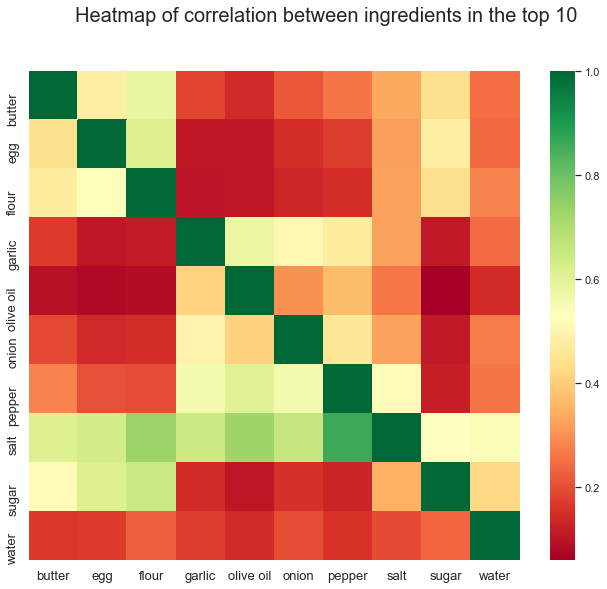

In [73]:
import seaborn as sns
sns.set()
plt.figure(figsize = (11,9))
df_ratios_dominant = df_ratios_dominant.sort_index(ascending=True)
df_ratios_dominant = df_ratios_dominant.sort_index(ascending=True, axis=1)
plt.suptitle('Heatmap of correlation between ingredients in the top 10', fontsize=20)
ax = sns.heatmap(df_ratios_dominant, cmap="RdYlGn")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylim(10, 0)
plt.show()

*The heat map is not symmetric because the ratio of, for example, egg in the recipes with butter is not the same as the ratio of butter in recipes with egg* 

---

# Conclusions and next steps

In this last plot we can actually see that the data is giving us what we expected! We can see nicely how ingredients correlate with each other in the recipes and from this we can do the analysis we want to do. Before ending the part of the notebook related to analysis of the recipe dataset, we resume the goals we want to achive in the future milestones, and also mention some flaws we see in our project (related to the recipes analysis).

### Goals

- Investigate in depth how the various dietary restrictions affect your general diet.
- Discover interesting relationships between different ingredients.
- Answer all the questions posed in the introduction.

### Flaws:

- We don't take into account the amount of each ingredient in the recipes. 
- We don't take into account how much a specific recipe is used.
- We focus on the amount of recipes that contain certain ingredients, but the fact that an ingredient is included in many recipes does not necessarily imply that we eat a high amount of that ingredient. The inverse is also true - even though an ingredient may appear in fewer recipes, these recipes may be so commonly used, and the quantity of the ingredients used so high, that this results in a high consumption of this ingredient in the population. 

## LactoseFree

Let's find tendencies on it. 

In [196]:
ingredient_list = df_common_ing.index.tolist()

In [198]:
dic_ingredients_per = {}
for key in ingredient_list:
    dic_ingredients_per[key] = (dic_ingredients[key]/len(df_ingredients))*100

In [74]:
df_lactoseFree = df_ingredients[df_ingredients["LactoseFree"] == 1]
df_lactoseFree.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper...",1,1,1,1,0,0,0,0,0,0,1,7
5,0000631d90,"[salt, coconut, beef, pepper, mandarin, lemon,...",1,1,0,0,1,0,0,0,0,0,1,11
6,000075604a,"[chicken, pepper, tea]",1,1,0,0,0,0,0,0,0,0,0,3
12,0000c79afb,"[water, orange, white cranberry juice, brandy,...",1,1,1,1,0,0,0,0,1,1,0,8
14,00010379bf,"[water, sesame seeds, flour, sugar, baking pow...",1,0,1,1,1,0,1,0,0,1,0,7


In [75]:
# Getting the lactoseFree ingredients
ingredients_lactoseFree = df_common_ing[df_common_ing["LactoseFree"] == 1].index.tolist()
printMain("Ingredients abailable for lactose intolerance people: " + str(len(ingredients_lactoseFree)))

Ingredients abailable for lactose intolerance people: 249


In [76]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_lactoseFree = {}
 
for row in df_lactoseFree.itertuples():
    for ing in row[2]:
        if ing in ingredients_lactoseFree:
            if ing in dic_ingredients_lactoseFree:
                dic_ingredients_lactoseFree[ing] += 1
            else:
                dic_ingredients_lactoseFree[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_lactoseFree)))

(Time: 4.48 seconds)
Number of different ingredients: 249


In [77]:
len(df_ingredients)

779088

In [78]:
len(df_lactoseFree)

341240

{'salt': 52.792239130881235,
 'pimentos': 0.044539256155915634,
 'mayonnaise': 3.797517096913314,
 'celery': 5.427628201178814,
 'pasta': 3.6577382786026744,
 'vinegar': 9.335659129649025,
 'bell pepper': 7.89384511120695,
 'cheese': 17.739074404945267,
 'dill': 1.8297034481342285,
 'onion': 25.87653769535662,
 'tomatoes': 11.635142628303862,
 'olive oil': 19.051121311071405,
 'basil': 4.7912430944899675,
 'cucumber': 1.7419084878730002,
 'water': 19.055870453658635,
 'butter': 29.072839011767606,
 'milk': 14.144871952847431,
 'french - fried onions': 0.0894635779270121,
 'potatoes': 5.098140389789087,
 'corn': 1.5661902121454832,
 'coconut': 1.3872630562914587,
 'beef': 5.990979196188364,
 'pepper': 31.675754215184938,
 'mandarin': 0.2025445135851149,
 'lemon': 12.936279341999876,
 'pineapple': 2.219133140287105,
 'cornstarch': 3.265741482348592,
 'cashew nuts': 0.0584016183024254,
 'garlic': 26.720986589448177,
 'soy sauce': 4.516306245250858,
 'chicken': 10.426164951841127,
 'tea': 

In [80]:
dic_ingredients_lactoseFree_per = {}
ingredients_lactoseFree_per = []
ingredients_lactoseFree_per_general = []
keys_lactoseFree = []

for key in ingredients_lactoseFree:
    
    ingredients_lactoseFree_per_general.append(dic_ingredients_per[key])
    keys_lactoseFree.append(key)
    if key in dic_ingredients_lactoseFree:
        ingredients_lactoseFree_per.append((dic_ingredients_lactoseFree[key]/len(df_lactoseFree))*100)
        dic_ingredients_lactoseFree_per[key] = (dic_ingredients_lactoseFree[key]/len(df_lactoseFree))*100
    else: 
        ingredients_lactoseFree_per.append(0)
        dic_ingredients_lactoseFree_per[key] = 0

In [81]:
dic_more_per_lactoseFree = {}
dic_less_per_lactoseFree = {}
dic_double_lactoseFree = {}
dic_half_lactoseFree = {}
mean_change_lactoseFree = 0
absolute_change_lactoseFree = 0
dic_changes_lactoseFree = {}
mean_total = 0

for key in dic_ingredients_lactoseFree_per:
    change = dic_ingredients_lactoseFree_per[key] - dic_ingredients_per[key]
    dic_changes_lactoseFree[key] = change
    mean_change_lactoseFree += change
    absolute_change_lactoseFree += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_lactoseFree_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]
    elif dic_ingredients_lactoseFree_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]
        
    if dic_ingredients_lactoseFree_per[key] > 2*dic_ingredients_per[key]:
        dic_double_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]
    elif dic_ingredients_lactoseFree_per[key]*2 < dic_ingredients_per[key]:
        dic_half_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]

mean_change_lactoseFree = mean_change_lactoseFree/len(dic_ingredients_lactoseFree_per)
absolute_change_lactoseFree = absolute_change_lactoseFree/len(dic_ingredients_lactoseFree_per)
mean_total = mean_total/len(dic_ingredients_lactoseFree_per)

print(dic_less_per_lactoseFree)
print()
print(dic_more_per_lactoseFree)
print()
print(dic_double_lactoseFree)
print()
print(dic_half_lactoseFree)

{'sugar': [34.45451604953484, 28.52391278865315], 'egg': [26.97975068284969, 14.181514476614698], 'flour': [23.47064773170682, 11.81924745047474], 'vanilla': [12.97517096913314, 5.407337943969054], 'baking powder': [7.974452179984803, 3.5054507091782905], 'baking soda': [6.496313638510669, 3.652268198335482], 'chocolate': [4.234438214938492, 1.9118508967295746]}

{'pepper': [31.675754215184938, 34.241589497128125], 'garlic': [26.720986589448177, 33.793224709881606], 'onion': [25.87653769535662, 30.63181338647286], 'water': [19.055870453658635, 23.909858164341813], 'olive oil': [19.051121311071405, 24.51002227171492], 'tomatoes': [11.635142628303862, 14.790470050404409], 'vegetable oil': [11.030589612469965, 15.70478255773063], 'vinegar': [9.335659129649025, 15.338471457039034], 'bell pepper': [7.89384511120695, 10.395909037627476], 'carrot': [6.0914813217505595, 8.447720079709296], 'ginger': [5.686007228965149, 9.146934708709413], 'soy sauce': [4.516306245250858, 9.147813855351073], 'c

In [82]:
printMain("Mean change: " + str(mean_change_lactoseFree))
printMain("Mean change in absolute value: " + str(absolute_change_lactoseFree))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: 0.1496181255192509
Mean change in absolute value: 0.7450213842000212
Mean total: 2.7300296414953564



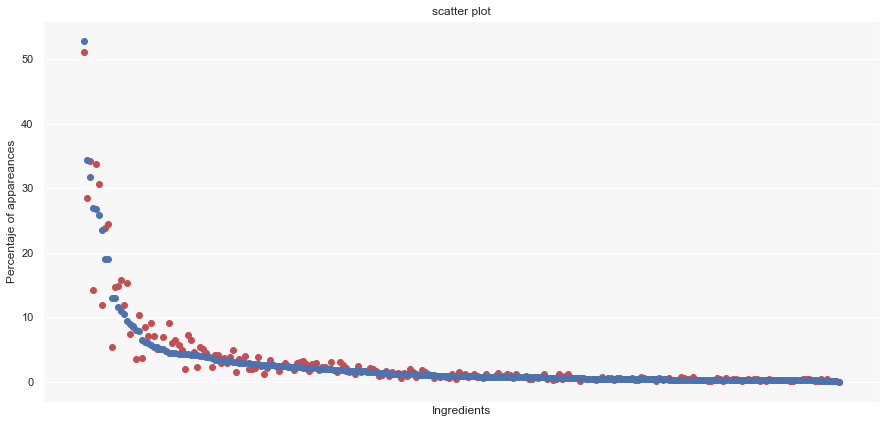

In [83]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(keys_lactoseFree))), ingredients_lactoseFree_per, color='r')
ax.scatter(list(range(len(keys_lactoseFree))), ingredients_lactoseFree_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('scatter plot')
ax.set_facecolor((0.97, 0.97, 0.97))
plt.xticks([])
plt.show()

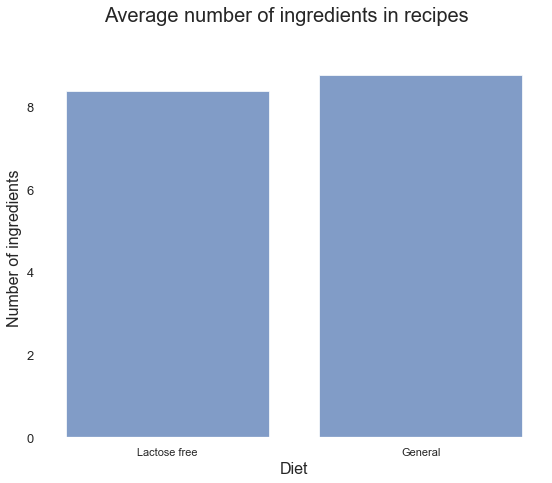

In [84]:
mean_lactoseFree = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_lactoseFree, mean_general]
_keys = ["Lactose free", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

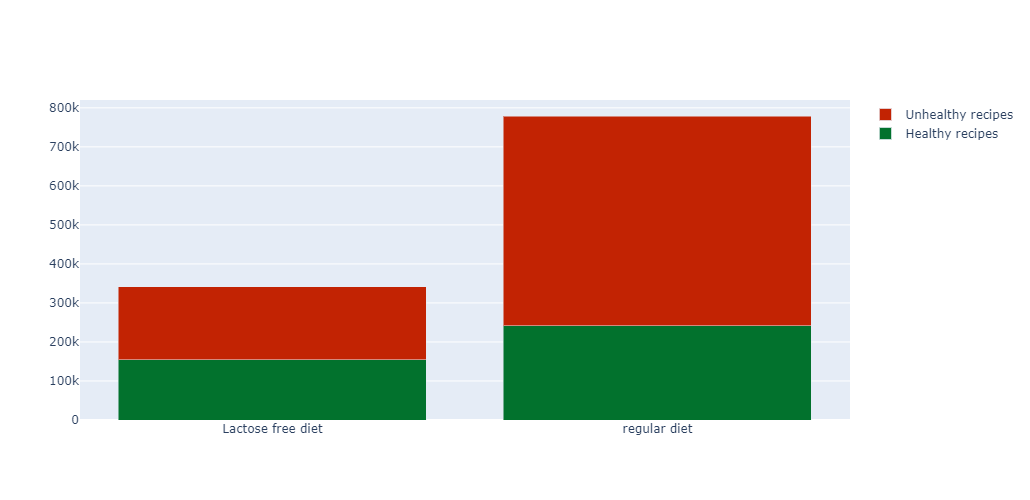

In [109]:
import plotly.graph_objects as go
diets=['Lactose free diet', 'regular diet']
numberOfHealthyLactoseFreeRecipes = len(df_ingredients[(df_ingredients["LactoseFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfLactoseFreeRecipes = len(df_ingredients[df_ingredients["LactoseFree"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Lactose free:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyLactoseFreeRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfLactoseFreeRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyLactoseFreeRecipes*100/numberOfLactoseFreeRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Lactose free:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfLactoseFreeRecipes - numberOfHealthyLactoseFreeRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfLactoseFreeRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfLactoseFreeRecipes - numberOfHealthyLactoseFreeRecipes)*100/numberOfLactoseFreeRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyLactoseFreeRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= 'rgba(2, 114, 45, 1)'
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfLactoseFreeRecipes - numberOfHealthyLactoseFreeRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= 'rgba(194, 35, 3, 1)'
    )
])
# Change the bar mode
fig.update_layout(
    barmode='stack',
    width=500,
    height=500,
    paper_bgcolor="White"
)

fig.show()

In [110]:
import plotly.offline as ff
ff.plot(fig, filename='lactoseFreeHealthyness.html')

'lactoseFreeHealthyness.html'

## Gluten free

In [111]:
df_glutenFree = df_ingredients[df_ingredients["GlutenFree"] == 1]
df_glutenFree.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
1,000033e39b,"[salt, pimentos, mayonnaise, celery, pasta, vi...",0,1,0,1,0,0,0,0,0,1,1,9
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper...",1,1,1,1,0,0,0,0,0,0,1,7
3,00003a70b1,"[water, butter, milk, french - fried onions, p...",0,1,0,1,1,0,0,0,0,1,0,7
5,0000631d90,"[salt, coconut, beef, pepper, mandarin, lemon,...",1,1,0,0,1,0,0,0,0,0,1,11
6,000075604a,"[chicken, pepper, tea]",1,1,0,0,0,0,0,0,0,0,0,3


In [112]:
# Getting the lactoseFree ingredients
ingredients_glutenFree = df_common_ing[df_common_ing["GlutenFree"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_glutenFree)))

Ingredients abailable for gluten intolerance people: 256


In [113]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_glutenFree = {}
 
for row in df_glutenFree.itertuples():
    for ing in row[2]:
        if ing in ingredients_glutenFree:
            if ing in dic_ingredients_glutenFree:
                dic_ingredients_glutenFree[ing] += 1
            else:
                dic_ingredients_glutenFree[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_glutenFree)))

(Time: 7.77 seconds)
Number of different ingredients: 256


In [114]:
len(df_ingredients)

779088

In [115]:
len(df_glutenFree)

545587

In [116]:
dic_ingredients_glutenFree_per = {}
ingredients_glutenFree_per = []
ingredients_glutenFree_per_general = []
keys_glutenFree = []

for key in ingredients_glutenFree:
    
    ingredients_glutenFree_per_general.append(dic_ingredients_per[key])
    keys_glutenFree.append(key)
    if key in dic_ingredients_glutenFree:
        ingredients_glutenFree_per.append((dic_ingredients_glutenFree[key]/len(df_glutenFree))*100)
        dic_ingredients_glutenFree_per[key] = (dic_ingredients_glutenFree[key]/len(df_glutenFree))*100
    else: 
        ingredients_glutenFree_per.append(0)
        dic_ingredients_glutenFree_per[key] = 0

In [117]:
dic_more_per_glutenFree = {}
dic_less_per_glutenFree = {}
dic_double_glutenFree = {}
dic_half_glutenFree = {}
mean_change_glutenFree = 0
absolute_change_glutenFree = 0
dic_changes_glutenFree = {}
mean_total = 0

for key in dic_ingredients_glutenFree_per:
    change = dic_ingredients_glutenFree_per[key] - dic_ingredients_per[key]
    dic_changes_glutenFree[key] = change
    mean_change_glutenFree += change
    absolute_change_glutenFree += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_glutenFree_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]
    elif dic_ingredients_glutenFree_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]
        
    if dic_ingredients_glutenFree_per[key] > 2*dic_ingredients_per[key]:
        dic_double_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]
    elif dic_ingredients_glutenFree_per[key]*2 < dic_ingredients_per[key]:
        dic_half_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]

mean_change_glutenFree = mean_change_glutenFree/len(dic_ingredients_glutenFree_per)
absolute_change_glutenFree = absolute_change_glutenFree/len(dic_ingredients_glutenFree_per)
mean_total = mean_total/len(dic_ingredients_glutenFree_per)

print(dic_less_per_glutenFree)
print()
print(dic_more_per_glutenFree)
print()
print(dic_double_glutenFree)
print()
print(dic_half_glutenFree)

{'salt': [52.792239130881235, 46.03702067681231], 'sugar': [34.45451604953484, 25.671066209422143], 'butter': [29.072839011767606, 19.233412819586977], 'egg': [26.97975068284969, 14.206533513445152], 'milk': [14.144871952847431, 8.816192467929037], 'vanilla': [12.97517096913314, 6.927950995899828], 'cinnamon': [8.955085946645308, 5.940757386081414], 'baking soda': [6.496313638510669, 0.6501254612005052]}

{'pepper': [31.675754215184938, 34.91083915122611], 'garlic': [26.720986589448177, 31.369149191604638], 'onion': [25.87653769535662, 29.129909620280543], 'olive oil': [19.051121311071405, 22.155403262907658], 'tomatoes': [11.635142628303862, 13.854435681202082], 'vinegar': [9.335659129649025, 11.659918583104071]}

{}

{'baking soda': [6.496313638510669, 0.6501254612005052], 'oat': [2.1373708746637092, 1.0091882687820641], 'yeast': [2.020695993263919, 0.32313819794093335], 'buttermilk': [1.8629474462448403, 0.49524640433148154], 'shortening': [1.8273930544431438, 0.29949393955501136], 

In [118]:
printMain("Mean change: " + str(mean_change_glutenFree))
printMain("Mean change in absolute value: " + str(absolute_change_glutenFree))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: -0.0874427401092845
Mean change in absolute value: 0.5519952116350142
Mean total: 2.84323174580407



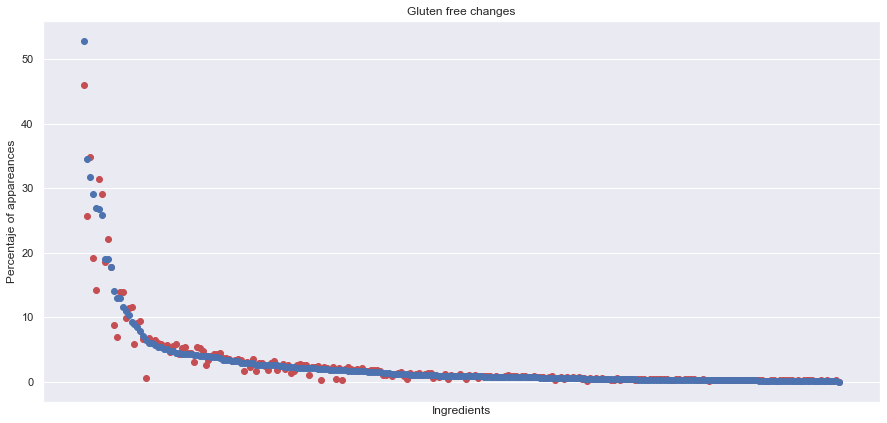

In [119]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_glutenFree_per))), ingredients_glutenFree_per, color='r')
ax.scatter(list(range(len(ingredients_glutenFree_per))), ingredients_glutenFree_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('Gluten free changes')
plt.xticks([])
plt.show()

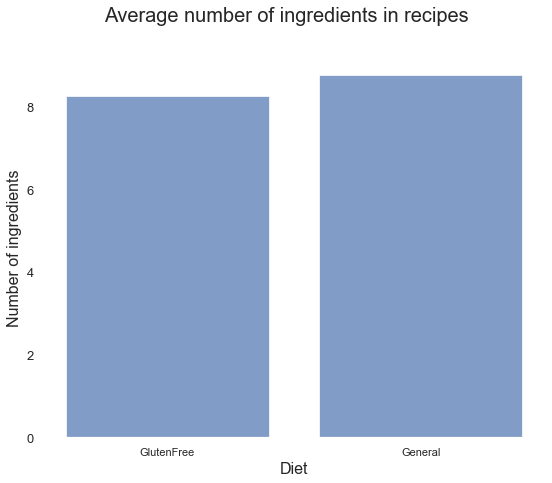

In [120]:
mean_glutenFree = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_glutenFree, mean_general]
_keys = ["GlutenFree", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

## Vegan

In [121]:
df_vegan = df_ingredients[df_ingredients["Vegan"] == 1]
df_vegan.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper...",1,1,1,1,0,0,0,0,0,0,1,7
12,0000c79afb,"[water, orange, white cranberry juice, brandy,...",1,1,1,1,0,0,0,0,1,1,0,8
14,00010379bf,"[water, sesame seeds, flour, sugar, baking pow...",1,0,1,1,1,0,1,0,0,1,0,7
31,0001cba765,"[orange, tequila, triple sec, coarse sugar, cr...",1,1,1,1,0,0,0,0,1,1,0,6
36,0002491373,"[dried currants, onion, yellow pepper, pepper,...",1,1,1,1,1,0,0,1,0,1,0,14


In [122]:
# Getting the lactoseFree ingredients
ingredients_vegan = df_common_ing[df_common_ing["Vegan"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_vegan)))

Ingredients abailable for gluten intolerance people: 224


In [123]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_vegan = {}
 
for row in df_vegan.itertuples():
    for ing in row[2]:
        if ing in ingredients_vegan:
            if ing in dic_ingredients_vegan:
                dic_ingredients_vegan[ing] += 1
            else:
                dic_ingredients_vegan[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_vegan)))

(Time: 1.76 seconds)
Number of different ingredients: 224


In [124]:
len(df_ingredients)

779088

In [125]:
len(df_glutenFree)

545587

In [126]:
dic_ingredients_vegan_per = {}
ingredients_vegan_per = []
ingredients_vegan_per_general = []
keys_vegan = []

for key in ingredients_vegan:
    
    ingredients_vegan_per_general.append(dic_ingredients_per[key])
    keys_vegan.append(key)
    if key in dic_ingredients_vegan:
        ingredients_vegan_per.append((dic_ingredients_vegan[key]/len(df_vegan))*100)
        dic_ingredients_vegan_per[key] = (dic_ingredients_vegan[key]/len(df_vegan))*100
    else: 
        ingredients_vegan_per.append(0)
        dic_ingredients_vegan_per[key] = 0

In [127]:
dic_more_per_vegan = {}
dic_less_per_vegan = {}
dic_double_vegan = {}
dic_half_vegan = {}
mean_change_vegan = 0
absolute_change_vegan = 0
dic_changes_vegan = {}
mean_total = 0

for key in dic_ingredients_vegan_per:
    change = dic_ingredients_vegan_per[key] - dic_ingredients_per[key]
    dic_changes_vegan[key] = change
    mean_change_vegan += change
    absolute_change_vegan += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_vegan_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]
    elif dic_ingredients_vegan_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]
        
    if dic_ingredients_vegan_per[key] > 2*dic_ingredients_per[key]:
        dic_double_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]
    elif dic_ingredients_vegan_per[key]*2 < dic_ingredients_per[key]:
        dic_half_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]

mean_change_vegan = mean_change_vegan/len(dic_ingredients_vegan_per)
absolute_change_vegan = absolute_change_vegan/len(dic_ingredients_vegan_per)
mean_total = mean_total/len(dic_ingredients_vegan_per)

print(dic_less_per_vegan)
print()
print(dic_more_per_vegan)
print()
print(dic_double_vegan)
print()
print(dic_half_vegan)

{'salt': [52.792239130881235, 44.87475990749088], 'sugar': [34.45451604953484, 31.462898357571245], 'pepper': [31.675754215184938, 25.42302013510512], 'onion': [25.87653769535662, 23.340258450603006], 'flour': [23.47064773170682, 7.619588935491879], 'vanilla': [12.97517096913314, 4.792050488024774], 'baking powder': [7.974452179984803, 2.0102439470555185], 'baking soda': [6.496313638510669, 1.942299400258712], 'chocolate': [4.234438214938492, 2.1899050082970746], 'pasta': [3.6577382786026744, 1.5581513856767668], 'breadcrumbs': [2.4671153964635573, 0.4520925613787517]}

{'water': [19.055870453658635, 27.82002534854246], 'olive oil': [19.051121311071405, 23.757072112683417], 'lemon': [12.936279341999876, 15.21892516953471], 'vinegar': [9.335659129649025, 16.10873740739289], 'ginger': [5.686007228965149, 7.85020840683104], 'cumin': [4.371264863532746, 6.494584035644754], 'lime': [4.225838416199454, 9.062757241974051], 'cilantro': [4.08914012281026, 6.8754654854768535], 'orange': [3.90572

In [128]:
printMain("Mean change: " + str(mean_change_vegan))
printMain("Mean change in absolute value: " + str(absolute_change_vegan))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: -0.06547035618740317
Mean change in absolute value: 0.8069046979189265
Mean total: 2.6641188616873643



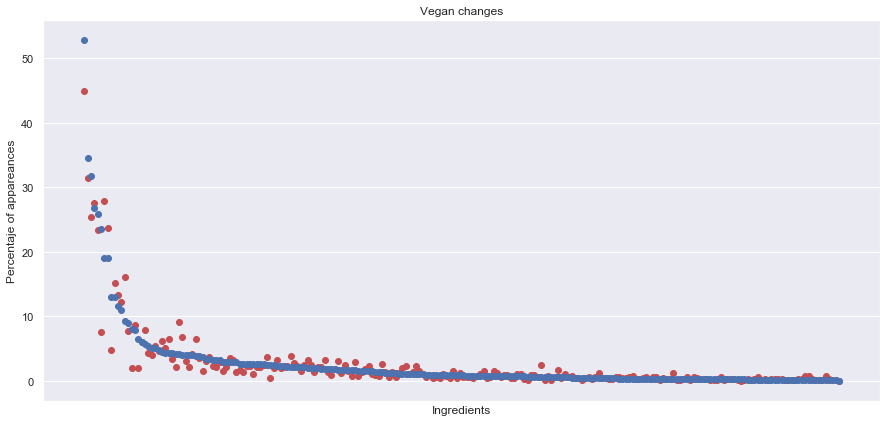

In [129]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_vegan_per))), ingredients_vegan_per, color='r')
ax.scatter(list(range(len(ingredients_vegan_per))), ingredients_vegan_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('Vegan changes')
plt.xticks([])
plt.show()

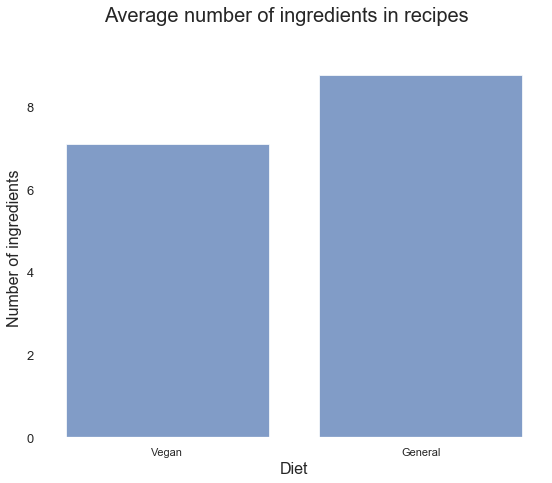

In [130]:
mean_vegan = df_ingredients[df_ingredients["Vegan"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_vegan, mean_general]
_keys = ["Vegan", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

## Vegetarian

In [131]:
df_vegetarian = df_ingredients[df_ingredients["Vegetarian"] == 1]
df_vegetarian.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
1,000033e39b,"[salt, pimentos, mayonnaise, celery, pasta, vi...",0,1,0,1,0,0,0,0,0,1,1,9
2,000035f7ed,"[salt, onion, tomatoes, olive oil, bell pepper...",1,1,1,1,0,0,0,0,0,0,1,7
3,00003a70b1,"[water, butter, milk, french - fried onions, p...",0,1,0,1,1,0,0,0,0,1,0,7
7,00007bfd16,"[water, white cake mix, rhubarb, gelatin, butt...",0,1,0,1,0,0,0,0,0,1,0,6
8,000095fc1d,"[strawberries, yogurt, low - fat granola]",0,1,0,1,0,0,0,0,0,0,0,3


In [132]:
# Getting the lactoseFree ingredients
ingredients_vegetarian = df_common_ing[df_common_ing["Vegetarian"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_vegetarian)))

Ingredients abailable for gluten intolerance people: 244


In [133]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_vegetarian = {}
 
for row in df_vegetarian.itertuples():
    for ing in row[2]:
        if ing in ingredients_vegetarian:
            if ing in dic_ingredients_vegetarian:
                dic_ingredients_vegetarian[ing] += 1
            else:
                dic_ingredients_vegetarian[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_vegetarian)))

(Time: 5.56 seconds)
Number of different ingredients: 244


In [134]:
len(df_ingredients)

779088

In [135]:
len(df_glutenFree)

545587

In [136]:
dic_ingredients_vegetarian_per = {}
ingredients_vegetarian_per = []
ingredients_vegetarian_per_general = []
keys_vegetarian = []

for key in ingredients_vegetarian:
    
    ingredients_vegetarian_per_general.append(dic_ingredients_per[key])
    keys_vegetarian.append(key)
    if key in dic_ingredients_vegetarian:
        ingredients_vegetarian_per.append((dic_ingredients_vegetarian[key]/len(df_vegetarian))*100)
        dic_ingredients_vegetarian_per[key] = (dic_ingredients_vegetarian[key]/len(df_vegetarian))*100
    else: 
        ingredients_vegetarian_per.append(0)
        dic_ingredients_vegetarian_per[key] = 0

In [137]:
dic_more_per_vegetarian = {}
dic_less_per_vegetarian = {}
dic_double_vegetarian = {}
dic_half_vegetarian = {}
mean_change_vegetarian = 0
absolute_change_vegetarian = 0
dic_changes_vegetarian = {}
mean_total = 0

for key in dic_ingredients_vegetarian_per:
    change = dic_ingredients_vegetarian_per[key] - dic_ingredients_per[key]
    dic_changes_vegetarian[key] = change
    mean_change_vegetarian += change
    absolute_change_vegetarian += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_vegetarian_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]
    elif dic_ingredients_vegetarian_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]
        
    if dic_ingredients_vegetarian_per[key] > 2*dic_ingredients_per[key]:
        dic_double_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]
    elif dic_ingredients_vegetarian_per[key]*2 < dic_ingredients_per[key]:
        dic_half_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]

mean_change_vegetarian = mean_change_vegetarian/len(dic_ingredients_vegetarian_per)
absolute_change_vegetarian = absolute_change_vegetarian/len(dic_ingredients_vegetarian_per)
mean_total = mean_total/len(dic_ingredients_vegetarian_per)

print(dic_less_per_vegetarian)
print()
print(dic_more_per_vegetarian)
print()
print(dic_double_vegetarian)
print()
print(dic_half_vegetarian)

{'salt': [52.792239130881235, 49.618674283780464], 'pepper': [31.675754215184938, 20.045485127692746], 'garlic': [26.720986589448177, 16.588373695173097], 'onion': [25.87653769535662, 14.840479749247622], 'olive oil': [19.051121311071405, 14.15236107697824], 'cheese': [17.739074404945267, 12.938887165458699], 'tomatoes': [11.635142628303862, 7.653507269965715], 'bell pepper': [7.89384511120695, 4.975565341057882], 'carrot': [6.0914813217505595, 3.815070121226527], 'celery': [5.427628201178814, 2.481538033866075], 'thyme': [4.303878380876101, 2.179579635232643]}

{'sugar': [34.45451604953484, 46.49957899062499], 'butter': [29.072839011767606, 32.72874506975864], 'egg': [26.97975068284969, 33.448086925342345], 'flour': [23.47064773170682, 29.121762357330194], 'milk': [14.144871952847431, 16.908461684118077], 'vanilla': [12.97517096913314, 20.276335244326447], 'cinnamon': [8.955085946645308, 12.613561739312606], 'baking powder': [7.974452179984803, 11.922220028765617], 'baking soda': [6.4

In [138]:
printMain("Mean change: " + str(mean_change_vegetarian))
printMain("Mean change in absolute value: " + str(absolute_change_vegetarian))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: -0.12684562939231195
Mean change in absolute value: 0.8348561242256833
Mean total: 2.9454594746004843



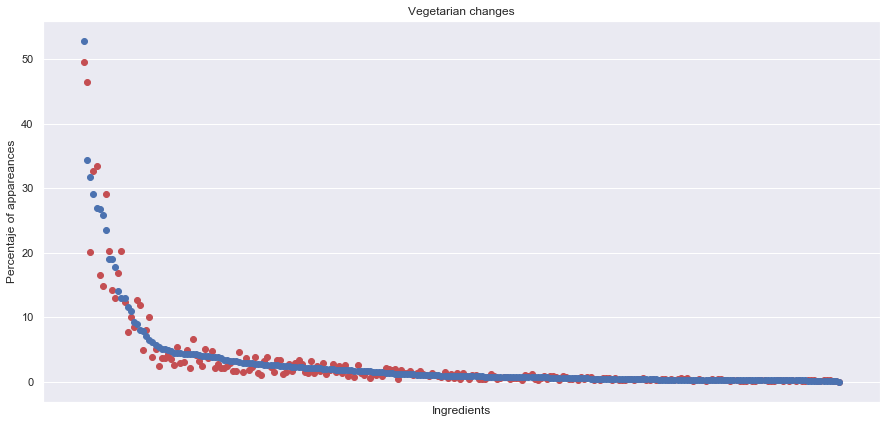

In [139]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_vegetarian_per))), ingredients_vegetarian_per, color='r')
ax.scatter(list(range(len(ingredients_vegetarian_per))), ingredients_vegetarian_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('Vegetarian changes')
plt.xticks([])
plt.show()

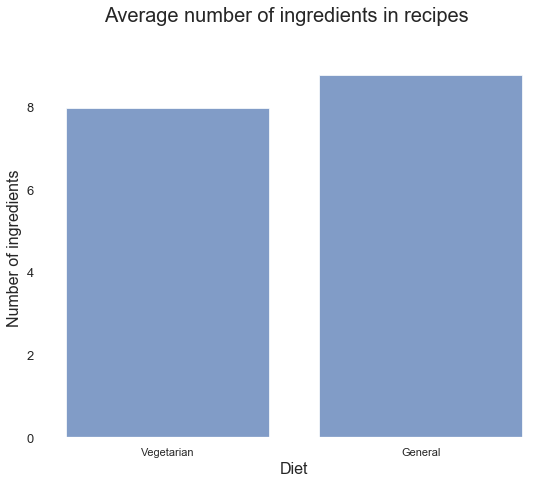

In [140]:
mean_vegetarian = df_ingredients[df_ingredients["Vegetarian"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_vegetarian, mean_general]
_keys = ["Vegetarian", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

## Iron rich

In [141]:
df_ironRich = df_ingredients[df_ingredients["IronRich"] == 1]
df_ironRich.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
3,00003a70b1,"[water, butter, milk, french - fried onions, p...",0,1,0,1,1,0,0,0,0,1,0,7
5,0000631d90,"[salt, coconut, beef, pepper, mandarin, lemon,...",1,1,0,0,1,0,0,0,0,0,1,11
11,0000b1e2b5,"[fennel seeds, butter, white wine, fennel bulb...",0,1,0,0,1,0,1,0,0,1,0,9
14,00010379bf,"[water, sesame seeds, flour, sugar, baking pow...",1,0,1,1,1,0,1,0,0,1,0,7
15,000106ec3c,"[1 can tomato sauce, onion, beef, potatoes, me...",1,1,0,0,1,0,0,0,0,0,0,6


In [142]:
# Getting the not iron Rich ingredients
ingredients_not_ironRich = df_common_ing[df_common_ing["IronRich"] == 0].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_not_ironRich)))

Ingredients abailable for gluten intolerance people: 230


In [143]:
# Getting the iron rich ingredients
ingredients_ironRich = df_common_ing[df_common_ing["IronRich"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_ironRich)))

Ingredients abailable for gluten intolerance people: 35


In [145]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_ironRich = {}
 
for row in df_ironRich.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_ironRich:
            if ing in dic_ingredients_not_ironRich:
                dic_ingredients_not_ironRich[ing] += 1
            else:
                dic_ingredients_not_ironRich[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_ironRich)))

(Time: 5.77 seconds)
Number of different ingredients: 230


In [146]:
len(df_ingredients)

779088

In [147]:
len(df_glutenFree)

545587

In [148]:
dic_ingredients_ironRich_per = {}
ingredients_ironRich_per = []
ingredients_ironRich_per_general = []
keys_ironRich = []

for key in ingredients_not_ironRich:
    print(key)
    ingredients_ironRich_per_general.append(dic_ingredients_per[key])
    keys_ironRich.append(key)
    if key in dic_ingredients_not_ironRich:
        ingredients_ironRich_per.append((dic_ingredients_not_ironRich[key]/len(df_ironRich))*100)
        dic_ingredients_ironRich_per[key] = (dic_ingredients_not_ironRich[key]/len(df_ironRich))*100
    else: 
        ingredients_ironRich_per.append(0)
        dic_ingredients_ironRich_per[key] = 0
        
dic_ingredients_ironRich_per

salt
sugar
pepper
butter
egg
garlic
onion
flour
water
olive oil
cheese
milk
vanilla
lemon
tomatoes
vegetable oil
chicken
vinegar
cinnamon
baking powder
bell pepper
cream
baking soda
carrot
ginger
celery
chicken broth
mustard
sour cream
basil
soy sauce
cream cheese
chili
cumin
honey
chocolate
lime
cilantro
scallions
nutmeg
oil
orange
oregano
mayonnaise
pasta
paprika
cayenne
bacon
cornstarch
wine
pork
worcestershire sauce
apple
red pepper flakes
bread
walnuts
mushrooms
bay leaf
almonds
pecans
rice
raisins
syrup
breadcrumbs
shallot
cloves
margarine
bananas
pineapple
scallion
rosemary
yogurt
jalapeno
yeast
lettuce
zucchini
peanut butter
coriander
buttermilk
dill
shortening
ketchup
cucumber
tomato sauce
strawberries
chives
mint
white wine
corn
curry
avocado
hot sauce
coconut
pumpkin
cranberries
blueberries
beef broth
seasoning
cool whip
allspice
cornmeal
salmon
cherries
vegetable broth
coffee
turmeric
half - and - half
cooking spray
ham
asparagus
nuts
leek
evaporated milk
salsa
gelatin
red 

{'salt': 60.35748031020669,
 'sugar': 22.32667095329089,
 'pepper': 44.598098791594595,
 'butter': 26.304175232368237,
 'egg': 21.57288921491383,
 'garlic': 38.90352982373522,
 'onion': 39.37958661244993,
 'flour': 19.480895844087627,
 'water': 18.14932546043476,
 'olive oil': 27.392736285066547,
 'cheese': 22.97177771136529,
 'milk': 11.551244781336884,
 'vanilla': 7.96617793113025,
 'lemon': 12.932624530961803,
 'tomatoes': 17.15887376495413,
 'vegetable oil': 12.827270175057281,
 'chicken': 11.038962999187957,
 'vinegar': 10.61663995073401,
 'cinnamon': 6.238245744317958,
 'baking powder': 4.912109109680224,
 'bell pepper': 11.728445374219277,
 'cream': 5.789659575624202,
 'baking soda': 5.20402218177098,
 'carrot': 9.94708132209151,
 'ginger': 6.1754557556986445,
 'celery': 8.855501519940349,
 'chicken broth': 7.735243597987098,
 'mustard': 6.003688911831385,
 'sour cream': 5.1702121878990415,
 'basil': 6.6657006668417536,
 'soy sauce': 5.398429646534626,
 'cream cheese': 2.8675101

In [149]:
dic_more_per_ironRich = {}
dic_less_per_ironRich = {}
dic_double_ironRich = {}
dic_half_ironRich = {}
mean_change_ironRich = 0
absolute_change_ironRich = 0
dic_changes_ironRich = {}
mean_total = 0

for key in dic_ingredients_ironRich_per:
    change = dic_ingredients_ironRich_per[key] - dic_ingredients_per[key]
    dic_changes_ironRich[key] = change
    mean_change_ironRich += change
    absolute_change_ironRich += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_ironRich_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]
    elif dic_ingredients_ironRich_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]
        
    if dic_ingredients_ironRich_per[key] > 2*dic_ingredients_per[key]:
        dic_double_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]
    elif dic_ingredients_ironRich_per[key]*2 < dic_ingredients_per[key]:
        dic_half_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]

mean_change_ironRich = mean_change_ironRich/len(dic_ingredients_ironRich_per)
absolute_change_ironRich = absolute_change_ironRich/len(dic_ingredients_ironRich_per)
mean_total = mean_total/len(dic_ingredients_ironRich_per)

print(dic_less_per_ironRich)
print()
print(dic_more_per_ironRich)
print()
print(dic_double_ironRich)
print()
print(dic_half_ironRich)

{'sugar': [34.45451604953484, 22.32667095329089], 'butter': [29.072839011767606, 26.304175232368237], 'egg': [26.97975068284969, 21.57288921491383], 'flour': [23.47064773170682, 19.480895844087627], 'milk': [14.144871952847431, 11.551244781336884], 'vanilla': [12.97517096913314, 7.96617793113025], 'cinnamon': [8.955085946645308, 6.238245744317958], 'baking powder': [7.974452179984803, 4.912109109680224]}

{'salt': [52.792239130881235, 60.35748031020669], 'pepper': [31.675754215184938, 44.598098791594595], 'garlic': [26.720986589448177, 38.90352982373522], 'onion': [25.87653769535662, 39.37958661244993], 'olive oil': [19.051121311071405, 27.392736285066547], 'cheese': [17.739074404945267, 22.97177771136529], 'tomatoes': [11.635142628303862, 17.15887376495413], 'bell pepper': [7.89384511120695, 11.728445374219277], 'carrot': [6.0914813217505595, 9.94708132209151], 'celery': [5.427628201178814, 8.855501519940349], 'chicken broth': [5.421852216951102, 7.735243597987098], 'oregano': [3.8036

In [150]:
printMain("Mean change: " + str(mean_change_ironRich))
printMain("Mean change in absolute value: " + str(absolute_change_ironRich))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: 0.2592025676480329
Mean change in absolute value: 0.9101545985317505
Mean total: 3.0790421397951158



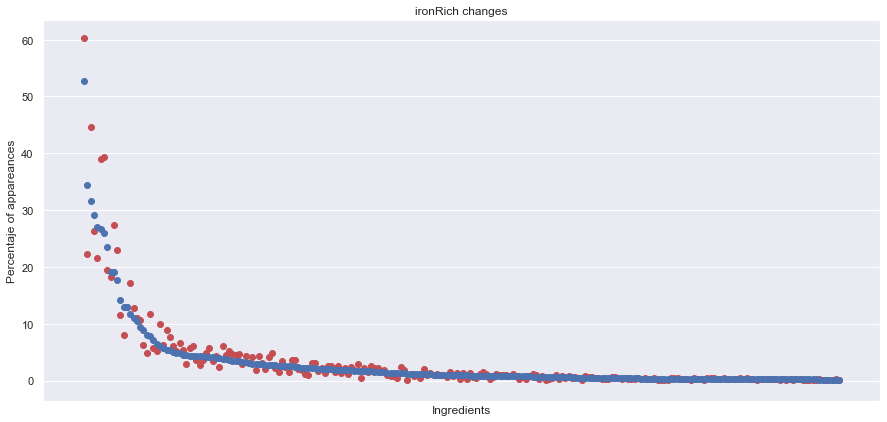

In [151]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_ironRich_per))), ingredients_ironRich_per, color='r')
ax.scatter(list(range(len(ingredients_ironRich_per))), ingredients_ironRich_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('ironRich changes')
plt.xticks([])
plt.show()

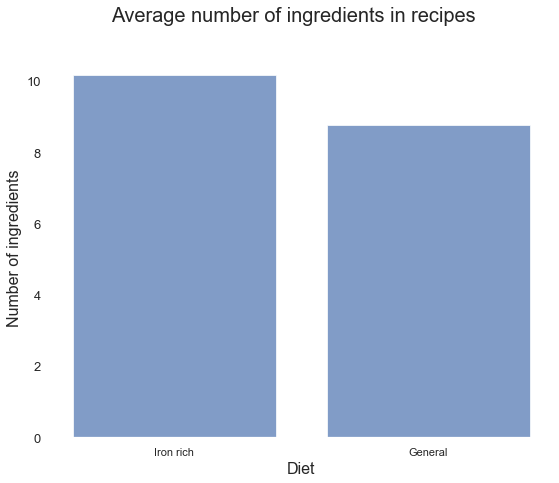

In [152]:
mean_ironRich = df_ingredients[df_ingredients["IronRich"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_ironRich, mean_general]
_keys = ["Iron rich", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

## Omega 3 Rich

In [153]:
df_omega3Rich = df_ingredients[df_ingredients["Omega3Rich"] == 1]
df_omega3Rich.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
20,000128a538,"[oat, yogurt, coconut, blueberries, pecans, soy]",0,1,0,1,1,1,1,0,0,0,0,6
28,00019675ca,"[salt, onion, pepper, cilantro, crab, bacon bi...",0,1,0,0,1,1,0,0,0,0,1,11
34,0001d81db6,"[fresh jalapenos, cilantro, tomatoes, cream ch...",0,1,0,1,0,1,1,0,0,1,0,8
52,00039c5d51,"[salt, onion, pepper, pumpkin, stock, coconut ...",1,1,0,0,1,1,1,1,0,1,1,10
56,0003dc1278,"[salt, nori, cucumber, striped bass, scallion,...",1,1,1,1,1,1,1,0,0,0,1,8


In [154]:
# Getting the not omega 3 rich ingredients
ingredients_not_omega3Rich = df_common_ing[df_common_ing["Omega3Rich"] == 0].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_not_omega3Rich)))

Ingredients abailable for gluten intolerance people: 255


In [155]:
# Getting the omega3 rich ingredients
ingredients_omega3Rich = df_common_ing[df_common_ing["Omega3Rich"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_omega3Rich)))

Ingredients abailable for gluten intolerance people: 10


In [156]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_omega3Rich = {}
 
for row in df_omega3Rich.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_omega3Rich:
            if ing in dic_ingredients_not_omega3Rich:
                dic_ingredients_not_omega3Rich[ing] += 1
            else:
                dic_ingredients_not_omega3Rich[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_omega3Rich)))

(Time: 1.45 seconds)
Number of different ingredients: 255


In [157]:
len(df_ingredients)

779088

In [158]:
len(df_omega3Rich)

88072

In [159]:
dic_ingredients_omega3Rich_per = {}
ingredients_omega3Rich_per = []
ingredients_omega3Rich_per_general = []
keys_omega3Rich = []

for key in ingredients_not_omega3Rich:
    ingredients_omega3Rich_per_general.append(dic_ingredients_per[key])
    keys_omega3Rich.append(key)
    if key in dic_ingredients_not_omega3Rich:
        ingredients_omega3Rich_per.append((dic_ingredients_not_omega3Rich[key]/len(df_omega3Rich))*100)
        dic_ingredients_omega3Rich_per[key] = (dic_ingredients_not_omega3Rich[key]/len(df_omega3Rich))*100
    else: 
        ingredients_omega3Rich_per.append(0)
        dic_ingredients_omega3Rich_per[key] = 0

In [160]:
dic_more_per_omega3Rich = {}
dic_less_per_omega3Rich = {}
dic_double_omega3Rich = {}
dic_half_omega3Rich = {}
mean_change_omega3Rich = 0
absolute_change_omega3Rich = 0
dic_changes_omega3Rich = {}
mean_total = 0

for key in dic_ingredients_omega3Rich_per:
    change = dic_ingredients_omega3Rich_per[key] - dic_ingredients_per[key]
    dic_changes_omega3Rich[key] = change
    mean_change_omega3Rich += change
    absolute_change_omega3Rich += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_omega3Rich_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]
    elif dic_ingredients_omega3Rich_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]
        
    if dic_ingredients_omega3Rich_per[key] > 2*dic_ingredients_per[key]:
        dic_double_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]
    elif dic_ingredients_omega3Rich_per[key]*2 < dic_ingredients_per[key]:
        dic_half_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]

mean_change_omega3Rich = mean_change_omega3Rich/len(dic_ingredients_omega3Rich_per)
absolute_change_omega3Rich = absolute_change_omega3Rich/len(dic_ingredients_omega3Rich_per)
mean_total = mean_total/len(dic_ingredients_omega3Rich_per)

print(dic_less_per_omega3Rich)
print()
print(dic_more_per_omega3Rich)
print()
print(dic_double_omega3Rich)
print()
print(dic_half_omega3Rich)

{'sugar': [34.45451604953484, 24.169997274956852], 'butter': [29.072839011767606, 23.23894086656372], 'egg': [26.97975068284969, 22.184122081932962], 'flour': [23.47064773170682, 18.76305749841039], 'water': [19.055870453658635, 14.03737850849305], 'milk': [14.144871952847431, 7.842447088745572], 'vanilla': [12.97517096913314, 10.039513125624488], 'chicken': [10.426164951841127, 6.628667453901353], 'cream': [7.073912061281909, 4.892587882641475], 'potatoes': [5.098140389789087, 2.755699881914797]}

{'salt': [52.792239130881235, 56.96929784721591], 'pepper': [31.675754215184938, 37.21273503497139], 'garlic': [26.720986589448177, 35.936506494686164], 'onion': [25.87653769535662, 33.24325551821237], 'olive oil': [19.051121311071405, 26.933645199382322], 'lemon': [12.936279341999876, 19.239940049050777], 'tomatoes': [11.635142628303862, 20.76142247252248], 'vegetable oil': [11.030589612469965, 13.735352893087475], 'parsley': [8.566041320107614, 12.26950676719048], 'bell pepper': [7.8938451

In [161]:
printMain("Mean change: " + str(mean_change_omega3Rich))
printMain("Mean change in absolute value: " + str(absolute_change_omega3Rich))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: 0.27143632950058555
Mean change in absolute value: 0.9583792939927517
Mean total: 2.958403249168562



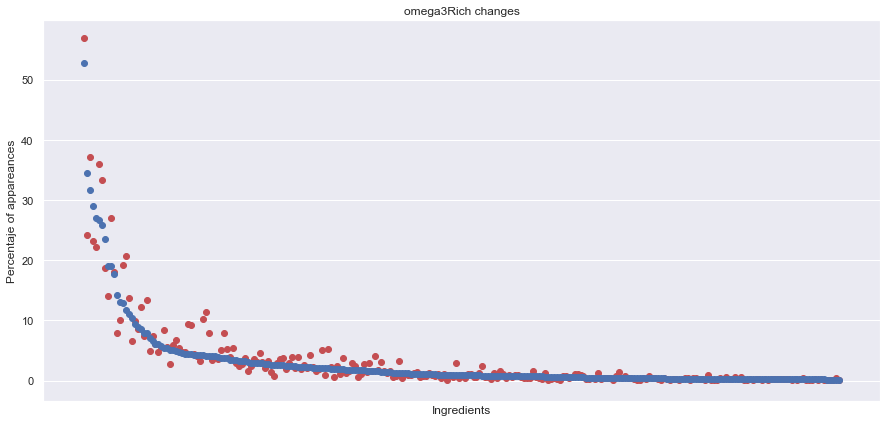

In [162]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_omega3Rich_per))), ingredients_omega3Rich_per, color='r')
ax.scatter(list(range(len(ingredients_omega3Rich_per))), ingredients_omega3Rich_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('omega3Rich changes')
plt.xticks([])
plt.show()

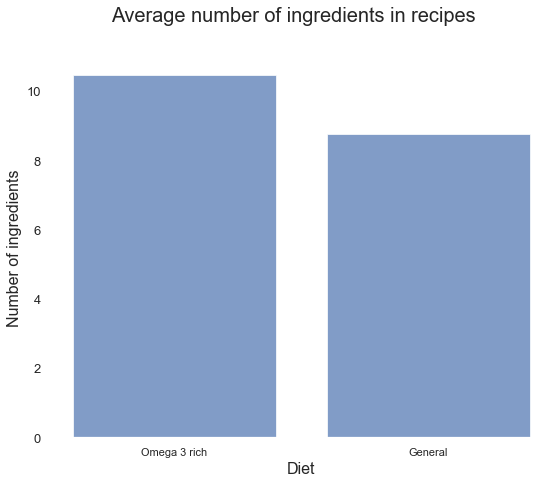

In [163]:
mean_omega3Rich = df_ingredients[df_ingredients["Omega3Rich"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_omega3Rich, mean_general]
_keys = ["Omega 3 rich", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

## Magnesium

In [164]:
df_magnesiumRich = df_ingredients[df_ingredients["MagnesiumRich"] == 1]
df_magnesiumRich.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
11,0000b1e2b5,"[fennel seeds, butter, white wine, fennel bulb...",0,1,0,0,1,0,1,0,0,1,0,9
14,00010379bf,"[water, sesame seeds, flour, sugar, baking pow...",1,0,1,1,1,0,1,0,0,1,0,7
16,00010c7867,"[salt, oat, onion, beef, butter, pepper, tomat...",0,0,0,0,1,0,1,1,0,1,1,14
17,00010d44c7,"[salt, onion, butter, broccoli, milk, pepper, ...",0,1,0,1,1,0,1,0,0,1,1,12
20,000128a538,"[oat, yogurt, coconut, blueberries, pecans, soy]",0,1,0,1,1,1,1,0,0,0,0,6


In [165]:
# Getting the not omega 3 rich ingredients
ingredients_not_magnesiumRich = df_common_ing[df_common_ing["MagnesiumRich"] == 0].index.tolist()
printMain("Ingredients not rich in magnesium: " + str(len(ingredients_not_magnesiumRich)))

Ingredients not rich in magnesium: 240


In [166]:
# Getting the omega3 rich ingredients
ingredients_magnesiumRich = df_common_ing[df_common_ing["MagnesiumRich"] == 1].index.tolist()
printMain("Ingredients rich in magnesium: " + str(len(ingredients_magnesiumRich)))

Ingredients rich in magnesium: 25


In [167]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_magnesiumRich = {}
 
for row in df_magnesiumRich.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_magnesiumRich:
            if ing in dic_ingredients_not_magnesiumRich:
                dic_ingredients_not_magnesiumRich[ing] += 1
            else:
                dic_ingredients_not_magnesiumRich[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_magnesiumRich)))

(Time: 3.2 seconds)
Number of different ingredients: 240


In [168]:
len(df_ingredients)

779088

In [169]:
len(df_magnesiumRich)

195876

In [170]:
dic_ingredients_magnesiumRich_per = {}
ingredients_magnesiumRich_per = []
ingredients_magnesiumRich_per_general = []
keys_magnesiumRich = []

for key in ingredients_not_magnesiumRich:
    ingredients_magnesiumRich_per_general.append(dic_ingredients_per[key])
    keys_magnesiumRich.append(key)
    if key in dic_ingredients_not_magnesiumRich:
        ingredients_magnesiumRich_per.append((dic_ingredients_not_magnesiumRich[key]/len(df_magnesiumRich))*100)
        dic_ingredients_magnesiumRich_per[key] = (dic_ingredients_not_magnesiumRich[key]/len(df_magnesiumRich))*100
    else: 
        ingredients_magnesiumRich_per.append(0)
        dic_ingredients_magnesiumRich_per[key] = 0

In [171]:
dic_more_per_magnesiumRich = {}
dic_less_per_magnesiumRich = {}
dic_double_magnesiumRich = {}
dic_half_magnesiumRich = {}
mean_change_magnesiumRich = 0
absolute_change_magnesiumRich = 0
dic_changes_magnesiumRich = {}
mean_total = 0

for key in dic_ingredients_magnesiumRich_per:
    change = dic_ingredients_magnesiumRich_per[key] - dic_ingredients_per[key]
    dic_changes_magnesiumRich[key] = change
    mean_change_magnesiumRich += change
    absolute_change_magnesiumRich += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_magnesiumRich_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]
    elif dic_ingredients_magnesiumRich_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]
        
    if dic_ingredients_magnesiumRich_per[key] > 2*dic_ingredients_per[key]:
        dic_double_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]
    elif dic_ingredients_magnesiumRich_per[key]*2 < dic_ingredients_per[key]:
        dic_half_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]

mean_change_magnesiumRich = mean_change_magnesiumRich/len(dic_ingredients_magnesiumRich_per)
absolute_change_magnesiumRich = absolute_change_magnesiumRich/len(dic_ingredients_magnesiumRich_per)
mean_total = mean_total/len(dic_ingredients_magnesiumRich_per)

print(dic_less_per_magnesiumRich)
print()
print(dic_more_per_magnesiumRich)
print()
print(dic_double_magnesiumRich)
print()
print(dic_half_magnesiumRich)

{'pepper': [31.675754215184938, 29.35224325593743], 'parsley': [8.566041320107614, 6.457656884968041]}

{'vanilla': [12.97517096913314, 17.18740427617472], 'vegetable oil': [11.030589612469965, 13.570319998366315], 'baking soda': [6.496313638510669, 9.64283526312565], 'chocolate': [4.234438214938492, 6.305009291592641], 'cilantro': [4.08914012281026, 6.202903877963609]}

{'wheat germ': [0.2662086952950116, 0.6427535787947477], 'tahini': [0.2640266568089869, 0.6034429945475709]}

{'barbecue sauce': [0.7504928839874314, 0.35175314995201046], 'vodka': [0.6424178013266794, 0.16438971594273927], 'bourbon': [0.3715883186494979, 0.16643182421531988], 'apple cider': [0.3667108208572074, 0.14805284976209437], 'tequila': [0.3288460353644261, 0.11486859033265943], 'pepperoni': [0.275706980469472, 0.09036329106169208], 'pizza sauce': [0.2121711539646356, 0.07249484367661173], 'mussels': [0.19702523976752304, 0.08321591210765994], 'gin': [0.18778366500318322, 0.022973718066531888], 'club soda': [0.

In [172]:
printMain("Mean change: " + str(mean_change_magnesiumRich))
printMain("Mean change in absolute value: " + str(absolute_change_magnesiumRich))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: 0.05007768024298274
Mean change in absolute value: 0.40464412562912366
Mean total: 3.0726760006571796



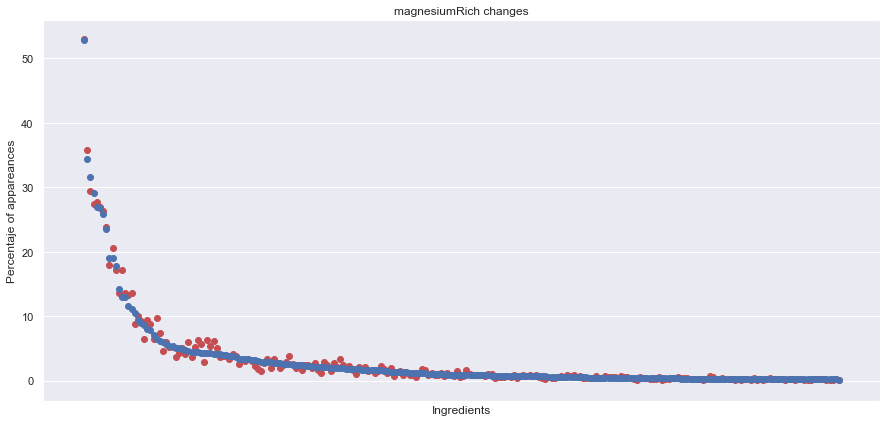

In [173]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_magnesiumRich_per))), ingredients_magnesiumRich_per, color='r')
ax.scatter(list(range(len(ingredients_magnesiumRich_per))), ingredients_magnesiumRich_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('magnesiumRich changes')
plt.xticks([])
plt.show()

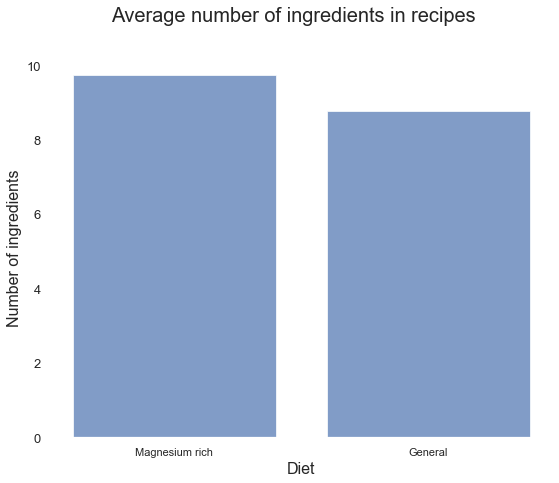

In [174]:
mean_magnesiumRich = df_ingredients[df_ingredients["MagnesiumRich"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_magnesiumRich, mean_general]
_keys = ["Magnesium rich", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

## Spicy food

In [175]:
df_spicy = df_ingredients[df_ingredients["Spicy"] == 1]
df_spicy.head()

,id,ingredients,LactoseFree,GlutenFree,Vegan,Vegetarian,IronRich,Omega3Rich,MagnesiumRich,Spicy,Alcoholic,Unhealthy,Salty,length
16,00010c7867,"[salt, oat, onion, beef, butter, pepper, tomat...",0,0,0,0,1,0,1,1,0,1,1,14
33,0001d6acb7,"[salt, coarse sea salt, water, poblano chiles,...",0,0,0,1,0,0,0,1,0,1,1,18
36,0002491373,"[dried currants, onion, yellow pepper, pepper,...",1,1,1,1,1,0,0,1,0,1,0,14
42,0002e15d76,"[worcestershire sauce, paprika, water, salt, h...",1,1,0,1,0,0,0,1,0,1,1,15
48,00033f624d,"[curry, butter, cracked pepper, rock salt, flo...",0,0,0,0,0,0,0,1,0,1,0,8


In [176]:
# Getting the not omega 3 rich ingredients
ingredients_not_spicy = df_common_ing[df_common_ing["Spicy"] == 0].index.tolist()
printMain("Ingredients not spciy: " + str(len(ingredients_not_spicy)))

Ingredients not spciy: 254


In [177]:
# Getting the omega3 rich ingredients
ingredients_spicy = df_common_ing[df_common_ing["Spicy"] == 1].index.tolist()
printMain("Ingredients spicy: " + str(len(ingredients_spicy)))

Ingredients spicy: 11


In [178]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_spicy = {}
 
for row in df_spicy.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_spicy:
            if ing in dic_ingredients_not_spicy:
                dic_ingredients_not_spicy[ing] += 1
            else:
                dic_ingredients_not_spicy[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_spicy)))

(Time: 2.66 seconds)
Number of different ingredients: 254


In [179]:
len(df_ingredients)

779088

In [180]:
len(df_spicy)

171429

In [181]:
dic_ingredients_spicy_per = {}
ingredients_spicy_per = []
ingredients_spicy_per_general = []
keys_spicy = []

for key in ingredients_not_spicy:
    ingredients_spicy_per_general.append(dic_ingredients_per[key])
    keys_spicy.append(key)
    if key in dic_ingredients_not_spicy:
        ingredients_spicy_per.append((dic_ingredients_not_spicy[key]/len(df_spicy))*100)
        dic_ingredients_spicy_per[key] = (dic_ingredients_not_spicy[key]/len(df_spicy))*100
    else: 
        ingredients_spicy_per.append(0)
        dic_ingredients_spicy_per[key] = 0

In [182]:
dic_more_per_spicy = {}
dic_less_per_spicy = {}
dic_double_spicy = {}
dic_half_spicy = {}
mean_change_spicy = 0
absolute_change_spicy = 0
dic_changes_spicy = {}
mean_total = 0

for key in dic_ingredients_spicy_per:
    change = dic_ingredients_spicy_per[key] - dic_ingredients_per[key]
    dic_changes_spicy[key] = change
    mean_change_spicy += change
    absolute_change_spicy += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_spicy_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]
    elif dic_ingredients_spicy_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]
        
    if dic_ingredients_spicy_per[key] > 2*dic_ingredients_per[key]:
        dic_double_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]
    elif dic_ingredients_spicy_per[key]*2 < dic_ingredients_per[key]:
        dic_half_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]

mean_change_spicy = mean_change_spicy/len(dic_ingredients_spicy_per)
absolute_change_spicy = absolute_change_spicy/len(dic_ingredients_spicy_per)
mean_total = mean_total/len(dic_ingredients_spicy_per)

print(dic_less_per_spicy)
print()
print(dic_more_per_spicy)
print()
print(dic_double_spicy)
print()
print(dic_half_spicy)

{'sugar': [34.45451604953484, 23.0241091063939], 'butter': [29.072839011767606, 19.517701205746985], 'egg': [26.97975068284969, 16.655291695104097], 'flour': [23.47064773170682, 14.512713718215705], 'water': [19.055870453658635, 16.995957510106223], 'milk': [14.144871952847431, 8.341062480677133], 'vanilla': [12.97517096913314, 1.9856617025124104], 'baking powder': [7.974452179984803, 2.8163262925176022], 'cream': [7.073912061281909, 4.368572411902304], 'baking soda': [6.496313638510669, 3.0129091343938303], 'chocolate': [4.234438214938492, 0.3949156793774682], 'cocoa': [2.9870823321627338, 0.6509983725040688]}

{'salt': [52.792239130881235, 64.08483978790052], 'pepper': [31.675754215184938, 45.7915521877862], 'garlic': [26.720986589448177, 46.32996750841456], 'onion': [25.87653769535662, 43.86189034527413], 'olive oil': [19.051121311071405, 25.946018468287164], 'cheese': [17.739074404945267, 20.042116561375263], 'lemon': [12.936279341999876, 15.332295002595828], 'tomatoes': [11.635142

In [183]:
printMain("Mean change: " + str(mean_change_spicy))
printMain("Mean change in absolute value: " + str(absolute_change_spicy))
printMain("Mean total: " + str(mean_total))
printMain("")

Mean change: 0.423015154872887
Mean change in absolute value: 1.3290257937311023
Mean total: 2.908324285807384



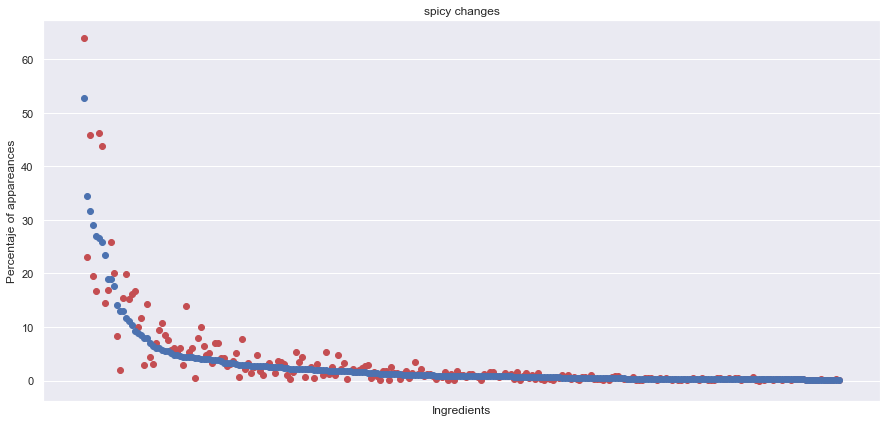

In [184]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_spicy_per))), ingredients_spicy_per, color='r')
ax.scatter(list(range(len(ingredients_spicy_per))), ingredients_spicy_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('spicy changes')
plt.xticks([])
plt.show()

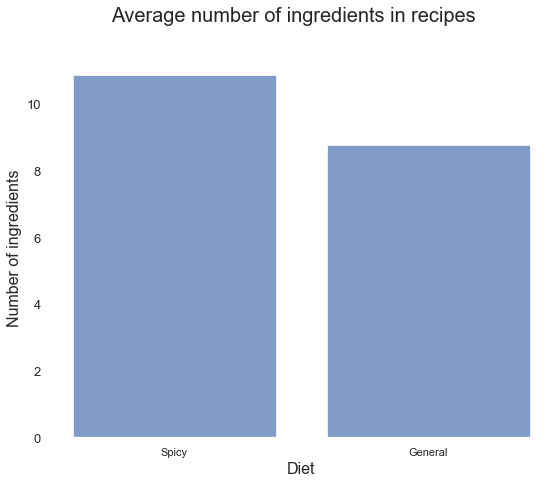

In [185]:
mean_spicy = df_ingredients[df_ingredients["Spicy"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_spicy, mean_general]
_keys = ["Spicy", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

# BETTER BOX PLOT?

# EXPORTING

In [217]:
dictionary_to_export = ratios_dict_toExport
dictionary_to_export["general"] = dic_ingredients_per

In [219]:
'''
file = open("searchData/data.txt","w") 
file.write("example_dic = " + str(json.dumps(dictionary_to_export)))
file.close() '''

'import json\nfile = open("searchData/data.txt","w") \nfile.write("example_dic = " + str(json.dumps(dictionary_to_export)))\nfile.close() '

In [224]:
dictionary_selectedIngredientsData_toExport = df_common_ing.drop(['Quantity', "Alcoholic"], axis=1).to_dict('index')

In [225]:
'''file = open("searchData/ingredients.txt","w") 
file.write("data = " + str(json.dumps(dictionary_selectedIngredientsData_toExport)))
file.close()'''

In [229]:
initial_time = time.time()
df_ingredients_exploded = df_ingredients.explode("ingredients")
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

(Time: 4.7 seconds)


In [ ]:
dictionary_selectedIngredinetsInDiets_toExport = {}
initial_time = time.time()
for ingredient in ingredient_list:
    to_add = {}
    to_add["LactoseFree"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["LactoseFree"] == 1)]
    )
    to_add["GlutenFree"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["GlutenFree"] == 1)]
    )
    to_add["Vegan"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["Vegan"] == 1)]
    )
    to_add["Vegetarian"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["Vegetarian"] == 1)]
    )
    to_add["IronRich"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["IronRich"] == 1)]
    )
    to_add["Omega3Rich"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["Omega3Rich"] == 1)]
    )
    to_add["MagnesiumRich"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["MagnesiumRich"] == 1)]
    )
    to_add["Spicy"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["Spicy"] == 1)]
    )
    to_add["Unhealthy"] = len(
        df_ingredients_exploded[(df_ingredients_exploded["ingredients"] == ingredient) & (df_ingredients_exploded["Unhealthy"] == 1)]
    )
    dictionary_selectedIngredinetsInDiets_toExport[ingredient] = to_add
print("(Time:", round(time.time() - initial_time, 2), "seconds)")